In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import argparse
import torch
from torch.optim import lr_scheduler
from tqdm import tqdm
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from trainer import Trainer
from utils import Logger
from utils import util
from utils import torchsummary
from utils import viewTraining
from utils import lr_finder
from utils import classActivationMap
import importlib
import math
import torchvision
from torch.nn import functional as F
from torch import topk
import skimage.transform
print("Modules loaded")

importlib.reload(module_data) #load recent changes to data_loaders.py
importlib.reload(module_arch)
importlib.reload(module_loss)
importlib.reload(module_metric)
importlib.reload(util)
importlib.reload(viewTraining)
importlib.reload(lr_finder)
importlib.reload(classActivationMap)
print("Reload complete")

print("GPUs available: " + str(torch.cuda.device_count()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

Modules loaded
Reload complete
GPUs available: 1


/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
resplit_data = False
if resplit_data:
    os.system('python3 utils/splitDataFolder.py -r "data/allDAPI_volume_0619/" -c "data/allDAPI_volume_0619/Label_all.csv" -s 0.15')
    
print("fin")

fin


In [8]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

def set_instance(module, name, config, *args):
    setattr(module, config[name]['type'])(*args, **config[name]['args'])

def main(config, resume):
    train_logger = Logger() #uses entries to store training performance metrics
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
    print("Total number of training images = " + str(data_loader.dataset.data_len))
    valid_data_loader = data_loader.split_validation() #allocate some images as validation

    # build model architecture
    model = get_instance(module_arch, 'arch', config) #looks in the model/model.py for 'MnistModel', as specified by config
    print(model)
    torchsummary.summary(model, (1,7,32,32))
     
    
    if torch.cuda.is_available():
        print("Using GPU: " + torch.cuda.get_device_name(0))
    else:
        print("Using CPU to train")
    
    normalized = False
    util.visualizeBatch(data_loader, normalized)
    
    
    # get function handles of loss and metrics
    loss = getattr(module_loss, config['loss']) #looks in model/loss.py for criterion function specified in config
    criterion = loss(data_loader.dataset.weight.to(device)) # for imbalanced datasets
    metrics = [getattr(module_metric, met) for met in config['metrics']] #get all the metrics in model/metrics.py - default is accuracy and top 3 accuracy

    # build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
    trainable_params = filter(lambda p: p.requires_grad, model.parameters()) #Number of training params
    optimizer = get_instance(torch.optim, 'optimizer', config, trainable_params)
    lr_scheduler = get_instance(torch.optim.lr_scheduler, 'lr_scheduler', config, optimizer)

    
    trainer = Trainer(model, criterion, metrics, optimizer,
                      resume=resume, #choose a previous epoch to start training from
                      config=config,
                      data_loader=data_loader,
                      valid_data_loader=valid_data_loader,
                      lr_scheduler=lr_scheduler,
                      train_logger=train_logger)
    
    
    findLR = False
    if findLR:
        #set lr = 1e-7 in config file 
        device_lr = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        lr_finder_training = lr_finder.LRFinder(model, optimizer, criterion, device=device_lr)
        lr_finder_training.range_test(data_loader, end_lr=1, num_iter=100, val_loader = valid_data_loader)
        lr_finder_training.plot(skip_start = 10, skip_end=5)
        # trim the first 10 and last 5 iteration from calculating loss (num_iter > skip_start + skip_end)
    else:
        trainer.train()
        a=1
    
 

In [9]:
config_file = 'configs/config_3d.json'

# load config file
with open(config_file) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

Total number of training images = 1313
threeDmodel(
  (conv_layer1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, t

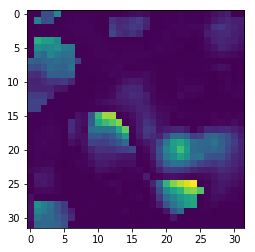

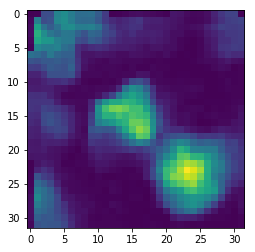

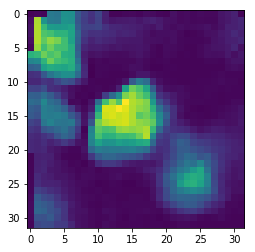

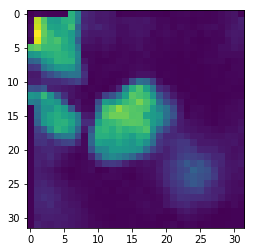

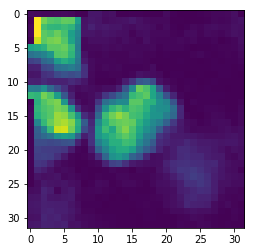

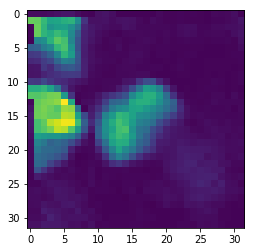

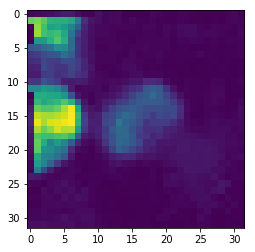

    epoch          : 1
    loss           : 0.9141933818658193
    my_metric      : 0.5893199233716475
    f1             : 0.526381262781919
    balanced_accuracy: 0.5704861128152741
    precision      : 0.6473285026859759
    recall         : 0.5893199233716475
    val_loss       : 0.6528845578432083
    val_my_metric  : 0.703125
    val_f1         : 0.6857851546048275
    val_balanced_accuracy: 0.6890415730548558
    val_precision  : 0.7426843943427661
    val_recall     : 0.703125
Saving checkpoint: saved/MaskedVolume_3d/0619_200535/checkpoint-epoch1.pth ...
Saving current best: model_best.pth ...
    epoch          : 2
    loss           : 0.7483117315504286
    my_metric      : 0.6199113984674329
    f1             : 0.583144895467592
    balanced_accuracy: 0.6064511038428319
    precision      : 0.6695321067012054
    recall         : 0.6199113984674329
    val_loss       : 0.6614248007535934
    val_my_metric  : 0.69921875
    val_f1         : 0.6948149204528447
    val_balance

Model has not improved in -------------| 1 epochs


    epoch          : 3
    loss           : 0.6968262692292532
    my_metric      : 0.6424808429118775
    f1             : 0.6215191036307759
    balanced_accuracy: 0.6321257038377229
    precision      : 0.6724217711863608
    recall         : 0.6424808429118775
    val_loss       : 0.5957870036363602
    val_my_metric  : 0.69140625
    val_f1         : 0.6843566776854381
    val_balanced_accuracy: 0.7022215641236775
    val_precision  : 0.7365189985795455
    val_recall     : 0.69140625
Saving checkpoint: saved/MaskedVolume_3d/0619_200535/checkpoint-epoch3.pth ...
Saving current best: model_best.pth ...
    epoch          : 4
    loss           : 0.6450851327843137
    my_metric      : 0.6643618295019157
    f1             : 0.6550705219163933
    balanced_accuracy: 0.6581994464784118
    precision      : 0.6814089510543968
    recall         : 0.6643618295019157
    val_loss       : 0.577988974750042
    val_my_metric  : 0.6484375
    val_f1         : 0.641383040317624
    val_bala

Model has not improved in -------------| 1 epochs


    epoch          : 7
    loss           : 0.6131131996711096
    my_metric      : 0.6846563697318008
    f1             : 0.6862410780445324
    balanced_accuracy: 0.6877052426712305
    precision      : 0.6968363712388406
    recall         : 0.6846563697318008
    val_loss       : 0.5820466056466103
    val_my_metric  : 0.6796875
    val_f1         : 0.7058250343755984
    val_balanced_accuracy: 0.6874356548160776
    val_precision  : 0.7606507316468254
    val_recall     : 0.6796875


Model has not improved in -------------| 2 epochs


    epoch          : 8
    loss           : 0.606745206647449
    my_metric      : 0.6989044540229885
    f1             : 0.6993376293874936
    balanced_accuracy: 0.7019321894169985
    precision      : 0.7122271570644247
    recall         : 0.6989044540229885
    val_loss       : 0.6729509681463242
    val_my_metric  : 0.58203125
    val_f1         : 0.568868898336188
    val_balanced_accuracy: 0.5865838001867414
    val_precision  : 0.5717029600301659
    val_recall     : 0.58203125


Model has not improved in -------------| 3 epochs


    epoch          : 9
    loss           : 0.590020067161984
    my_metric      : 0.7058488984674329
    f1             : 0.7059859339971779
    balanced_accuracy: 0.7074922663376852
    precision      : 0.7137394537844703
    recall         : 0.7058488984674329
    val_loss       : 0.9154685437679291
    val_my_metric  : 0.62890625
    val_f1         : 0.6187308774578452
    val_balanced_accuracy: 0.6408730158730158
    val_precision  : 0.6847125389230653
    val_recall     : 0.62890625


Model has not improved in -------------| 4 epochs


    epoch          : 10
    loss           : 0.6196391367250018
    my_metric      : 0.6858836206896552
    f1             : 0.6842231654960662
    balanced_accuracy: 0.68197221628579
    precision      : 0.6897294663322584
    recall         : 0.6858836206896552
    val_loss       : 0.739590659737587
    val_my_metric  : 0.57421875
    val_f1         : 0.555476949698319
    val_balanced_accuracy: 0.5890625
    val_precision  : 0.5963159307829612
    val_recall     : 0.57421875


Model has not improved in -------------| 5 epochs


    epoch          : 11
    loss           : 0.6076151960425906
    my_metric      : 0.6964798850574713
    f1             : 0.6966190207340346
    balanced_accuracy: 0.6964463802650482
    precision      : 0.7060300232737453
    recall         : 0.6964798850574713
    val_loss       : 0.553815171122551
    val_my_metric  : 0.7109375
    val_f1         : 0.7044039545803659
    val_balanced_accuracy: 0.7175070028011205
    val_precision  : 0.7484863084421061
    val_recall     : 0.7109375


Model has not improved in -------------| 6 epochs


    epoch          : 12
    loss           : 0.5939047899511125
    my_metric      : 0.6971384099616859
    f1             : 0.6986412687530711
    balanced_accuracy: 0.695892774817019
    precision      : 0.7070221586487014
    recall         : 0.6971384099616859
    val_loss       : 0.5725241005420685
    val_my_metric  : 0.72265625
    val_f1         : 0.7187021321353432
    val_balanced_accuracy: 0.721609278613589
    val_precision  : 0.7447028818400527
    val_recall     : 0.72265625


Model has not improved in -------------| 7 epochs


    epoch          : 13
    loss           : 0.5614297058847215
    my_metric      : 0.7192289272030652
    f1             : 0.7181945720083658
    balanced_accuracy: 0.7181776880519058
    precision      : 0.7246829721463757
    recall         : 0.7192289272030652
    val_loss       : 0.5367546752095222
    val_my_metric  : 0.74609375
    val_f1         : 0.7501832511969023
    val_balanced_accuracy: 0.7716869506423258
    val_precision  : 0.7871849423363095
    val_recall     : 0.74609375


Model has not improved in -------------| 8 epochs


    epoch          : 14
    loss           : 0.5934314346975751
    my_metric      : 0.7169540229885057
    f1             : 0.717982838184398
    balanced_accuracy: 0.7219722960438246
    precision      : 0.7291505862608836
    recall         : 0.7169540229885057
    val_loss       : 0.642042726278305
    val_my_metric  : 0.6875
    val_f1         : 0.6843371880988013
    val_balanced_accuracy: 0.7183892396072595
    val_precision  : 0.7514919295215443
    val_recall     : 0.6875


Model has not improved in -------------| 9 epochs


    epoch          : 15
    loss           : 0.5726662940449185
    my_metric      : 0.7221922892720306
    f1             : 0.7222681398433236
    balanced_accuracy: 0.7245325723818571
    precision      : 0.7340101326931574
    recall         : 0.7221922892720306
    val_loss       : 0.4970148727297783
    val_my_metric  : 0.8046875
    val_f1         : 0.8045572146678913
    val_balanced_accuracy: 0.8046711353162965
    val_precision  : 0.8136811197358071
    val_recall     : 0.8046875
Saving checkpoint: saved/MaskedVolume_3d/0619_200535/checkpoint-epoch15.pth ...
Saving current best: model_best.pth ...
    epoch          : 16
    loss           : 0.5719676630364524
    my_metric      : 0.7121048850574713
    f1             : 0.7125885434699609
    balanced_accuracy: 0.7183983635462903
    precision      : 0.7291804038239152
    recall         : 0.7121048850574713
    val_loss       : 0.5865262001752853
    val_my_metric  : 0.72265625
    val_f1         : 0.7252474855280056
    val_

Model has not improved in -------------| 1 epochs


    epoch          : 17
    loss           : 0.5703237139516406
    my_metric      : 0.7134818007662835
    f1             : 0.71134556337511
    balanced_accuracy: 0.7151667302378298
    precision      : 0.729017823290608
    recall         : 0.7134818007662835
    val_loss       : 0.5197689682245255
    val_my_metric  : 0.74609375
    val_f1         : 0.7404065759606901
    val_balanced_accuracy: 0.741111272095045
    val_precision  : 0.7677830474705474
    val_recall     : 0.74609375


Model has not improved in -------------| 2 epochs


    epoch          : 18
    loss           : 0.5583351933293872
    my_metric      : 0.7275502873563219
    f1             : 0.7285324209220382
    balanced_accuracy: 0.7309499744863144
    precision      : 0.7366521490213208
    recall         : 0.7275502873563219
    val_loss       : 0.6115516573190689
    val_my_metric  : 0.703125
    val_f1         : 0.703603690750868
    val_balanced_accuracy: 0.7039205250394767
    val_precision  : 0.7059564558582054
    val_recall     : 0.703125


Model has not improved in -------------| 3 epochs


    epoch          : 19
    loss           : 0.5575847956869338
    my_metric      : 0.7372784961685823
    f1             : 0.7375814392711193
    balanced_accuracy: 0.7378223763782086
    precision      : 0.7419156496898052
    recall         : 0.7372784961685823
    val_loss       : 0.6110642850399017
    val_my_metric  : 0.66796875
    val_f1         : 0.6676284189349923
    val_balanced_accuracy: 0.6275016110110659
    val_precision  : 0.6741979331843836
    val_recall     : 0.66796875


Model has not improved in -------------| 4 epochs


    epoch          : 20
    loss           : 0.5533482333024343
    my_metric      : 0.7294659961685823
    f1             : 0.728949073877878
    balanced_accuracy: 0.729663745226662
    precision      : 0.7368484849405462
    recall         : 0.7294659961685823
    val_loss       : 0.48928727209568024
    val_my_metric  : 0.8046875
    val_f1         : 0.805054819190345
    val_balanced_accuracy: 0.806603504022859
    val_precision  : 0.8089921852361635
    val_recall     : 0.8046875
Saving checkpoint: saved/MaskedVolume_3d/0619_200535/checkpoint-epoch20.pth ...
Saving current best: model_best.pth ...
    epoch          : 21
    loss           : 0.5653931217061149
    my_metric      : 0.7279094827586207
    f1             : 0.7283369408659813
    balanced_accuracy: 0.7303001122476509
    precision      : 0.7376495945243864
    recall         : 0.7279094827586207
    val_loss       : 0.64165860414505
    val_my_metric  : 0.72265625
    val_f1         : 0.7263184200684201
    val_balan

Model has not improved in -------------| 1 epochs


    epoch          : 22
    loss           : 0.5607568869988123
    my_metric      : 0.7167744252873564
    f1             : 0.7177333473110262
    balanced_accuracy: 0.7194030286720126
    precision      : 0.7269767154497094
    recall         : 0.7167744252873564
    val_loss       : 0.568791925907135
    val_my_metric  : 0.76953125
    val_f1         : 0.7423878670808791
    val_balanced_accuracy: 0.7152465515994895
    val_precision  : 0.7402469433719434
    val_recall     : 0.76953125


Model has not improved in -------------| 2 epochs


    epoch          : 23
    loss           : 0.5881087399191327
    my_metric      : 0.7096503831417624
    f1             : 0.7118027403350937
    balanced_accuracy: 0.7130731206015153
    precision      : 0.7242543153556606
    recall         : 0.7096503831417624
    val_loss       : 0.5858811289072037
    val_my_metric  : 0.75
    val_f1         : 0.7447002816321404
    val_balanced_accuracy: 0.7590525793650793
    val_precision  : 0.7936756297342817
    val_recall     : 0.75


Model has not improved in -------------| 3 epochs


    epoch          : 24
    loss           : 0.5542257130146027
    my_metric      : 0.7343450670498084
    f1             : 0.7333426766596296
    balanced_accuracy: 0.7337787450018601
    precision      : 0.7410898734008763
    recall         : 0.7343450670498084
    val_loss       : 0.5209142193198204
    val_my_metric  : 0.76171875
    val_f1         : 0.7584804081669267
    val_balanced_accuracy: 0.7711433531746031
    val_precision  : 0.785045086492455
    val_recall     : 0.76171875


Model has not improved in -------------| 4 epochs


    epoch          : 25
    loss           : 0.5591146465804842
    my_metric      : 0.7343151340996168
    f1             : 0.7336370983904786
    balanced_accuracy: 0.73489671237498
    precision      : 0.7446200338168367
    recall         : 0.7343151340996168
    val_loss       : 0.6387842893600464
    val_my_metric  : 0.68359375
    val_f1         : 0.6753259022422851
    val_balanced_accuracy: 0.6778282939651474
    val_precision  : 0.7079032042280062
    val_recall     : 0.68359375


Model has not improved in -------------| 5 epochs


    epoch          : 26
    loss           : 0.5631815526220534
    my_metric      : 0.7232100095785441
    f1             : 0.7237505424874057
    balanced_accuracy: 0.7254630282423196
    precision      : 0.7300564003966982
    recall         : 0.7232100095785441
    val_loss       : 0.5321115776896477
    val_my_metric  : 0.75390625
    val_f1         : 0.7807228282579263
    val_balanced_accuracy: 0.7621323529411764
    val_precision  : 0.8350262829490771
    val_recall     : 0.75390625


Model has not improved in -------------| 6 epochs


    epoch          : 27
    loss           : 0.5509787599245707
    my_metric      : 0.756555316091954
    f1             : 0.7572019597436493
    balanced_accuracy: 0.7592502528919726
    precision      : 0.766705356916359
    recall         : 0.756555316091954
    val_loss       : 0.681614100933075
    val_my_metric  : 0.63671875
    val_f1         : 0.6502026285197624
    val_balanced_accuracy: 0.6204295256714611
    val_precision  : 0.6789193722157432
    val_recall     : 0.63671875


Model has not improved in -------------| 7 epochs


    epoch          : 28
    loss           : 0.5479676475127538
    my_metric      : 0.7372784961685823
    f1             : 0.7384512851208824
    balanced_accuracy: 0.7423393426112443
    precision      : 0.7495006990269639
    recall         : 0.7372784961685823
    val_loss       : 0.574556939303875
    val_my_metric  : 0.75
    val_f1         : 0.7231870237501781
    val_balanced_accuracy: 0.6945095042147322
    val_precision  : 0.7201187025290885
    val_recall     : 0.75


Model has not improved in -------------| 8 epochs


    epoch          : 29
    loss           : 0.540823746058676
    my_metric      : 0.7537715517241379
    f1             : 0.7540158131782637
    balanced_accuracy: 0.755000196275272
    precision      : 0.7613341138198265
    recall         : 0.7537715517241379
    val_loss       : 0.5008230805397034
    val_my_metric  : 0.7890625
    val_f1         : 0.7863754365193663
    val_balanced_accuracy: 0.7979157938835358
    val_precision  : 0.8185325851199066
    val_recall     : 0.7890625


Model has not improved in -------------| 9 epochs


    epoch          : 30
    loss           : 0.5489636411269506
    my_metric      : 0.7502993295019157
    f1             : 0.7512405229939302
    balanced_accuracy: 0.7543487293741781
    precision      : 0.7594512071423011
    recall         : 0.7502993295019157
    val_loss       : 0.49761663377285004
    val_my_metric  : 0.81640625
    val_f1         : 0.8160846785979438
    val_balanced_accuracy: 0.8153394544523578
    val_precision  : 0.8175413246922824
    val_recall     : 0.81640625


Model has not improved in -------------| 10 epochs


    epoch          : 31
    loss           : 0.5441323733992047
    my_metric      : 0.7433548850574713
    f1             : 0.7439967472297577
    balanced_accuracy: 0.746546136737823
    precision      : 0.7530946261065331
    recall         : 0.7433548850574713
    val_loss       : 0.5048684999346733
    val_my_metric  : 0.8046875
    val_f1         : 0.802826343707884
    val_balanced_accuracy: 0.8106925528832223
    val_precision  : 0.826757421909537
    val_recall     : 0.8046875


Model has not improved in -------------| 11 epochs


    epoch          : 32
    loss           : 0.5488915824227862
    my_metric      : 0.7529334291187739
    f1             : 0.7532269752552886
    balanced_accuracy: 0.7533836083236094
    precision      : 0.7583168901195068
    recall         : 0.7529334291187739
    val_loss       : 0.49737370759248734
    val_my_metric  : 0.78125
    val_f1         : 0.7786281686097862
    val_balanced_accuracy: 0.790575137228363
    val_precision  : 0.8050045225045225
    val_recall     : 0.78125


Model has not improved in -------------| 12 epochs


    epoch          : 33
    loss           : 0.5445146974590089
    my_metric      : 0.740930316091954
    f1             : 0.7408717917195309
    balanced_accuracy: 0.7417329182898883
    precision      : 0.7490460766518215
    recall         : 0.740930316091954
    val_loss       : 0.7132459729909897
    val_my_metric  : 0.65234375
    val_f1         : 0.6913785643026261
    val_balanced_accuracy: 0.654309109180879
    val_precision  : 0.8471119878944979
    val_recall     : 0.65234375


Model has not improved in -------------| 13 epochs


    epoch          : 34
    loss           : 0.5408441291915046
    my_metric      : 0.7445821360153256
    f1             : 0.7455975675380061
    balanced_accuracy: 0.748679629600895
    precision      : 0.754477113205324
    recall         : 0.7445821360153256
    val_loss       : 0.8173327893018723
    val_my_metric  : 0.63671875
    val_f1         : 0.6774732826785274
    val_balanced_accuracy: 0.6431764329914235
    val_precision  : 0.7807914133201358
    val_recall     : 0.63671875


Model has not improved in -------------| 14 epochs


    epoch          : 35
    loss           : 0.5617645167642169
    my_metric      : 0.7067169540229885
    f1             : 0.7066629398279524
    balanced_accuracy: 0.7086038211818491
    precision      : 0.7207491735043496
    recall         : 0.7067169540229885
    val_loss       : 0.6246410608291626
    val_my_metric  : 0.75390625
    val_f1         : 0.7272506330899006
    val_balanced_accuracy: 0.6939702322766839
    val_precision  : 0.7129825367647059
    val_recall     : 0.75390625


Model has not improved in -------------| 15 epochs


    epoch          : 36
    loss           : 0.5278385265005959
    my_metric      : 0.7424868295019157
    f1             : 0.742813676530076
    balanced_accuracy: 0.7466745655195736
    precision      : 0.7521923814765474
    recall         : 0.7424868295019157
    val_loss       : 0.5540459603071213
    val_my_metric  : 0.734375
    val_f1         : 0.730611891044187
    val_balanced_accuracy: 0.7342212117254562
    val_precision  : 0.7572492124282972
    val_recall     : 0.734375


Model has not improved in -------------| 16 epochs


    epoch          : 37
    loss           : 0.5383649849229388
    my_metric      : 0.744073275862069
    f1             : 0.7451650676606958
    balanced_accuracy: 0.747141486255583
    precision      : 0.75283772264973
    recall         : 0.744073275862069
    val_loss       : 0.6916480660438538
    val_my_metric  : 0.7265625
    val_f1         : 0.7316332801449025
    val_balanced_accuracy: 0.7543262319590591
    val_precision  : 0.7729012725779967
    val_recall     : 0.7265625


Model has not improved in -------------| 17 epochs


    epoch          : 38
    loss           : 0.533760001262029
    my_metric      : 0.7383261494252874
    f1             : 0.7392652342142615
    balanced_accuracy: 0.7442251205640964
    precision      : 0.7510657005021458
    recall         : 0.7383261494252874
    val_loss       : 0.7436504140496254
    val_my_metric  : 0.69921875
    val_f1         : 0.6993316203459797
    val_balanced_accuracy: 0.7450552473077501
    val_precision  : 0.7917848281722512
    val_recall     : 0.69921875


Model has not improved in -------------| 18 epochs


    epoch          : 39
    loss           : 0.5380604167779287
    my_metric      : 0.7508081896551724
    f1             : 0.7513280567442725
    balanced_accuracy: 0.7525744481427313
    precision      : 0.7564744546088099
    recall         : 0.7508081896551724
    val_loss       : 0.5767036527395248
    val_my_metric  : 0.73828125
    val_f1         : 0.7324345840209592
    val_balanced_accuracy: 0.7458903433168138
    val_precision  : 0.7831196820420958
    val_recall     : 0.73828125


Model has not improved in -------------| 19 epochs


    epoch          : 40
    loss           : 0.5209220912721422
    my_metric      : 0.7450909961685823
    f1             : 0.7457531230492788
    balanced_accuracy: 0.7489709986881752
    precision      : 0.7540841128340862
    recall         : 0.7450909961685823
    val_loss       : 0.5455840229988098
    val_my_metric  : 0.75390625
    val_f1         : 0.7499741247228285
    val_balanced_accuracy: 0.7554176465626736
    val_precision  : 0.7797302079057198
    val_recall     : 0.75390625


Model has not improved in -------------| 20 epochs


    epoch          : 41
    loss           : 0.5425926513142056
    my_metric      : 0.7529034961685823
    f1             : 0.7537497809812914
    balanced_accuracy: 0.754281875756475
    precision      : 0.7601538033945565
    recall         : 0.7529034961685823
    val_loss       : 0.60056072473526
    val_my_metric  : 0.75390625
    val_f1         : 0.7584202781149305
    val_balanced_accuracy: 0.7799768427544129
    val_precision  : 0.7953935453491742
    val_recall     : 0.75390625


Model has not improved in -------------| 21 epochs


    epoch          : 42
    loss           : 0.5332029826111264
    my_metric      : 0.7456297892720306
    f1             : 0.7467378289818573
    balanced_accuracy: 0.7498204299751947
    precision      : 0.7585778673142733
    recall         : 0.7456297892720306
    val_loss       : 0.5365952700376511
    val_my_metric  : 0.81640625
    val_f1         : 0.8155008184919674
    val_balanced_accuracy: 0.8204245058347226
    val_precision  : 0.8298641189266189
    val_recall     : 0.81640625


Model has not improved in -------------| 22 epochs


    epoch          : 43
    loss           : 0.539796393778589
    my_metric      : 0.7551784003831418
    f1             : 0.7559703881020868
    balanced_accuracy: 0.7592112685076208
    precision      : 0.7638413539086085
    recall         : 0.7551784003831418
    val_loss       : 0.5106507204473019
    val_my_metric  : 0.79296875
    val_f1         : 0.792505858836504
    val_balanced_accuracy: 0.8003147235905856
    val_precision  : 0.8079989867099242
    val_recall     : 0.79296875


Model has not improved in -------------| 23 epochs


    epoch          : 44
    loss           : 0.5451537006431155
    my_metric      : 0.7466475095785441
    f1             : 0.7479354560799991
    balanced_accuracy: 0.7516230509866547
    precision      : 0.7580575278829815
    recall         : 0.7466475095785441
    val_loss       : 0.5200959295034409
    val_my_metric  : 0.75
    val_f1         : 0.7458530579689042
    val_balanced_accuracy: 0.7549605530293136
    val_precision  : 0.7792258211878502
    val_recall     : 0.75


Model has not improved in -------------| 24 epochs


    epoch          : 45
    loss           : 0.5537759098741744
    my_metric      : 0.735213122605364
    f1             : 0.7356908725585134
    balanced_accuracy: 0.7368682142564007
    precision      : 0.7446442410903871
    recall         : 0.735213122605364
    val_loss       : 0.5185454860329628
    val_my_metric  : 0.8203125
    val_f1         : 0.8210345407742323
    val_balanced_accuracy: 0.8233116267034672
    val_precision  : 0.82755573063296
    val_recall     : 0.8203125


Model has not improved in -------------| 25 epochs


    epoch          : 46
    loss           : 0.5222169823116727
    my_metric      : 0.7530830938697318
    f1             : 0.7538361641374418
    balanced_accuracy: 0.7565077314123866
    precision      : 0.7613576204516446
    recall         : 0.7530830938697318
    val_loss       : 0.5025402531027794
    val_my_metric  : 0.828125
    val_f1         : 0.8277451285535977
    val_balanced_accuracy: 0.8291308825583019
    val_precision  : 0.8340077154299874
    val_recall     : 0.828125


Model has not improved in -------------| 26 epochs


    epoch          : 47
    loss           : 0.5127019435167313
    my_metric      : 0.7607159961685823
    f1             : 0.7616327440460483
    balanced_accuracy: 0.7671138670733628
    precision      : 0.7740722281508178
    recall         : 0.7607159961685823
    val_loss       : 0.5711043477058411
    val_my_metric  : 0.76953125
    val_f1         : 0.7732398922002407
    val_balanced_accuracy: 0.7811279118480918
    val_precision  : 0.8009361770276292
    val_recall     : 0.76953125


Model has not improved in -------------| 27 epochs


    epoch          : 48
    loss           : 0.5271253486474355
    my_metric      : 0.7569145114942528
    f1             : 0.7573431553237884
    balanced_accuracy: 0.7572205788111974
    precision      : 0.7633624792456115
    recall         : 0.7569145114942528
    val_loss       : 0.7471486181020737
    val_my_metric  : 0.67578125
    val_f1         : 0.6739922205032439
    val_balanced_accuracy: 0.7116152437342648
    val_precision  : 0.7614621629901962
    val_recall     : 0.67578125


Model has not improved in -------------| 28 epochs


    epoch          : 49
    loss           : 0.5304370042350557
    my_metric      : 0.7517061781609196
    f1             : 0.751626104055291
    balanced_accuracy: 0.7523979451633594
    precision      : 0.7576096363994377
    recall         : 0.7517061781609196
    val_loss       : 0.5672741234302521
    val_my_metric  : 0.73828125
    val_f1         : 0.743025909470967
    val_balanced_accuracy: 0.764961588974747
    val_precision  : 0.7834952821091934
    val_recall     : 0.73828125


Model has not improved in -------------| 29 epochs


    epoch          : 50
    loss           : 0.5280395415094163
    my_metric      : 0.7525742337164751
    f1             : 0.7529559374810477
    balanced_accuracy: 0.7594086373108917
    precision      : 0.7698553293932691
    recall         : 0.7525742337164751
    val_loss       : 0.4795767813920975
    val_my_metric  : 0.74609375
    val_f1         : 0.7415409094557233
    val_balanced_accuracy: 0.7477911524517128
    val_precision  : 0.7756971615421451
    val_recall     : 0.74609375
Saving checkpoint: saved/MaskedVolume_3d/0619_200535/checkpoint-epoch50.pth ...
Saving current best: model_best.pth ...
    epoch          : 51
    loss           : 0.5204328563478258
    my_metric      : 0.7612547892720306
    f1             : 0.7617015646825366
    balanced_accuracy: 0.7647787583495077
    precision      : 0.7730772267279875
    recall         : 0.7612547892720306
    val_loss       : 0.4884745925664902
    val_my_metric  : 0.83203125
    val_f1         : 0.8321612946486627
    va

Model has not improved in -------------| 1 epochs


    epoch          : 52
    loss           : 0.5176220056083467
    my_metric      : 0.7598479406130267
    f1             : 0.7608391629472789
    balanced_accuracy: 0.766925313510429
    precision      : 0.7769667372766733
    recall         : 0.7598479406130267
    val_loss       : 0.47844140231609344
    val_my_metric  : 0.8125
    val_f1         : 0.8126218302570295
    val_balanced_accuracy: 0.8153903688059285
    val_precision  : 0.8190270935960591
    val_recall     : 0.8125
Saving checkpoint: saved/MaskedVolume_3d/0619_200535/checkpoint-epoch52.pth ...
Saving current best: model_best.pth ...
    epoch          : 53
    loss           : 0.5081412229273055
    my_metric      : 0.7674808429118775
    f1             : 0.7671439530045094
    balanced_accuracy: 0.7664525054048181
    precision      : 0.769992933261603
    recall         : 0.7674808429118775
    val_loss       : 0.5202935859560966
    val_my_metric  : 0.78515625
    val_f1         : 0.7902254626518994
    val_balance

Model has not improved in -------------| 1 epochs


    epoch          : 54
    loss           : 0.5058018151256773
    my_metric      : 0.7747844827586207
    f1             : 0.7755499884270978
    balanced_accuracy: 0.7775126195902693
    precision      : 0.7825824030015743
    recall         : 0.7747844827586207
    val_loss       : 0.477852676063776
    val_my_metric  : 0.82421875
    val_f1         : 0.8241412959744057
    val_balanced_accuracy: 0.8294291239497628
    val_precision  : 0.8362087631644037
    val_recall     : 0.82421875
Saving checkpoint: saved/MaskedVolume_3d/0619_200535/checkpoint-epoch54.pth ...
Saving current best: model_best.pth ...
    epoch          : 55
    loss           : 0.4987426830662621
    my_metric      : 0.789900622605364
    f1             : 0.7899103513754162
    balanced_accuracy: 0.7892263557846712
    precision      : 0.7924133138111852
    recall         : 0.789900622605364
    val_loss       : 0.5631172508001328
    val_my_metric  : 0.74609375
    val_f1         : 0.7501331481464516
    val_b

Model has not improved in -------------| 1 epochs


    epoch          : 56
    loss           : 0.5299309011962678
    my_metric      : 0.7570641762452107
    f1             : 0.7575860477547547
    balanced_accuracy: 0.7572388320766148
    precision      : 0.761890633687524
    recall         : 0.7570641762452107
    val_loss       : 0.64366165548563
    val_my_metric  : 0.69921875
    val_f1         : 0.6997356219623674
    val_balanced_accuracy: 0.6599548926300873
    val_precision  : 0.7041033523872801
    val_recall     : 0.69921875


Model has not improved in -------------| 2 epochs


    epoch          : 57
    loss           : 0.5084685915046268
    my_metric      : 0.7714918582375478
    f1             : 0.7720094928587355
    balanced_accuracy: 0.7764389168557019
    precision      : 0.781003396168897
    recall         : 0.7714918582375478
    val_loss       : 0.49589620158076286
    val_my_metric  : 0.78515625
    val_f1         : 0.7820887910109251
    val_balanced_accuracy: 0.7869195992179863
    val_precision  : 0.8054742257374441
    val_recall     : 0.78515625


Model has not improved in -------------| 3 epochs


    epoch          : 58
    loss           : 0.5115982823901706
    my_metric      : 0.7803520114942528
    f1             : 0.7800788713936505
    balanced_accuracy: 0.7829446522829502
    precision      : 0.7917467001245124
    recall         : 0.7803520114942528
    val_loss       : 0.49718719720840454
    val_my_metric  : 0.828125
    val_f1         : 0.8291737965113193
    val_balanced_accuracy: 0.8270352193241358
    val_precision  : 0.8326487395312376
    val_recall     : 0.828125


Model has not improved in -------------| 4 epochs


    epoch          : 59
    loss           : 0.5139565666516622
    my_metric      : 0.7529034961685823
    f1             : 0.7536154929977656
    balanced_accuracy: 0.7578781048632419
    precision      : 0.7640377817725746
    recall         : 0.7529034961685823
    val_loss       : 0.5065997503697872
    val_my_metric  : 0.77734375
    val_f1         : 0.7758058247032991
    val_balanced_accuracy: 0.7813648938422078
    val_precision  : 0.7980784790469505
    val_recall     : 0.77734375


Model has not improved in -------------| 5 epochs


    epoch          : 60
    loss           : 0.5257078409194946
    my_metric      : 0.7631405651340997
    f1             : 0.7637109079083069
    balanced_accuracy: 0.7655410129001622
    precision      : 0.7705133238339443
    recall         : 0.7631405651340997
    val_loss       : 0.552333690226078
    val_my_metric  : 0.75390625
    val_f1         : 0.7581993589071561
    val_balanced_accuracy: 0.775225578737242
    val_precision  : 0.788405987262464
    val_recall     : 0.75390625


Model has not improved in -------------| 6 epochs


    epoch          : 61
    loss           : 0.5179523759418063
    my_metric      : 0.749790469348659
    f1             : 0.7513556607346978
    balanced_accuracy: 0.756220983989206
    precision      : 0.7631085820296484
    recall         : 0.749790469348659
    val_loss       : 0.5206342414021492
    val_my_metric  : 0.80078125
    val_f1         : 0.8010054282328365
    val_balanced_accuracy: 0.8028773767555162
    val_precision  : 0.8081222569873154
    val_recall     : 0.80078125


Model has not improved in -------------| 7 epochs


    epoch          : 62
    loss           : 0.5302050924963422
    my_metric      : 0.7454501915708812
    f1             : 0.7457971917083924
    balanced_accuracy: 0.7476509590636399
    precision      : 0.7537502147724521
    recall         : 0.7454501915708812
    val_loss       : 0.4802257791161537
    val_my_metric  : 0.8203125
    val_f1         : 0.8205058857259422
    val_balanced_accuracy: 0.8205061334878779
    val_precision  : 0.8216638901654412
    val_recall     : 0.8203125


Model has not improved in -------------| 8 epochs


    epoch          : 63
    loss           : 0.5027022841903899
    my_metric      : 0.7636793582375478
    f1             : 0.7643757186462428
    balanced_accuracy: 0.7679697396646308
    precision      : 0.7734486741284706
    recall         : 0.7636793582375478
    val_loss       : 0.8414219096302986
    val_my_metric  : 0.70703125
    val_f1         : 0.706964426997206
    val_balanced_accuracy: 0.7058291755682647
    val_precision  : 0.7081691066066066
    val_recall     : 0.70703125


Model has not improved in -------------| 9 epochs


    epoch          : 64
    loss           : 0.5178935279448827
    my_metric      : 0.7549988026819923
    f1             : 0.7553064536140821
    balanced_accuracy: 0.7552475805832249
    precision      : 0.761636046779488
    recall         : 0.7549988026819923
    val_loss       : 0.538145150989294
    val_my_metric  : 0.7890625
    val_f1         : 0.7873404453849966
    val_balanced_accuracy: 0.7933967692032209
    val_precision  : 0.8078432382568411
    val_recall     : 0.7890625


Model has not improved in -------------| 10 epochs


    epoch          : 65
    loss           : 0.5022714187701544
    my_metric      : 0.7529034961685823
    f1             : 0.753179695008726
    balanced_accuracy: 0.7558470473363564
    precision      : 0.7607624860245983
    recall         : 0.7529034961685823
    val_loss       : 0.6372356414794922
    val_my_metric  : 0.7734375
    val_f1         : 0.7472893626404195
    val_balanced_accuracy: 0.7148776849021687
    val_precision  : 0.734009095262542
    val_recall     : 0.7734375


Model has not improved in -------------| 11 epochs


    epoch          : 66
    loss           : 0.5009742859337065
    my_metric      : 0.7714918582375478
    f1             : 0.7721703550619371
    balanced_accuracy: 0.7774227812929764
    precision      : 0.7833250801563756
    recall         : 0.7714918582375478
    val_loss       : 0.51450065523386
    val_my_metric  : 0.80078125
    val_f1         : 0.8001499496165961
    val_balanced_accuracy: 0.8051580992757463
    val_precision  : 0.8124650543811275
    val_recall     : 0.80078125


Model has not improved in -------------| 12 epochs


    epoch          : 67
    loss           : 0.4914928790595796
    my_metric      : 0.7714918582375478
    f1             : 0.7721379873158907
    balanced_accuracy: 0.7748897397056052
    precision      : 0.7804041707472756
    recall         : 0.7714918582375478
    val_loss       : 0.5049450770020485
    val_my_metric  : 0.765625
    val_f1         : 0.7611229651037944
    val_balanced_accuracy: 0.7640763036019462
    val_precision  : 0.7893971833630551
    val_recall     : 0.765625


Model has not improved in -------------| 13 epochs


    epoch          : 68
    loss           : 0.49727481106917065
    my_metric      : 0.7793043582375478
    f1             : 0.780005939417679
    balanced_accuracy: 0.7811737408638761
    precision      : 0.7860286017628503
    recall         : 0.7793043582375478
    val_loss       : 0.593077264726162
    val_my_metric  : 0.703125
    val_f1         : 0.7026964931620954
    val_balanced_accuracy: 0.7022721552844893
    val_precision  : 0.7046317744391559
    val_recall     : 0.703125


Model has not improved in -------------| 14 epochs


    epoch          : 69
    loss           : 0.5014519873592589
    my_metric      : 0.7490720785440613
    f1             : 0.7502270267080094
    balanced_accuracy: 0.752762786726395
    precision      : 0.7590171518769421
    recall         : 0.7490720785440613
    val_loss       : 0.5535832792520523
    val_my_metric  : 0.76953125
    val_f1         : 0.7737260188202658
    val_balanced_accuracy: 0.7933694239189928
    val_precision  : 0.8077581553454715
    val_recall     : 0.76953125


Model has not improved in -------------| 15 epochs


    epoch          : 70
    loss           : 0.49926724698808456
    my_metric      : 0.7676604406130267
    f1             : 0.7676272301766314
    balanced_accuracy: 0.7670335548657776
    precision      : 0.7706343516722811
    recall         : 0.7676604406130267
    val_loss       : 0.5051454454660416
    val_my_metric  : 0.83203125
    val_f1         : 0.8318104225420804
    val_balanced_accuracy: 0.8351432880844646
    val_precision  : 0.8429526700849438
    val_recall     : 0.83203125


Model has not improved in -------------| 16 epochs


    epoch          : 71
    loss           : 0.5071385900179545
    my_metric      : 0.7633201628352491
    f1             : 0.7644657501328742
    balanced_accuracy: 0.7664249276362818
    precision      : 0.7722047109574646
    recall         : 0.7633201628352491
    val_loss       : 0.5807633325457573
    val_my_metric  : 0.71875
    val_f1         : 0.7188764576956597
    val_balanced_accuracy: 0.7191089947624987
    val_precision  : 0.7211271911108194
    val_recall     : 0.71875


Model has not improved in -------------| 17 epochs


    epoch          : 72
    loss           : 0.5129047930240631
    my_metric      : 0.7509877873563219
    f1             : 0.7516449349894821
    balanced_accuracy: 0.7566086839309383
    precision      : 0.7636285160343159
    recall         : 0.7509877873563219
    val_loss       : 0.5265311896800995
    val_my_metric  : 0.75
    val_f1         : 0.7526644532313242
    val_balanced_accuracy: 0.7738614411281755
    val_precision  : 0.7920487292323257
    val_recall     : 0.75


Model has not improved in -------------| 18 epochs


    epoch          : 73
    loss           : 0.491508553425471
    my_metric      : 0.7721503831417624
    f1             : 0.772270539191783
    balanced_accuracy: 0.7735058584611018
    precision      : 0.7769672320739596
    recall         : 0.7721503831417624
    val_loss       : 0.5406240075826645
    val_my_metric  : 0.76953125
    val_f1         : 0.7656781899037511
    val_balanced_accuracy: 0.7714587431125594
    val_precision  : 0.7990717444709565
    val_recall     : 0.76953125


Model has not improved in -------------| 19 epochs


    epoch          : 74
    loss           : 0.4816335803932614
    my_metric      : 0.775113745210728
    f1             : 0.7753908709614019
    balanced_accuracy: 0.7768987732909667
    precision      : 0.7796789328992249
    recall         : 0.775113745210728
    val_loss       : 0.577784463763237
    val_my_metric  : 0.75
    val_f1         : 0.7462263998223773
    val_balanced_accuracy: 0.7521894473882671
    val_precision  : 0.7764855132546664
    val_recall     : 0.75


Model has not improved in -------------| 20 epochs


    epoch          : 75
    loss           : 0.4870520234107971
    my_metric      : 0.7699054118773946
    f1             : 0.7700758168902286
    balanced_accuracy: 0.7723308152533597
    precision      : 0.776127927726539
    recall         : 0.7699054118773946
    val_loss       : 0.6234658062458038
    val_my_metric  : 0.69921875
    val_f1         : 0.6993787106158682
    val_balanced_accuracy: 0.7405502469381146
    val_precision  : 0.7839013969621329
    val_recall     : 0.69921875


Model has not improved in -------------| 21 epochs


    epoch          : 76
    loss           : 0.4844323496023814
    my_metric      : 0.7754729406130267
    f1             : 0.7761842811966838
    balanced_accuracy: 0.7783799402917579
    precision      : 0.7841508163410805
    recall         : 0.7754729406130267
    val_loss       : 0.591404564678669
    val_my_metric  : 0.75390625
    val_f1         : 0.7261951006504287
    val_balanced_accuracy: 0.6954136102143693
    val_precision  : 0.7189205109126984
    val_recall     : 0.75390625


Model has not improved in -------------| 22 epochs


    epoch          : 77
    loss           : 0.49451276825533974
    my_metric      : 0.7758321360153256
    f1             : 0.7761282528558182
    balanced_accuracy: 0.7754097198118983
    precision      : 0.782299533675363
    recall         : 0.7758321360153256
    val_loss       : 0.569665253162384
    val_my_metric  : 0.79296875
    val_f1         : 0.7909972488064738
    val_balanced_accuracy: 0.7923653125266028
    val_precision  : 0.7982062447004826
    val_recall     : 0.79296875


Model has not improved in -------------| 23 epochs


    epoch          : 78
    loss           : 0.48905396792623734
    my_metric      : 0.77496408045977
    f1             : 0.77586662722045
    balanced_accuracy: 0.77934613228761
    precision      : 0.7852208252160545
    recall         : 0.77496408045977
    val_loss       : 0.8022891581058502
    val_my_metric  : 0.69921875
    val_f1         : 0.6979232656904029
    val_balanced_accuracy: 0.7464655877013562
    val_precision  : 0.8009147820570235
    val_recall     : 0.69921875


Model has not improved in -------------| 24 epochs


    epoch          : 79
    loss           : 0.4828023198578093
    my_metric      : 0.7869372605363985
    f1             : 0.7875265076597441
    balanced_accuracy: 0.7901689598972619
    precision      : 0.7942432231586166
    recall         : 0.7869372605363985
    val_loss       : 0.45790427550673485
    val_my_metric  : 0.828125
    val_f1         : 0.8290472364917307
    val_balanced_accuracy: 0.8309657309246814
    val_precision  : 0.8362761701844308
    val_recall     : 0.828125
Saving checkpoint: saved/MaskedVolume_3d/0619_200535/checkpoint-epoch79.pth ...
Saving current best: model_best.pth ...
    epoch          : 80
    loss           : 0.4765157285663817
    my_metric      : 0.7780771072796935
    f1             : 0.7786982500587531
    balanced_accuracy: 0.78074361272672
    precision      : 0.7849757044709015
    recall         : 0.7780771072796935
    val_loss       : 0.5620156079530716
    val_my_metric  : 0.76953125
    val_f1         : 0.7734389700720636
    val_bal

Model has not improved in -------------| 1 epochs


    epoch          : 81
    loss           : 0.49106495910220677
    my_metric      : 0.7754729406130267
    f1             : 0.7758675777703978
    balanced_accuracy: 0.7777874574749037
    precision      : 0.7803642426015873
    recall         : 0.7754729406130267
    val_loss       : 0.6456648707389832
    val_my_metric  : 0.66796875
    val_f1         : 0.7096072764041513
    val_balanced_accuracy: 0.6688401763832799
    val_precision  : 0.797877642112556
    val_recall     : 0.66796875


Model has not improved in -------------| 2 epochs


    epoch          : 82
    loss           : 0.47921620474921334
    my_metric      : 0.7685284961685823
    f1             : 0.7695460691189149
    balanced_accuracy: 0.7721803506201232
    precision      : 0.7767144826780049
    recall         : 0.7685284961685823
    val_loss       : 0.6258002072572708
    val_my_metric  : 0.67578125
    val_f1         : 0.6319371947496948
    val_balanced_accuracy: 0.6721532221949351
    val_precision  : 0.6179213938634894
    val_recall     : 0.67578125


Model has not improved in -------------| 3 epochs


    epoch          : 83
    loss           : 0.4719487561119927
    my_metric      : 0.7806812739463601
    f1             : 0.7810588130027162
    balanced_accuracy: 0.7858715086987891
    precision      : 0.7923624932275147
    recall         : 0.7806812739463601
    val_loss       : 0.6460890173912048
    val_my_metric  : 0.734375
    val_f1         : 0.7297916094843236
    val_balanced_accuracy: 0.7405989521314599
    val_precision  : 0.7698864549193496
    val_recall     : 0.734375


Model has not improved in -------------| 4 epochs


    epoch          : 84
    loss           : 0.484415739774704
    my_metric      : 0.7737368295019157
    f1             : 0.7740692472759727
    balanced_accuracy: 0.7752376167783502
    precision      : 0.7801716470792143
    recall         : 0.7737368295019157
    val_loss       : 0.6865930557250977
    val_my_metric  : 0.73046875
    val_f1         : 0.7270011511302709
    val_balanced_accuracy: 0.7303285238730626
    val_precision  : 0.7617874043938813
    val_recall     : 0.73046875


Model has not improved in -------------| 5 epochs


    epoch          : 85
    loss           : 0.48057398034466636
    my_metric      : 0.7791247605363985
    f1             : 0.7801770606363378
    balanced_accuracy: 0.7848078912538456
    precision      : 0.7922190205006396
    recall         : 0.7791247605363985
    val_loss       : 0.6944299340248108
    val_my_metric  : 0.62890625
    val_f1         : 0.6187044194505242
    val_balanced_accuracy: 0.5768543732253409
    val_precision  : 0.6397209821428571
    val_recall     : 0.62890625


Model has not improved in -------------| 6 epochs


    epoch          : 86
    loss           : 0.4792766405476464
    my_metric      : 0.7871168582375478
    f1             : 0.7874276844696352
    balanced_accuracy: 0.790533781902734
    precision      : 0.7971041957581314
    recall         : 0.7871168582375478
    val_loss       : 0.704421266913414
    val_my_metric  : 0.69921875
    val_f1         : 0.6907877787190826
    val_balanced_accuracy: 0.7066913237709738
    val_precision  : 0.74958387271656
    val_recall     : 0.69921875


Model has not improved in -------------| 7 epochs


    epoch          : 87
    loss           : 0.4839066416025162
    my_metric      : 0.7674808429118775
    f1             : 0.7681698841168705
    balanced_accuracy: 0.7709353555176937
    precision      : 0.7750361678135416
    recall         : 0.7674808429118775
    val_loss       : 0.5552636086940765
    val_my_metric  : 0.73828125
    val_f1         : 0.7330853478262601
    val_balanced_accuracy: 0.7399501731120196
    val_precision  : 0.7734165145516247
    val_recall     : 0.73828125


Model has not improved in -------------| 8 epochs


    epoch          : 88
    loss           : 0.4823777923981349
    my_metric      : 0.7863984674329502
    f1             : 0.7879182031257711
    balanced_accuracy: 0.7927988815841756
    precision      : 0.7998334319366667
    recall         : 0.7863984674329502
    val_loss       : 0.5038214549422264
    val_my_metric  : 0.80859375
    val_f1         : 0.8086213740292099
    val_balanced_accuracy: 0.8092011028296444
    val_precision  : 0.8103883878514749
    val_recall     : 0.80859375


Model has not improved in -------------| 9 epochs


    epoch          : 89
    loss           : 0.4764983505010605
    my_metric      : 0.7805316091954023
    f1             : 0.7814437168788643
    balanced_accuracy: 0.7842998312403555
    precision      : 0.7884160191929738
    recall         : 0.7805316091954023
    val_loss       : 0.534525029361248
    val_my_metric  : 0.76171875
    val_f1         : 0.7573870573870574
    val_balanced_accuracy: 0.767547123015873
    val_precision  : 0.7936755873074004
    val_recall     : 0.76171875


Model has not improved in -------------| 10 epochs


    epoch          : 90
    loss           : 0.46412336826324463
    my_metric      : 0.7938817049808429
    f1             : 0.7946630765874698
    balanced_accuracy: 0.798954203395492
    precision      : 0.8035752209136716
    recall         : 0.7938817049808429
    val_loss       : 0.7505898326635361
    val_my_metric  : 0.6640625
    val_f1         : 0.6662931106853311
    val_balanced_accuracy: 0.6278272254565359
    val_precision  : 0.6775873655913979
    val_recall     : 0.6640625


Model has not improved in -------------| 11 epochs


    epoch          : 91
    loss           : 0.4730699376927482
    my_metric      : 0.7923251915708812
    f1             : 0.7932651583930045
    balanced_accuracy: 0.7950427587211458
    precision      : 0.800559599370966
    recall         : 0.7923251915708812
    val_loss       : 0.5242483988404274
    val_my_metric  : 0.796875
    val_f1         : 0.7972121722712617
    val_balanced_accuracy: 0.7972694661573339
    val_precision  : 0.8006271204602531
    val_recall     : 0.796875


Model has not improved in -------------| 12 epochs


    epoch          : 92
    loss           : 0.48460807734065586
    my_metric      : 0.7782567049808429
    f1             : 0.7798105903316694
    balanced_accuracy: 0.7812688503219464
    precision      : 0.7888673457785919
    recall         : 0.7782567049808429
    val_loss       : 0.6900777667760849
    val_my_metric  : 0.69140625
    val_f1         : 0.6916083431478652
    val_balanced_accuracy: 0.6887256892020958
    val_precision  : 0.6926272540955523
    val_recall     : 0.69140625


Model has not improved in -------------| 13 epochs


    epoch          : 93
    loss           : 0.46398019790649414
    my_metric      : 0.7813697318007663
    f1             : 0.7822012731975219
    balanced_accuracy: 0.7843716957567174
    precision      : 0.7891049107700772
    recall         : 0.7813697318007663
    val_loss       : 0.7282266765832901
    val_my_metric  : 0.70703125
    val_f1         : 0.665474371486
    val_balanced_accuracy: 0.7096835289723221
    val_precision  : 0.652462979681675
    val_recall     : 0.70703125


Model has not improved in -------------| 14 epochs


    epoch          : 94
    loss           : 0.45596058170000714
    my_metric      : 0.7876257183908045
    f1             : 0.7886569527165016
    balanced_accuracy: 0.7913228000859771
    precision      : 0.7962691808949012
    recall         : 0.7876257183908045
    val_loss       : 0.6049155741930008
    val_my_metric  : 0.73046875
    val_f1         : 0.7343380680547553
    val_balanced_accuracy: 0.7550144984680089
    val_precision  : 0.7700657105417501
    val_recall     : 0.73046875


Model has not improved in -------------| 15 epochs


    epoch          : 95
    loss           : 0.4716491632991367
    my_metric      : 0.7874461206896552
    f1             : 0.7879551642323279
    balanced_accuracy: 0.7907569044483423
    precision      : 0.7943868828575043
    recall         : 0.7874461206896552
    val_loss       : 0.6957511529326439
    val_my_metric  : 0.7734375
    val_f1         : 0.7781754584017515
    val_balanced_accuracy: 0.7950461458525975
    val_precision  : 0.8077184350456736
    val_recall     : 0.7734375


Model has not improved in -------------| 16 epochs


    epoch          : 96
    loss           : 0.45408299896452164
    my_metric      : 0.7918163314176245
    f1             : 0.7924688262694641
    balanced_accuracy: 0.7960268776102226
    precision      : 0.8031311717892884
    recall         : 0.7918163314176245
    val_loss       : 0.49447840824723244
    val_my_metric  : 0.8046875
    val_f1         : 0.8035527769473914
    val_balanced_accuracy: 0.8012040795689295
    val_precision  : 0.8055943080357143
    val_recall     : 0.8046875


Model has not improved in -------------| 17 epochs


    epoch          : 97
    loss           : 0.45259709656238556
    my_metric      : 0.7961566091954023
    f1             : 0.7966862965185408
    balanced_accuracy: 0.7998178794734991
    precision      : 0.8037168969917811
    recall         : 0.7961566091954023
    val_loss       : 0.5912515372037888
    val_my_metric  : 0.7578125
    val_f1         : 0.7544107556764197
    val_balanced_accuracy: 0.7636688342649744
    val_precision  : 0.7943378987753722
    val_recall     : 0.7578125


Model has not improved in -------------| 18 epochs


    epoch          : 98
    loss           : 0.4608837531672584
    my_metric      : 0.79058908045977
    f1             : 0.7907240393408335
    balanced_accuracy: 0.7897669425367075
    precision      : 0.7928788369084998
    recall         : 0.79058908045977
    val_loss       : 0.6742270588874817
    val_my_metric  : 0.6953125
    val_f1         : 0.7373243838649471
    val_balanced_accuracy: 0.6957742471988796
    val_precision  : 0.8222212357954546
    val_recall     : 0.6953125


Model has not improved in -------------| 19 epochs


    epoch          : 99
    loss           : 0.4708477308352788
    my_metric      : 0.7876556513409961
    f1             : 0.7892554943602174
    balanced_accuracy: 0.7922132041776684
    precision      : 0.7980400681427421
    recall         : 0.7876556513409961
    val_loss       : 0.5933682322502136
    val_my_metric  : 0.6953125
    val_f1         : 0.6941865507756815
    val_balanced_accuracy: 0.6524461508741428
    val_precision  : 0.6997901106529323
    val_recall     : 0.6953125


Model has not improved in -------------| 20 epochs


    epoch          : 100
    loss           : 0.44086266226238674
    my_metric      : 0.8006764846743295
    f1             : 0.8009804759034472
    balanced_accuracy: 0.8044789485520597
    precision      : 0.8108511459625164
    recall         : 0.8006764846743295
    val_loss       : 0.5920469388365746
    val_my_metric  : 0.7578125
    val_f1         : 0.7537238183511908
    val_balanced_accuracy: 0.7584735244128034
    val_precision  : 0.7801734670414076
    val_recall     : 0.7578125
Saving checkpoint: saved/MaskedVolume_3d/0619_200535/checkpoint-epoch100.pth ...


Model has not improved in -------------| 21 epochs


    epoch          : 101
    loss           : 0.457296555240949
    my_metric      : 0.7884937739463601
    f1             : 0.7890594367396406
    balanced_accuracy: 0.7916560696149113
    precision      : 0.7965107698073396
    recall         : 0.7884937739463601
    val_loss       : 0.4472060352563858
    val_my_metric  : 0.828125
    val_f1         : 0.8278100890945116
    val_balanced_accuracy: 0.8270829442435046
    val_precision  : 0.8314805636636865
    val_recall     : 0.828125
Saving checkpoint: saved/MaskedVolume_3d/0619_200535/checkpoint-epoch101.pth ...
Saving current best: model_best.pth ...
    epoch          : 102
    loss           : 0.43179355561733246
    my_metric      : 0.7973539272030652
    f1             : 0.7980046794778546
    balanced_accuracy: 0.7993321359896901
    precision      : 0.8033662170097848
    recall         : 0.7973539272030652
    val_loss       : 0.5339736342430115
    val_my_metric  : 0.7421875
    val_f1         : 0.7380651273916665
    val_

Model has not improved in -------------| 1 epochs


    epoch          : 103
    loss           : 0.4458833071920607
    my_metric      : 0.7964858716475096
    f1             : 0.7974822742071219
    balanced_accuracy: 0.8008692190014433
    precision      : 0.8075641025392957
    recall         : 0.7964858716475096
    val_loss       : 0.7160788625478745
    val_my_metric  : 0.67578125
    val_f1         : 0.6761253054190139
    val_balanced_accuracy: 0.6371520504585021
    val_precision  : 0.6825174394417743
    val_recall     : 0.67578125


Model has not improved in -------------| 2 epochs


    epoch          : 104
    loss           : 0.4236598461866379
    my_metric      : 0.8116020114942528
    f1             : 0.8119195087926119
    balanced_accuracy: 0.8136110526648488
    precision      : 0.8177600896097215
    recall         : 0.8116020114942528
    val_loss       : 0.7202183902263641
    val_my_metric  : 0.7421875
    val_f1         : 0.7457465760391363
    val_balanced_accuracy: 0.7670221803286319
    val_precision  : 0.7832491829175645
    val_recall     : 0.7421875


Model has not improved in -------------| 3 epochs


    epoch          : 105
    loss           : 0.4163767331176334
    my_metric      : 0.8183668582375478
    f1             : 0.8191228336963605
    balanced_accuracy: 0.8220991105703274
    precision      : 0.8265529870970253
    recall         : 0.8183668582375478
    val_loss       : 0.6969330236315727
    val_my_metric  : 0.765625
    val_f1         : 0.7623362491548343
    val_balanced_accuracy: 0.7749533706588341
    val_precision  : 0.8024681855500821
    val_recall     : 0.765625


Model has not improved in -------------| 4 epochs


    epoch          : 106
    loss           : 0.3983811007605659
    my_metric      : 0.8261793582375478
    f1             : 0.8274191404881739
    balanced_accuracy: 0.8326733901572866
    precision      : 0.8372504906084719
    recall         : 0.8261793582375478
    val_loss       : 0.6212390065193176
    val_my_metric  : 0.6796875
    val_f1         : 0.6793289315970767
    val_balanced_accuracy: 0.7217183425094175
    val_precision  : 0.7666776019700031
    val_recall     : 0.6796875


Model has not improved in -------------| 5 epochs


    epoch          : 107
    loss           : 0.4064531690544552
    my_metric      : 0.8246228448275862
    f1             : 0.8253666012597386
    balanced_accuracy: 0.8278997402518932
    precision      : 0.8318364959424787
    recall         : 0.8246228448275862
    val_loss       : 0.4705819934606552
    val_my_metric  : 0.8203125
    val_f1         : 0.8205987892095171
    val_balanced_accuracy: 0.8195269851116626
    val_precision  : 0.8220028169773189
    val_recall     : 0.8203125


Model has not improved in -------------| 6 epochs


    epoch          : 108
    loss           : 0.4114968263440662
    my_metric      : 0.8213302203065135
    f1             : 0.8223464310672044
    balanced_accuracy: 0.8259144569779208
    precision      : 0.8301034401090106
    recall         : 0.8213302203065135
    val_loss       : 0.5389335677027702
    val_my_metric  : 0.734375
    val_f1         : 0.7386332761332761
    val_balanced_accuracy: 0.7520649264070316
    val_precision  : 0.766879426060177
    val_recall     : 0.734375


Model has not improved in -------------| 7 epochs


    epoch          : 109
    loss           : 0.40700192252794903
    my_metric      : 0.8197737068965517
    f1             : 0.8204183908957021
    balanced_accuracy: 0.8221755053838664
    precision      : 0.8261995161435511
    recall         : 0.8197737068965517
    val_loss       : 0.4927383251488209
    val_my_metric  : 0.80078125
    val_f1         : 0.8010891534735336
    val_balanced_accuracy: 0.8006767680780473
    val_precision  : 0.8023213804649014
    val_recall     : 0.80078125


Model has not improved in -------------| 8 epochs


    epoch          : 110
    loss           : 0.4112132787704468
    my_metric      : 0.8150742337164751
    f1             : 0.8154787359497223
    balanced_accuracy: 0.8188492546260113
    precision      : 0.8237897545767356
    recall         : 0.8150742337164751
    val_loss       : 0.5641709789633751
    val_my_metric  : 0.7265625
    val_f1         : 0.7003295699479838
    val_balanced_accuracy: 0.6605869071766637
    val_precision  : 0.6813193444303242
    val_recall     : 0.7265625


Model has not improved in -------------| 9 epochs


    epoch          : 111
    loss           : 0.4122467984755834
    my_metric      : 0.812290469348659
    f1             : 0.8131902195050449
    balanced_accuracy: 0.8154015060416233
    precision      : 0.8202092670968977
    recall         : 0.812290469348659
    val_loss       : 0.5313004329800606
    val_my_metric  : 0.81640625
    val_f1         : 0.81677068714545
    val_balanced_accuracy: 0.8196304563492063
    val_precision  : 0.822269308658214
    val_recall     : 0.81640625


Model has not improved in -------------| 10 epochs


    epoch          : 112
    loss           : 0.4119498282670975
    my_metric      : 0.8113924808429119
    f1             : 0.8120767146525254
    balanced_accuracy: 0.8138152166508887
    precision      : 0.8171855995021964
    recall         : 0.8113924808429119
    val_loss       : 0.7944638133049011
    val_my_metric  : 0.7421875
    val_f1         : 0.7156384554066005
    val_balanced_accuracy: 0.6829600266830871
    val_precision  : 0.7017180811170661
    val_recall     : 0.7421875


Model has not improved in -------------| 11 epochs


    epoch          : 113
    loss           : 0.41678072181012893
    my_metric      : 0.8121108716475096
    f1             : 0.813392907543874
    balanced_accuracy: 0.8180153754342063
    precision      : 0.8227410482815987
    recall         : 0.8121108716475096
    val_loss       : 0.5175379142165184
    val_my_metric  : 0.8125
    val_f1         : 0.8134701797385621
    val_balanced_accuracy: 0.8157226860493648
    val_precision  : 0.8194870910240929
    val_recall     : 0.8125


Model has not improved in -------------| 12 epochs


    epoch          : 114
    loss           : 0.4017866204182307
    my_metric      : 0.8206118295019157
    f1             : 0.82124879536916
    balanced_accuracy: 0.8235895288184173
    precision      : 0.8273886875957986
    recall         : 0.8206118295019157
    val_loss       : 0.5615553259849548
    val_my_metric  : 0.76171875
    val_f1         : 0.7576948935048718
    val_balanced_accuracy: 0.762156738018807
    val_precision  : 0.7855569192239114
    val_recall     : 0.76171875


Model has not improved in -------------| 13 epochs


    epoch          : 115
    loss           : 0.38111978272596997
    my_metric      : 0.8318965517241379
    f1             : 0.832399781880979
    balanced_accuracy: 0.8350784002817753
    precision      : 0.8374150837451905
    recall         : 0.8318965517241379
    val_loss       : 0.5704464428126812
    val_my_metric  : 0.8125
    val_f1         : 0.812540114633298
    val_balanced_accuracy: 0.8111754973267765
    val_precision  : 0.8137986054929746
    val_recall     : 0.8125


Model has not improved in -------------| 14 epochs


    epoch          : 116
    loss           : 0.3868120296133889
    my_metric      : 0.8306992337164751
    f1             : 0.8320061142145421
    balanced_accuracy: 0.8381573992503575
    precision      : 0.8438822989737372
    recall         : 0.8306992337164751
    val_loss       : 0.6564871519804001
    val_my_metric  : 0.734375
    val_f1         : 0.7301535681701546
    val_balanced_accuracy: 0.7333454071283686
    val_precision  : 0.7559279702991901
    val_recall     : 0.734375


Model has not improved in -------------| 15 epochs


    epoch          : 117
    loss           : 0.3847643584012985
    my_metric      : 0.8277658045977012
    f1             : 0.8282706239695061
    balanced_accuracy: 0.829518695194314
    precision      : 0.833861397161056
    recall         : 0.8277658045977012
    val_loss       : 0.515179879963398
    val_my_metric  : 0.8203125
    val_f1         : 0.8219762087697311
    val_balanced_accuracy: 0.8231110144353935
    val_precision  : 0.8291375343209131
    val_recall     : 0.8203125


Model has not improved in -------------| 16 epochs


    epoch          : 118
    loss           : 0.3876143544912338
    my_metric      : 0.8348599137931034
    f1             : 0.8360337642623965
    balanced_accuracy: 0.8427407311493413
    precision      : 0.8470804746307993
    recall         : 0.8348599137931034
    val_loss       : 0.5843466743826866
    val_my_metric  : 0.79296875
    val_f1         : 0.7939404237634591
    val_balanced_accuracy: 0.7963351399603669
    val_precision  : 0.8010132786429367
    val_recall     : 0.79296875


Model has not improved in -------------| 17 epochs


    epoch          : 119
    loss           : 0.40195005138715106
    my_metric      : 0.8263589559386973
    f1             : 0.8271252420397631
    balanced_accuracy: 0.8286754231034323
    precision      : 0.8328396989464806
    recall         : 0.8263589559386973
    val_loss       : 0.52419638261199
    val_my_metric  : 0.8125
    val_f1         : 0.8129605476971806
    val_balanced_accuracy: 0.8095786945036056
    val_precision  : 0.8140014762536314
    val_recall     : 0.8125


Model has not improved in -------------| 18 epochs


    epoch          : 120
    loss           : 0.381804957985878
    my_metric      : 0.8385117337164751
    f1             : 0.8390483562882921
    balanced_accuracy: 0.8414821819694123
    precision      : 0.8453697926037802
    recall         : 0.8385117337164751
    val_loss       : 0.6588998585939407
    val_my_metric  : 0.69140625
    val_f1         : 0.6902769256831002
    val_balanced_accuracy: 0.7371406033677839
    val_precision  : 0.7887813380666032
    val_recall     : 0.69140625


Model has not improved in -------------| 19 epochs


    epoch          : 121
    loss           : 0.3893052173985375
    my_metric      : 0.8159123563218391
    f1             : 0.8167017968587961
    balanced_accuracy: 0.8198731141912823
    precision      : 0.8273120380688869
    recall         : 0.8159123563218391
    val_loss       : 0.6161260977387428
    val_my_metric  : 0.75
    val_f1         : 0.7769577536789122
    val_balanced_accuracy: 0.7513019015035144
    val_precision  : 0.8152760183068829
    val_recall     : 0.75


Model has not improved in -------------| 20 epochs


    epoch          : 122
    loss           : 0.39479711320665145
    my_metric      : 0.8227071360153256
    f1             : 0.8233365200165621
    balanced_accuracy: 0.8263216307482689
    precision      : 0.8295173051513204
    recall         : 0.8227071360153256
    val_loss       : 0.48433913849294186
    val_my_metric  : 0.83203125
    val_f1         : 0.8323547383423447
    val_balanced_accuracy: 0.8326702903732938
    val_precision  : 0.8344592524509804
    val_recall     : 0.83203125


Model has not improved in -------------| 21 epochs


    epoch          : 123
    loss           : 0.4022108316421509
    my_metric      : 0.821988745210728
    f1             : 0.8221870395826333
    balanced_accuracy: 0.822568352739165
    precision      : 0.8254093317169114
    recall         : 0.821988745210728
    val_loss       : 0.577628530561924
    val_my_metric  : 0.8203125
    val_f1         : 0.8197564289331059
    val_balanced_accuracy: 0.8205301429905565
    val_precision  : 0.8243751515909382
    val_recall     : 0.8203125


Model has not improved in -------------| 22 epochs


    epoch          : 124
    loss           : 0.3684060614969995
    my_metric      : 0.8397090517241379
    f1             : 0.8399073369986597
    balanced_accuracy: 0.8422369796306219
    precision      : 0.8475690087227501
    recall         : 0.8397090517241379
    val_loss       : 0.670447513461113
    val_my_metric  : 0.76953125
    val_f1         : 0.7746329310025897
    val_balanced_accuracy: 0.7903347996089931
    val_precision  : 0.8051724137931034
    val_recall     : 0.76953125


Model has not improved in -------------| 23 epochs


    epoch          : 125
    loss           : 0.3725995504193836
    my_metric      : 0.8244432471264367
    f1             : 0.8251211849647881
    balanced_accuracy: 0.8271879409970582
    precision      : 0.8314058846124505
    recall         : 0.8244432471264367
    val_loss       : 0.5431109443306923
    val_my_metric  : 0.76171875
    val_f1         : 0.7574476585505998
    val_balanced_accuracy: 0.7588587487781036
    val_precision  : 0.782797306355193
    val_recall     : 0.76171875


Model has not improved in -------------| 24 epochs


    epoch          : 126
    loss           : 0.39189507563908893
    my_metric      : 0.821150622605364
    f1             : 0.8222174077623472
    balanced_accuracy: 0.8274335925950161
    precision      : 0.8344517063317848
    recall         : 0.821150622605364
    val_loss       : 0.5799165740609169
    val_my_metric  : 0.76171875
    val_f1         : 0.7571152371933623
    val_balanced_accuracy: 0.7572626917410595
    val_precision  : 0.7821566037191037
    val_recall     : 0.76171875


Model has not improved in -------------| 25 epochs


    epoch          : 127
    loss           : 0.3698567748069763
    my_metric      : 0.8395593869731801
    f1             : 0.8399272816414636
    balanced_accuracy: 0.8439013538142786
    precision      : 0.8478195771671082
    recall         : 0.8395593869731801
    val_loss       : 0.6666563451290131
    val_my_metric  : 0.74609375
    val_f1         : 0.7416272233835437
    val_balanced_accuracy: 0.7452558759859269
    val_precision  : 0.7712329478493272
    val_recall     : 0.74609375


Model has not improved in -------------| 26 epochs


    epoch          : 128
    loss           : 0.3669475085205502
    my_metric      : 0.8407567049808429
    f1             : 0.8412747235891038
    balanced_accuracy: 0.8434543941283521
    precision      : 0.8473806966414457
    recall         : 0.8407567049808429
    val_loss       : 0.6371067836880684
    val_my_metric  : 0.7734375
    val_f1         : 0.7776287336029983
    val_balanced_accuracy: 0.7922235576923076
    val_precision  : 0.8065912144030511
    val_recall     : 0.7734375


Model has not improved in -------------| 27 epochs


    epoch          : 129
    loss           : 0.3712327877680461
    my_metric      : 0.8372844827586207
    f1             : 0.8378092085383435
    balanced_accuracy: 0.8422102277757105
    precision      : 0.8477560225502423
    recall         : 0.8372844827586207
    val_loss       : 0.6342246904969215
    val_my_metric  : 0.7421875
    val_f1         : 0.7387799548081806
    val_balanced_accuracy: 0.7425083597616804
    val_precision  : 0.7678194594109196
    val_recall     : 0.7421875


Model has not improved in -------------| 28 epochs


    epoch          : 130
    loss           : 0.3737537231710222
    my_metric      : 0.8324353448275862
    f1             : 0.8327052768770842
    balanced_accuracy: 0.8362686012998689
    precision      : 0.83923887046212
    recall         : 0.8324353448275862
    val_loss       : 0.7792917639017105
    val_my_metric  : 0.6796875
    val_f1         : 0.6795601026265656
    val_balanced_accuracy: 0.6362239910627008
    val_precision  : 0.6811466716100336
    val_recall     : 0.6796875


Model has not improved in -------------| 29 epochs


    epoch          : 131
    loss           : 0.37620127035511863
    my_metric      : 0.8359075670498084
    f1             : 0.8365286098642866
    balanced_accuracy: 0.8398236236392095
    precision      : 0.8434187714167826
    recall         : 0.8359075670498084
    val_loss       : 0.45897193998098373
    val_my_metric  : 0.82421875
    val_f1         : 0.8246352989752299
    val_balanced_accuracy: 0.8277083394157921
    val_precision  : 0.8319077886963007
    val_recall     : 0.82421875


Model has not improved in -------------| 30 epochs


    epoch          : 132
    loss           : 0.36644241710503894
    my_metric      : 0.8348599137931034
    f1             : 0.8351029342018577
    balanced_accuracy: 0.837658374852025
    precision      : 0.8402428528121232
    recall         : 0.8348599137931034
    val_loss       : 0.6748009771108627
    val_my_metric  : 0.69921875
    val_f1         : 0.6577517747843161
    val_balanced_accuracy: 0.7017458707620978
    val_precision  : 0.6417693340132389
    val_recall     : 0.69921875


Model has not improved in -------------| 31 epochs


    epoch          : 133
    loss           : 0.37713292572233414
    my_metric      : 0.8327945402298851
    f1             : 0.8331499821638118
    balanced_accuracy: 0.8347052345855109
    precision      : 0.8378739807542563
    recall         : 0.8327945402298851
    val_loss       : 0.5186204090714455
    val_my_metric  : 0.8125
    val_f1         : 0.8133309789221925
    val_balanced_accuracy: 0.8147842289983978
    val_precision  : 0.8195554699920509
    val_recall     : 0.8125


Model has not improved in -------------| 32 epochs


    epoch          : 134
    loss           : 0.3561838178171052
    my_metric      : 0.8496168582375478
    f1             : 0.8497114653342344
    balanced_accuracy: 0.8503530156236297
    precision      : 0.8533084427896733
    recall         : 0.8496168582375478
    val_loss       : 0.7537394315004349
    val_my_metric  : 0.71484375
    val_f1         : 0.6880866928195669
    val_balanced_accuracy: 0.6507484986089228
    val_precision  : 0.66888235138663
    val_recall     : 0.71484375


Model has not improved in -------------| 33 epochs


    epoch          : 135
    loss           : 0.3608212371667226
    my_metric      : 0.8431812739463601
    f1             : 0.8435463978227941
    balanced_accuracy: 0.845527601228669
    precision      : 0.8490908778074757
    recall         : 0.8431812739463601
    val_loss       : 0.5299781635403633
    val_my_metric  : 0.81640625
    val_f1         : 0.8162097383330181
    val_balanced_accuracy: 0.8157770793624357
    val_precision  : 0.8175912741174056
    val_recall     : 0.81640625


Model has not improved in -------------| 34 epochs


    epoch          : 136
    loss           : 0.3580412144462268
    my_metric      : 0.8341714559386973
    f1             : 0.835099256982991
    balanced_accuracy: 0.83878535660202
    precision      : 0.8439446795883792
    recall         : 0.8341714559386973
    val_loss       : 0.5626682788133621
    val_my_metric  : 0.734375
    val_f1         : 0.729556053140028
    val_balanced_accuracy: 0.7327923181440978
    val_precision  : 0.7595864020492047
    val_recall     : 0.734375


Model has not improved in -------------| 35 epochs


    epoch          : 137
    loss           : 0.33349333703517914
    my_metric      : 0.8588362068965517
    f1             : 0.8591060188046149
    balanced_accuracy: 0.8619322224874039
    precision      : 0.8639668841540097
    recall         : 0.8588362068965517
    val_loss       : 0.6434179246425629
    val_my_metric  : 0.73046875
    val_f1         : 0.7353765678135283
    val_balanced_accuracy: 0.7531784014911282
    val_precision  : 0.767061536858145
    val_recall     : 0.73046875


Model has not improved in -------------| 36 epochs


    epoch          : 138
    loss           : 0.36338552915387684
    my_metric      : 0.8475514846743295
    f1             : 0.847629635164573
    balanced_accuracy: 0.8479073344250907
    precision      : 0.8502776661015924
    recall         : 0.8475514846743295
    val_loss       : 0.5370104871690273
    val_my_metric  : 0.80078125
    val_f1         : 0.80146389388783
    val_balanced_accuracy: 0.8016404963493146
    val_precision  : 0.8040455551722154
    val_recall     : 0.80078125


Model has not improved in -------------| 37 epochs


    epoch          : 139
    loss           : 0.35105520155694747
    my_metric      : 0.8404274425287357
    f1             : 0.8405220591878163
    balanced_accuracy: 0.8417132575972668
    precision      : 0.8452276037013813
    recall         : 0.8404274425287357
    val_loss       : 0.7840293794870377
    val_my_metric  : 0.7265625
    val_f1         : 0.7307829868946167
    val_balanced_accuracy: 0.7485905022669728
    val_precision  : 0.7647224476297072
    val_recall     : 0.7265625


Model has not improved in -------------| 38 epochs


    epoch          : 140
    loss           : 0.35634883244832355
    my_metric      : 0.84527658045977
    f1             : 0.8459113458463741
    balanced_accuracy: 0.8501461141613428
    precision      : 0.8540154730762652
    recall         : 0.84527658045977
    val_loss       : 0.555370956659317
    val_my_metric  : 0.8125
    val_f1         : 0.8124627862719535
    val_balanced_accuracy: 0.811505119289095
    val_precision  : 0.8129306603208812
    val_recall     : 0.8125


Model has not improved in -------------| 39 epochs


    epoch          : 141
    loss           : 0.3537110942933295
    my_metric      : 0.8411159003831418
    f1             : 0.8417216523981933
    balanced_accuracy: 0.8465631153731006
    precision      : 0.8501210381044965
    recall         : 0.8411159003831418
    val_loss       : 0.8898365646600723
    val_my_metric  : 0.69140625
    val_f1         : 0.7338487103075809
    val_balanced_accuracy: 0.691097786594744
    val_precision  : 0.8194454128634212
    val_recall     : 0.69140625


Model has not improved in -------------| 40 epochs


    epoch          : 142
    loss           : 0.3385370506180657
    my_metric      : 0.8586566091954023
    f1             : 0.8589843711706109
    balanced_accuracy: 0.8615108717153022
    precision      : 0.8654595412415429
    recall         : 0.8586566091954023
    val_loss       : 0.7213260233402252
    val_my_metric  : 0.7265625
    val_f1         : 0.7229876649051235
    val_balanced_accuracy: 0.7307612687450149
    val_precision  : 0.7566433510365353
    val_recall     : 0.7265625


Model has not improved in -------------| 41 epochs


    epoch          : 143
    loss           : 0.33606652667125064
    my_metric      : 0.8565613026819923
    f1             : 0.8571386019134904
    balanced_accuracy: 0.8585380854910403
    precision      : 0.8617856973751263
    recall         : 0.8565613026819923
    val_loss       : 0.6111107021570206
    val_my_metric  : 0.68359375
    val_f1         : 0.68633270323521
    val_balanced_accuracy: 0.7023200590296179
    val_precision  : 0.7170674863551452
    val_recall     : 0.68359375


Model has not improved in -------------| 42 epochs


    epoch          : 144
    loss           : 0.3729082809554206
    my_metric      : 0.8338122605363985
    f1             : 0.8344325395672967
    balanced_accuracy: 0.8366212034929679
    precision      : 0.8396671422325527
    recall         : 0.8338122605363985
    val_loss       : 0.7430583089590073
    val_my_metric  : 0.74609375
    val_f1         : 0.742378583217937
    val_balanced_accuracy: 0.7473017275280206
    val_precision  : 0.7701618518558448
    val_recall     : 0.74609375


Model has not improved in -------------| 43 epochs


    epoch          : 145
    loss           : 0.3366271075275209
    my_metric      : 0.8588362068965517
    f1             : 0.8593316213222145
    balanced_accuracy: 0.863490018343466
    precision      : 0.8660530266397009
    recall         : 0.8588362068965517
    val_loss       : 0.6415713280439377
    val_my_metric  : 0.71484375
    val_f1         : 0.7411897487318467
    val_balanced_accuracy: 0.7122550270894923
    val_precision  : 0.7786224214901478
    val_recall     : 0.71484375


Model has not improved in -------------| 44 epochs


    epoch          : 146
    loss           : 0.3560347126589881
    my_metric      : 0.8442289272030652
    f1             : 0.8453504055179418
    balanced_accuracy: 0.852234693198577
    precision      : 0.8568748223057133
    recall         : 0.8442289272030652
    val_loss       : 0.9632254242897034
    val_my_metric  : 0.625
    val_f1         : 0.613080881682171
    val_balanced_accuracy: 0.6178540217333321
    val_precision  : 0.6058674994542351
    val_recall     : 0.625


Model has not improved in -------------| 45 epochs


    epoch          : 147
    loss           : 0.3310268604093128
    my_metric      : 0.8506645114942528
    f1             : 0.8507717157323476
    balanced_accuracy: 0.8517339295200128
    precision      : 0.8547724068470316
    recall         : 0.8506645114942528
    val_loss       : 0.7782090157270432
    val_my_metric  : 0.70703125
    val_f1         : 0.7100994583246942
    val_balanced_accuracy: 0.7245316868956138
    val_precision  : 0.7408804627518641
    val_recall     : 0.70703125


Model has not improved in -------------| 46 epochs


    epoch          : 148
    loss           : 0.35035229557090336
    my_metric      : 0.8426724137931034
    f1             : 0.8432138689316484
    balanced_accuracy: 0.8469593033089325
    precision      : 0.8507224017971725
    recall         : 0.8426724137931034
    val_loss       : 0.9091714769601822
    val_my_metric  : 0.7421875
    val_f1         : 0.7382286535303777
    val_balanced_accuracy: 0.7416925893288518
    val_precision  : 0.7641533336208384
    val_recall     : 0.7421875


Model has not improved in -------------| 47 epochs


    epoch          : 149
    loss           : 0.32196804881095886
    my_metric      : 0.8588362068965517
    f1             : 0.8588642754163796
    balanced_accuracy: 0.859782985506561
    precision      : 0.8627698233029958
    recall         : 0.8588362068965517
    val_loss       : 0.6576023995876312
    val_my_metric  : 0.67578125
    val_f1         : 0.7179708527497689
    val_balanced_accuracy: 0.6765886719060095
    val_precision  : 0.8044985922709601
    val_recall     : 0.67578125


Model has not improved in -------------| 48 epochs


    epoch          : 150
    loss           : 0.35246897406048244
    my_metric      : 0.8504849137931034
    f1             : 0.850641622712748
    balanced_accuracy: 0.8521385617131148
    precision      : 0.8549542218360656
    recall         : 0.8504849137931034
    val_loss       : 0.572917940095067
    val_my_metric  : 0.81640625
    val_f1         : 0.8142790368112895
    val_balanced_accuracy: 0.8115744887296612
    val_precision  : 0.824293594657559
    val_recall     : 0.81640625


Model has not improved in -------------| 49 epochs


    epoch          : 151
    loss           : 0.3316457023223241
    my_metric      : 0.861260775862069
    f1             : 0.8615539160988456
    balanced_accuracy: 0.8641055312602464
    precision      : 0.866089103115737
    recall         : 0.861260775862069
    val_loss       : 0.7542137950658798
    val_my_metric  : 0.72265625
    val_f1         : 0.7180817827315156
    val_balanced_accuracy: 0.7197878835238549
    val_precision  : 0.7449558933933933
    val_recall     : 0.72265625


Model has not improved in -------------| 50 epochs


    epoch          : 152
    loss           : 0.33941565950711566
    my_metric      : 0.8623084291187739
    f1             : 0.8631090976127056
    balanced_accuracy: 0.86622043253773
    precision      : 0.8695028506256305
    recall         : 0.8623084291187739
    val_loss       : 0.5946608185768127
    val_my_metric  : 0.77734375
    val_f1         : 0.7767987896526909
    val_balanced_accuracy: 0.7766984156262173
    val_precision  : 0.7810994953785555
    val_recall     : 0.77734375


Model has not improved in -------------| 51 epochs


    epoch          : 153
    loss           : 0.3193776210149129
    my_metric      : 0.8629968869731801
    f1             : 0.8632461454806292
    balanced_accuracy: 0.8653809968776609
    precision      : 0.8673245965554669
    recall         : 0.8629968869731801
    val_loss       : 0.5251677967607975
    val_my_metric  : 0.80078125
    val_f1         : 0.8006364256174665
    val_balanced_accuracy: 0.8084077750206782
    val_precision  : 0.8166901414960384
    val_recall     : 0.80078125


Model has not improved in -------------| 52 epochs


    epoch          : 154
    loss           : 0.32860541178120506
    my_metric      : 0.8541367337164751
    f1             : 0.8544076958849461
    balanced_accuracy: 0.8561829864706563
    precision      : 0.8605151665806063
    recall         : 0.8541367337164751
    val_loss       : 0.48736027255654335
    val_my_metric  : 0.83203125
    val_f1         : 0.8315351006406275
    val_balanced_accuracy: 0.8298199287313439
    val_precision  : 0.8335301672366384
    val_recall     : 0.83203125


Model has not improved in -------------| 53 epochs


    epoch          : 155
    loss           : 0.32845869494809043
    my_metric      : 0.8629968869731801
    f1             : 0.8630846926481972
    balanced_accuracy: 0.8623827091749146
    precision      : 0.8641433597860728
    recall         : 0.8629968869731801
    val_loss       : 0.574068158864975
    val_my_metric  : 0.74609375
    val_f1         : 0.7195699540355082
    val_balanced_accuracy: 0.684515081692501
    val_precision  : 0.7022604672588775
    val_recall     : 0.74609375


Model has not improved in -------------| 54 epochs


    epoch          : 156
    loss           : 0.3299027747578091
    my_metric      : 0.8584770114942528
    f1             : 0.8591470884774405
    balanced_accuracy: 0.8611537268041445
    precision      : 0.8650326145456007
    recall         : 0.8584770114942528
    val_loss       : 0.8948330283164978
    val_my_metric  : 0.6796875
    val_f1         : 0.6801731294477241
    val_balanced_accuracy: 0.6826211722036992
    val_precision  : 0.6853234970674487
    val_recall     : 0.6796875


Model has not improved in -------------| 55 epochs


    epoch          : 157
    loss           : 0.3401159635848469
    my_metric      : 0.8471922892720306
    f1             : 0.8480053863111157
    balanced_accuracy: 0.8522984754046251
    precision      : 0.8555475479398745
    recall         : 0.8471922892720306
    val_loss       : 0.5842513367533684
    val_my_metric  : 0.7578125
    val_f1         : 0.7626993945794349
    val_balanced_accuracy: 0.7784030406801838
    val_precision  : 0.7921855851715687
    val_recall     : 0.7578125


Model has not improved in -------------| 56 epochs


    epoch          : 158
    loss           : 0.32831624978118473
    my_metric      : 0.8641942049808429
    f1             : 0.8644764423805046
    balanced_accuracy: 0.866714275682593
    precision      : 0.870114224393246
    recall         : 0.8641942049808429
    val_loss       : 0.5586565323174
    val_my_metric  : 0.7890625
    val_f1         : 0.789178156828963
    val_balanced_accuracy: 0.7893061305656182
    val_precision  : 0.790706396715475
    val_recall     : 0.7890625


Model has not improved in -------------| 57 epochs


    epoch          : 159
    loss           : 0.31184806260797715
    my_metric      : 0.8675167624521073
    f1             : 0.8679570297902042
    balanced_accuracy: 0.871073246290482
    precision      : 0.8733802745978159
    recall         : 0.8675167624521073
    val_loss       : 0.9632968455553055
    val_my_metric  : 0.6953125
    val_f1         : 0.6956408846529815
    val_balanced_accuracy: 0.6987802102602862
    val_precision  : 0.70201999307266
    val_recall     : 0.6953125


Model has not improved in -------------| 58 epochs


    epoch          : 160
    loss           : 0.3173819167746438
    my_metric      : 0.8683848180076628
    f1             : 0.8686443469881492
    balanced_accuracy: 0.8708451883658026
    precision      : 0.8730014268907282
    recall         : 0.8683848180076628
    val_loss       : 0.6070318184792995
    val_my_metric  : 0.78125
    val_f1         : 0.782197270159418
    val_balanced_accuracy: 0.7849509803921568
    val_precision  : 0.7894844515369839
    val_recall     : 0.78125


Model has not improved in -------------| 59 epochs


    epoch          : 161
    loss           : 0.33115875389840865
    my_metric      : 0.8478807471264367
    f1             : 0.8487068493946197
    balanced_accuracy: 0.8538425501396837
    precision      : 0.8574155854588529
    recall         : 0.8478807471264367
    val_loss       : 0.5892771370708942
    val_my_metric  : 0.796875
    val_f1         : 0.7968366926532249
    val_balanced_accuracy: 0.801647649487723
    val_precision  : 0.806852684026323
    val_recall     : 0.796875


Model has not improved in -------------| 60 epochs


    epoch          : 162
    loss           : 0.31144175347354675
    my_metric      : 0.8713182471264367
    f1             : 0.8717014540285574
    balanced_accuracy: 0.8750213084757625
    precision      : 0.8775867265219089
    recall         : 0.8713182471264367
    val_loss       : 0.6361545249819756
    val_my_metric  : 0.71484375
    val_f1         : 0.7168953471021917
    val_balanced_accuracy: 0.7297695805048745
    val_precision  : 0.7472968711661145
    val_recall     : 0.71484375


Model has not improved in -------------| 61 epochs


    epoch          : 163
    loss           : 0.3260885054866473
    my_metric      : 0.852400622605364
    f1             : 0.853071092761041
    balanced_accuracy: 0.8562287768690124
    precision      : 0.859004836939301
    recall         : 0.852400622605364
    val_loss       : 1.017956405878067
    val_my_metric  : 0.67578125
    val_f1         : 0.6332659671241939
    val_balanced_accuracy: 0.6800966375207362
    val_precision  : 0.6244679775929776
    val_recall     : 0.67578125


Model has not improved in -------------| 62 epochs


    epoch          : 164
    loss           : 0.29794078320264816
    my_metric      : 0.8624880268199234
    f1             : 0.8626895948105425
    balanced_accuracy: 0.8652610999978589
    precision      : 0.867890752050942
    recall         : 0.8624880268199234
    val_loss       : 0.6238087099045515
    val_my_metric  : 0.77734375
    val_f1         : 0.7771548828862791
    val_balanced_accuracy: 0.7777210733551112
    val_precision  : 0.7825851975021897
    val_recall     : 0.77734375


Model has not improved in -------------| 63 epochs


    epoch          : 165
    loss           : 0.3175675753090117
    my_metric      : 0.8457854406130267
    f1             : 0.8460330018330054
    balanced_accuracy: 0.8492365739296699
    precision      : 0.8530336676272832
    recall         : 0.8457854406130267
    val_loss       : 1.0250602811574936
    val_my_metric  : 0.65625
    val_f1         : 0.6578787146686652
    val_balanced_accuracy: 0.6109912050336812
    val_precision  : 0.6622249793217535
    val_recall     : 0.65625


Model has not improved in -------------| 64 epochs


    epoch          : 166
    loss           : 0.3111858450704151
    my_metric      : 0.8647329980842913
    f1             : 0.8654405649947595
    balanced_accuracy: 0.8690972651901573
    precision      : 0.8717740032183618
    recall         : 0.8647329980842913
    val_loss       : 0.7120867222547531
    val_my_metric  : 0.72265625
    val_f1         : 0.6943109718146231
    val_balanced_accuracy: 0.6566094497427515
    val_precision  : 0.6760807085564629
    val_recall     : 0.72265625


Model has not improved in -------------| 65 epochs


    epoch          : 167
    loss           : 0.32131847325298524
    my_metric      : 0.8633560823754789
    f1             : 0.8636719817203442
    balanced_accuracy: 0.8655006186131288
    precision      : 0.868642272848174
    recall         : 0.8633560823754789
    val_loss       : 0.6555835828185081
    val_my_metric  : 0.73046875
    val_f1         : 0.7337245699561876
    val_balanced_accuracy: 0.7484842666294278
    val_precision  : 0.7651129388189934
    val_recall     : 0.73046875


Model has not improved in -------------| 66 epochs


    epoch          : 168
    loss           : 0.31082048267126083
    my_metric      : 0.8735931513409961
    f1             : 0.8738000800601508
    balanced_accuracy: 0.8753180154494578
    precision      : 0.8771244717837601
    recall         : 0.8735931513409961
    val_loss       : 0.8750028163194656
    val_my_metric  : 0.75
    val_f1         : 0.7543766100566232
    val_balanced_accuracy: 0.7741520846359555
    val_precision  : 0.787768351885474
    val_recall     : 0.75


Model has not improved in -------------| 67 epochs


    epoch          : 169
    loss           : 0.30663230684068465
    my_metric      : 0.8749700670498084
    f1             : 0.8751608200723258
    balanced_accuracy: 0.8773806471193384
    precision      : 0.8812408704784146
    recall         : 0.8749700670498084
    val_loss       : 0.666360005736351
    val_my_metric  : 0.80078125
    val_f1         : 0.798947453391734
    val_balanced_accuracy: 0.7993291006361084
    val_precision  : 0.8059721835725338
    val_recall     : 0.80078125


Model has not improved in -------------| 68 epochs


    epoch          : 170
    loss           : 0.29617555687824887
    my_metric      : 0.8753292624521073
    f1             : 0.8759109167672916
    balanced_accuracy: 0.8796988275916522
    precision      : 0.8818388760582283
    recall         : 0.8753292624521073
    val_loss       : 0.9522582590579987
    val_my_metric  : 0.62109375
    val_f1         : 0.6190413673885082
    val_balanced_accuracy: 0.6630952380952381
    val_precision  : 0.7101303125100412
    val_recall     : 0.62109375


Model has not improved in -------------| 69 epochs


    epoch          : 171
    loss           : 0.29034331027004456
    my_metric      : 0.8864343869731801
    f1             : 0.8864536142031975
    balanced_accuracy: 0.8871890238646669
    precision      : 0.8900112298697606
    recall         : 0.8864343869731801
    val_loss       : 0.6827847734093666
    val_my_metric  : 0.75390625
    val_f1         : 0.7500671566810564
    val_balanced_accuracy: 0.7570287222583634
    val_precision  : 0.781616370506536
    val_recall     : 0.75390625


Model has not improved in -------------| 70 epochs


    epoch          : 172
    loss           : 0.28957461069027585
    my_metric      : 0.8763769157088123
    f1             : 0.8765029441335497
    balanced_accuracy: 0.8782333561678304
    precision      : 0.8806082445325077
    recall         : 0.8763769157088123
    val_loss       : 1.1603676825761795
    val_my_metric  : 0.61328125
    val_f1         : 0.648418805251731
    val_balanced_accuracy: 0.6041058205443981
    val_precision  : 0.8007943261849512
    val_recall     : 0.61328125


Model has not improved in -------------| 71 epochs


    epoch          : 173
    loss           : 0.2987391377488772
    my_metric      : 0.8742816091954023
    f1             : 0.8745931679473788
    balanced_accuracy: 0.8764191147350292
    precision      : 0.8781994038375394
    recall         : 0.8742816091954023
    val_loss       : 1.075427696108818
    val_my_metric  : 0.65234375
    val_f1         : 0.6528385089372992
    val_balanced_accuracy: 0.6989216139216139
    val_precision  : 0.7506374265328156
    val_recall     : 0.65234375


Model has not improved in -------------| 72 epochs


    epoch          : 174
    loss           : 0.28475189043415916
    my_metric      : 0.8760177203065135
    f1             : 0.8761789209928775
    balanced_accuracy: 0.8770554021306851
    precision      : 0.8806091104591645
    recall         : 0.8760177203065135
    val_loss       : 0.622141569852829
    val_my_metric  : 0.7265625
    val_f1         : 0.721343850615329
    val_balanced_accuracy: 0.716719177969178
    val_precision  : 0.7482011415843068
    val_recall     : 0.7265625


Model has not improved in -------------| 73 epochs


    epoch          : 175
    loss           : 0.26529841042227215
    my_metric      : 0.8947856800766283
    f1             : 0.8956514233594434
    balanced_accuracy: 0.9021402547001058
    precision      : 0.9039733092096613
    recall         : 0.8947856800766283
    val_loss       : 1.0004945918917656
    val_my_metric  : 0.734375
    val_f1         : 0.7383627249103979
    val_balanced_accuracy: 0.7537575149190394
    val_precision  : 0.7699174557332098
    val_recall     : 0.734375


Model has not improved in -------------| 74 epochs


    epoch          : 176
    loss           : 0.2770397903190719
    my_metric      : 0.8753292624521073
    f1             : 0.8758683547584565
    balanced_accuracy: 0.8793191695362192
    precision      : 0.8829066621405279
    recall         : 0.8753292624521073
    val_loss       : 0.7443966642022133
    val_my_metric  : 0.73046875
    val_f1         : 0.7034653576956336
    val_balanced_accuracy: 0.6662860905856596
    val_precision  : 0.6847263671409859
    val_recall     : 0.73046875


Model has not improved in -------------| 75 epochs


    epoch          : 177
    loss           : 0.2952291551563475
    my_metric      : 0.8763769157088123
    f1             : 0.8771428296389073
    balanced_accuracy: 0.8819192515751194
    precision      : 0.8841314867845732
    recall         : 0.8763769157088123
    val_loss       : 0.8991246968507767
    val_my_metric  : 0.71875
    val_f1         : 0.713183618172323
    val_balanced_accuracy: 0.7151114689907794
    val_precision  : 0.7466838653074865
    val_recall     : 0.71875


Model has not improved in -------------| 76 epochs


    epoch          : 178
    loss           : 0.28542568700181115
    my_metric      : 0.8708093869731801
    f1             : 0.8709110201615821
    balanced_accuracy: 0.8732458639415491
    precision      : 0.8783321590787807
    recall         : 0.8708093869731801
    val_loss       : 0.6775891445577145
    val_my_metric  : 0.7265625
    val_f1         : 0.728925608159479
    val_balanced_accuracy: 0.7441251427257121
    val_precision  : 0.7588858793203167
    val_recall     : 0.7265625


Model has not improved in -------------| 77 epochs


    epoch          : 179
    loss           : 0.311900966697269
    my_metric      : 0.8645534003831418
    f1             : 0.8651052188801844
    balanced_accuracy: 0.8681782447668145
    precision      : 0.8717208577051186
    recall         : 0.8645534003831418
    val_loss       : 0.7068709433078766
    val_my_metric  : 0.7109375
    val_f1         : 0.7067208200705011
    val_balanced_accuracy: 0.7151851788948563
    val_precision  : 0.7445030248308837
    val_recall     : 0.7109375


Model has not improved in -------------| 78 epochs


    epoch          : 180
    loss           : 0.2845861266056697
    my_metric      : 0.8678460249042145
    f1             : 0.8679016390130952
    balanced_accuracy: 0.8681690402666323
    precision      : 0.8698040188562197
    recall         : 0.8678460249042145
    val_loss       : 0.9422305226325989
    val_my_metric  : 0.7421875
    val_f1         : 0.7391990614654789
    val_balanced_accuracy: 0.7447733997733998
    val_precision  : 0.7706048407455812
    val_recall     : 0.7421875


Model has not improved in -------------| 79 epochs


    epoch          : 181
    loss           : 0.29366206129391986
    my_metric      : 0.8761973180076628
    f1             : 0.8768098744032821
    balanced_accuracy: 0.8834481781943112
    precision      : 0.8878593041100225
    recall         : 0.8761973180076628
    val_loss       : 0.6231691688299179
    val_my_metric  : 0.78515625
    val_f1         : 0.7852971192586388
    val_balanced_accuracy: 0.7885429070413591
    val_precision  : 0.7930530427026291
    val_recall     : 0.78515625


Model has not improved in -------------| 80 epochs


    epoch          : 182
    loss           : 0.280057109064526
    my_metric      : 0.8742816091954023
    f1             : 0.8744369938966672
    balanced_accuracy: 0.8761681670761893
    precision      : 0.8799734510214147
    recall         : 0.8742816091954023
    val_loss       : 0.6379375495016575
    val_my_metric  : 0.76171875
    val_f1         : 0.7612368417672333
    val_balanced_accuracy: 0.7614564123774605
    val_precision  : 0.771831606720587
    val_recall     : 0.76171875


Model has not improved in -------------| 81 epochs


    epoch          : 183
    loss           : 0.28931546542379594
    my_metric      : 0.8631764846743295
    f1             : 0.8633588546321138
    balanced_accuracy: 0.8648193561446736
    precision      : 0.8670772899262384
    recall         : 0.8631764846743295
    val_loss       : 0.6402313336730003
    val_my_metric  : 0.78515625
    val_f1         : 0.7852128030608793
    val_balanced_accuracy: 0.788646996484698
    val_precision  : 0.7939956034438456
    val_recall     : 0.78515625


Model has not improved in -------------| 82 epochs


    epoch          : 184
    loss           : 0.27371684792968964
    my_metric      : 0.8805375957854406
    f1             : 0.8808949104764496
    balanced_accuracy: 0.8847956578186551
    precision      : 0.888313722069299
    recall         : 0.8805375957854406
    val_loss       : 0.8353819251060486
    val_my_metric  : 0.74609375
    val_f1         : 0.7733389424764011
    val_balanced_accuracy: 0.7464132413729188
    val_precision  : 0.8106808114716207
    val_recall     : 0.74609375


Model has not improved in -------------| 83 epochs


    epoch          : 185
    loss           : 0.27356020278400844
    my_metric      : 0.8911338601532566
    f1             : 0.891531962221252
    balanced_accuracy: 0.8948263650512326
    precision      : 0.8963356721762583
    recall         : 0.8911338601532566
    val_loss       : 0.9594632536172867
    val_my_metric  : 0.57421875
    val_f1         : 0.5862014229719281
    val_balanced_accuracy: 0.5524194746324728
    val_precision  : 0.606858716107708
    val_recall     : 0.57421875


Model has not improved in -------------| 84 epochs


    epoch          : 186
    loss           : 0.3009815778997209
    my_metric      : 0.8654214559386973
    f1             : 0.8659697413166224
    balanced_accuracy: 0.8691425711558474
    precision      : 0.8714795378874288
    recall         : 0.8654214559386973
    val_loss       : 1.1365149021148682
    val_my_metric  : 0.52734375
    val_f1         : 0.5297334300356844
    val_balanced_accuracy: 0.5325653153703341
    val_precision  : 0.5420753211512747
    val_recall     : 0.52734375


Model has not improved in -------------| 85 epochs


    epoch          : 187
    loss           : 0.30159800002972287
    my_metric      : 0.8711685823754789
    f1             : 0.8714426104253614
    balanced_accuracy: 0.873817317289219
    precision      : 0.8764570632276648
    recall         : 0.8711685823754789
    val_loss       : 0.9970017820596695
    val_my_metric  : 0.63671875
    val_f1         : 0.6368776965179638
    val_balanced_accuracy: 0.6775632442615365
    val_precision  : 0.7207986211726071
    val_recall     : 0.63671875


Model has not improved in -------------| 86 epochs


    epoch          : 188
    loss           : 0.2880308859878116
    my_metric      : 0.8772449712643678
    f1             : 0.8777807885964586
    balanced_accuracy: 0.8811156896851258
    precision      : 0.8831908435154698
    recall         : 0.8772449712643678
    val_loss       : 1.085954636335373
    val_my_metric  : 0.6953125
    val_f1         : 0.7373895233565602
    val_balanced_accuracy: 0.6963903439417168
    val_precision  : 0.8243123714329481
    val_recall     : 0.6953125


Model has not improved in -------------| 87 epochs


    epoch          : 189
    loss           : 0.2819388508796692
    my_metric      : 0.8827825670498084
    f1             : 0.8831086284232599
    balanced_accuracy: 0.8849143410898044
    precision      : 0.8880947515980216
    recall         : 0.8827825670498084
    val_loss       : 1.0587385296821594
    val_my_metric  : 0.66015625
    val_f1         : 0.7017799847379717
    val_balanced_accuracy: 0.654733455882353
    val_precision  : 0.7860597091141446
    val_recall     : 0.66015625


Model has not improved in -------------| 88 epochs


    epoch          : 190
    loss           : 0.28392082618342507
    my_metric      : 0.8744612068965517
    f1             : 0.8748646903011655
    balanced_accuracy: 0.8791692518134256
    precision      : 0.882818027796273
    recall         : 0.8744612068965517
    val_loss       : 0.6402981616556644
    val_my_metric  : 0.7265625
    val_f1         : 0.7227317690163849
    val_balanced_accuracy: 0.7260416666666667
    val_precision  : 0.7516362390354325
    val_recall     : 0.7265625


Model has not improved in -------------| 89 epochs


    epoch          : 191
    loss           : 0.27869902302821475
    my_metric      : 0.8899066091954023
    f1             : 0.8902329286395206
    balanced_accuracy: 0.8925293517901441
    precision      : 0.8957932011470072
    recall         : 0.8899066091954023
    val_loss       : 0.6283201747573912
    val_my_metric  : 0.78515625
    val_f1         : 0.7862230091359144
    val_balanced_accuracy: 0.7897034904077911
    val_precision  : 0.7954064208913347
    val_recall     : 0.78515625


Model has not improved in -------------| 90 epochs


    epoch          : 192
    loss           : 0.25744886034064823
    my_metric      : 0.893558429118774
    f1             : 0.8938761919321363
    balanced_accuracy: 0.8957725466127777
    precision      : 0.8974301495572724
    recall         : 0.893558429118774
    val_loss       : 1.168230652809143
    val_my_metric  : 0.66015625
    val_f1         : 0.6646450809464508
    val_balanced_accuracy: 0.6205154027310225
    val_precision  : 0.679268427724829
    val_recall     : 0.66015625


Model has not improved in -------------| 91 epochs


    epoch          : 193
    loss           : 0.2716880424155129
    my_metric      : 0.8770653735632183
    f1             : 0.8774873035005446
    balanced_accuracy: 0.880348264141302
    precision      : 0.8818875256688998
    recall         : 0.8770653735632183
    val_loss       : 0.9935106188058853
    val_my_metric  : 0.73046875
    val_f1         : 0.7347161829974499
    val_balanced_accuracy: 0.7518376316043658
    val_precision  : 0.763580315652741
    val_recall     : 0.73046875


Model has not improved in -------------| 92 epochs


    epoch          : 194
    loss           : 0.25461090438895756
    my_metric      : 0.8900862068965518
    f1             : 0.8901981092004245
    balanced_accuracy: 0.8915329594745869
    precision      : 0.8931575615537621
    recall         : 0.8900862068965518
    val_loss       : 0.6267147660255432
    val_my_metric  : 0.8125
    val_f1         : 0.8123724564685559
    val_balanced_accuracy: 0.8062034706771549
    val_precision  : 0.8136047709882934
    val_recall     : 0.8125


Model has not improved in -------------| 93 epochs


    epoch          : 195
    loss           : 0.27190018859174514
    my_metric      : 0.8732339559386973
    f1             : 0.8738632354418445
    balanced_accuracy: 0.8795878008781693
    precision      : 0.883026071293238
    recall         : 0.8732339559386973
    val_loss       : 0.868268221616745
    val_my_metric  : 0.66796875
    val_f1         : 0.6684430049512473
    val_balanced_accuracy: 0.6293065123947478
    val_precision  : 0.6758848929967881
    val_recall     : 0.66796875


Model has not improved in -------------| 94 epochs


    epoch          : 196
    loss           : 0.26607435444990796
    my_metric      : 0.8893977490421455
    f1             : 0.8894500112824425
    balanced_accuracy: 0.8902496525406333
    precision      : 0.8934586842155756
    recall         : 0.8893977490421455
    val_loss       : 0.6186245083808899
    val_my_metric  : 0.78515625
    val_f1         : 0.784956460310704
    val_balanced_accuracy: 0.7816162206279273
    val_precision  : 0.7850188923979247
    val_recall     : 0.78515625


Model has not improved in -------------| 95 epochs


    epoch          : 197
    loss           : 0.28715304285287857
    my_metric      : 0.8699413314176245
    f1             : 0.8700706530706362
    balanced_accuracy: 0.871343511959028
    precision      : 0.8750744432937333
    recall         : 0.8699413314176245
    val_loss       : 0.6221929006278515
    val_my_metric  : 0.78515625
    val_f1         : 0.7852297903709194
    val_balanced_accuracy: 0.7904872191579644
    val_precision  : 0.7957905574492683
    val_recall     : 0.78515625


Model has not improved in -------------| 96 epochs


    epoch          : 198
    loss           : 0.2579592673314942
    my_metric      : 0.8798192049808429
    f1             : 0.8800772611482969
    balanced_accuracy: 0.8822192231420458
    precision      : 0.8854090586815885
    recall         : 0.8798192049808429
    val_loss       : 1.1058959066867828
    val_my_metric  : 0.7421875
    val_f1         : 0.7377923647728244
    val_balanced_accuracy: 0.7405994229523641
    val_precision  : 0.7678839710043754
    val_recall     : 0.7421875


Model has not improved in -------------| 97 epochs


    epoch          : 199
    loss           : 0.2707860651943419
    my_metric      : 0.8808668582375478
    f1             : 0.8812458893145689
    balanced_accuracy: 0.8833485111082277
    precision      : 0.8858643310628589
    recall         : 0.8808668582375478
    val_loss       : 0.8373017609119415
    val_my_metric  : 0.66015625
    val_f1         : 0.6590555778317222
    val_balanced_accuracy: 0.669050124695286
    val_precision  : 0.6811008832493207
    val_recall     : 0.66015625


Model has not improved in -------------| 98 epochs


    epoch          : 200
    loss           : 0.2631327013174693
    my_metric      : 0.8704501915708812
    f1             : 0.8706564104327552
    balanced_accuracy: 0.8726832131572874
    precision      : 0.8755407860753318
    recall         : 0.8704501915708812
    val_loss       : 1.2476451992988586
    val_my_metric  : 0.734375
    val_f1         : 0.7612049413647173
    val_balanced_accuracy: 0.7367533866995074
    val_precision  : 0.8026981528288398
    val_recall     : 0.734375
Saving checkpoint: saved/MaskedVolume_3d/0619_200535/checkpoint-epoch200.pth ...


Model has not improved in -------------| 99 epochs


    epoch          : 201
    loss           : 0.2605408504605293
    my_metric      : 0.8963421934865899
    f1             : 0.8964536662853055
    balanced_accuracy: 0.8976855183552589
    precision      : 0.8993951938696095
    recall         : 0.8963421934865899
    val_loss       : 0.6575320698320866
    val_my_metric  : 0.76953125
    val_f1         : 0.7702681520675312
    val_balanced_accuracy: 0.7731854228177757
    val_precision  : 0.7773660091785981
    val_recall     : 0.76953125


Model has not improved in -------------| 100 epochs


    epoch          : 202
    loss           : 0.2824965806470977
    my_metric      : 0.8706297892720306
    f1             : 0.870871055373138
    balanced_accuracy: 0.8721694335206807
    precision      : 0.8742719498823506
    recall         : 0.8706297892720306
    val_loss       : 0.9664751440286636
    val_my_metric  : 0.73046875
    val_f1         : 0.7355976326793519
    val_balanced_accuracy: 0.755167361374258
    val_precision  : 0.7699444710985568
    val_recall     : 0.73046875


Model has not improved in -------------| 101 epochs


    epoch          : 203
    loss           : 0.2573515433404181
    my_metric      : 0.8923311781609196
    f1             : 0.8925932267395486
    balanced_accuracy: 0.8952498575645694
    precision      : 0.8975508927204565
    recall         : 0.8923311781609196
    val_loss       : 0.9608069360256195
    val_my_metric  : 0.64453125
    val_f1         : 0.6426303475935828
    val_balanced_accuracy: 0.6014972143170142
    val_precision  : 0.6488379663821996
    val_recall     : 0.64453125


Model has not improved in -------------| 102 epochs


    epoch          : 204
    loss           : 0.26969722658395767
    my_metric      : 0.8827825670498084
    f1             : 0.8835220461342455
    balanced_accuracy: 0.8906756994366821
    precision      : 0.8936598501680836
    recall         : 0.8827825670498084
    val_loss       : 0.9741554260253906
    val_my_metric  : 0.72265625
    val_f1         : 0.7177075501697103
    val_balanced_accuracy: 0.7150870489663593
    val_precision  : 0.7434666053921568
    val_recall     : 0.72265625


Model has not improved in -------------| 103 epochs


    epoch          : 205
    loss           : 0.23528599656290478
    my_metric      : 0.8985871647509579
    f1             : 0.8988420680882759
    balanced_accuracy: 0.9003170831297604
    precision      : 0.9018273153178202
    recall         : 0.8985871647509579
    val_loss       : 1.147418037056923
    val_my_metric  : 0.671875
    val_f1         : 0.7140987065073031
    val_balanced_accuracy: 0.672750084345479
    val_precision  : 0.8024495335726565
    val_recall     : 0.671875


Model has not improved in -------------| 104 epochs


    epoch          : 206
    loss           : 0.24828720341126123
    my_metric      : 0.8892181513409962
    f1             : 0.8895183123020287
    balanced_accuracy: 0.8919309371087066
    precision      : 0.8932372759472942
    recall         : 0.8892181513409962
    val_loss       : 0.7539391666650772
    val_my_metric  : 0.75
    val_f1         : 0.7764396221376608
    val_balanced_accuracy: 0.7507757572641758
    val_precision  : 0.8172149504054746
    val_recall     : 0.75


Model has not improved in -------------| 105 epochs


    epoch          : 207
    loss           : 0.24388007902436787
    my_metric      : 0.8959829980842913
    f1             : 0.8960000319024076
    balanced_accuracy: 0.8977151464543023
    precision      : 0.8992840408090347
    recall         : 0.8959829980842913
    val_loss       : 0.6286029815673828
    val_my_metric  : 0.71484375
    val_f1         : 0.7112518685358759
    val_balanced_accuracy: 0.7152454874229067
    val_precision  : 0.7386605298773603
    val_recall     : 0.71484375


Model has not improved in -------------| 106 epochs


    epoch          : 208
    loss           : 0.2604072127077315
    my_metric      : 0.8893977490421455
    f1             : 0.8899628471861344
    balanced_accuracy: 0.894844248492008
    precision      : 0.8975817831298113
    recall         : 0.8893977490421455
    val_loss       : 0.8901574462652206
    val_my_metric  : 0.76953125
    val_f1         : 0.7654784142797841
    val_balanced_accuracy: 0.768877897649245
    val_precision  : 0.7910413993768328
    val_recall     : 0.76953125


Model has not improved in -------------| 107 epochs


    epoch          : 209
    loss           : 0.2631785621245702
    my_metric      : 0.8782626915708812
    f1             : 0.8789873584057077
    balanced_accuracy: 0.8836581905512353
    precision      : 0.8877701505275248
    recall         : 0.8782626915708812
    val_loss       : 0.6397564262151718
    val_my_metric  : 0.75390625
    val_f1         : 0.7280369259140607
    val_balanced_accuracy: 0.6923382820784729
    val_precision  : 0.711569758111578
    val_recall     : 0.75390625


Model has not improved in -------------| 108 epochs


    epoch          : 210
    loss           : 0.25023997243907714
    my_metric      : 0.897389846743295
    f1             : 0.8980916178122094
    balanced_accuracy: 0.9014503167431405
    precision      : 0.9035690345685248
    recall         : 0.897389846743295
    val_loss       : 0.6050892238272354
    val_my_metric  : 0.796875
    val_f1         : 0.7973030292346692
    val_balanced_accuracy: 0.7983119142393336
    val_precision  : 0.8012037074632412
    val_recall     : 0.796875


Model has not improved in -------------| 109 epochs


    epoch          : 211
    loss           : 0.24221066882212958
    my_metric      : 0.9039750957854407
    f1             : 0.9040932578135761
    balanced_accuracy: 0.9066222197865333
    precision      : 0.9083411481524456
    recall         : 0.9039750957854407
    val_loss       : 0.8205743730068207
    val_my_metric  : 0.75
    val_f1         : 0.7460348348071726
    val_balanced_accuracy: 0.7509162366610185
    val_precision  : 0.7744896298363095
    val_recall     : 0.75


Model has not improved in -------------| 110 epochs


    epoch          : 212
    loss           : 0.26087743871741825
    my_metric      : 0.8963421934865899
    f1             : 0.8968545923141809
    balanced_accuracy: 0.9011423613287504
    precision      : 0.9037229210568972
    recall         : 0.8963421934865899
    val_loss       : 0.6859552711248398
    val_my_metric  : 0.734375
    val_f1         : 0.7389183279810989
    val_balanced_accuracy: 0.7578826848377993
    val_precision  : 0.7720945674614085
    val_recall     : 0.734375


Model has not improved in -------------| 111 epochs


    epoch          : 213
    loss           : 0.2548399567604065
    my_metric      : 0.8822737068965517
    f1             : 0.8829277980632515
    balanced_accuracy: 0.8856158002171711
    precision      : 0.8881150827891438
    recall         : 0.8822737068965517
    val_loss       : 0.9234354197978973
    val_my_metric  : 0.7265625
    val_f1         : 0.7318467376987493
    val_balanced_accuracy: 0.7527247536945814
    val_precision  : 0.770620381773399
    val_recall     : 0.7265625


Model has not improved in -------------| 112 epochs


    epoch          : 214
    loss           : 0.2558481834001011
    my_metric      : 0.8850574712643678
    f1             : 0.885307200095109
    balanced_accuracy: 0.8879757909893858
    precision      : 0.8905875933616484
    recall         : 0.8850574712643678
    val_loss       : 0.85142020881176
    val_my_metric  : 0.75390625
    val_f1         : 0.7572972723248459
    val_balanced_accuracy: 0.7770921666361044
    val_precision  : 0.7954201159029048
    val_recall     : 0.75390625


Model has not improved in -------------| 113 epochs


    epoch          : 215
    loss           : 0.2555248861511548
    my_metric      : 0.8918223180076629
    f1             : 0.89210385666649
    balanced_accuracy: 0.8942802835933937
    precision      : 0.8963294338864704
    recall         : 0.8918223180076629
    val_loss       : 0.8572673946619034
    val_my_metric  : 0.66796875
    val_f1         : 0.6263131311368785
    val_balanced_accuracy: 0.6669032501338005
    val_precision  : 0.6072647802082545
    val_recall     : 0.66796875


Model has not improved in -------------| 114 epochs


    epoch          : 216
    loss           : 0.22436890502770743
    my_metric      : 0.9100514846743296
    f1             : 0.9101854705612937
    balanced_accuracy: 0.912155334950816
    precision      : 0.9137793847111081
    recall         : 0.9100514846743296
    val_loss       : 0.9687067419290543
    val_my_metric  : 0.70703125
    val_f1         : 0.734954785079716
    val_balanced_accuracy: 0.7081384317165302
    val_precision  : 0.7752178117340687
    val_recall     : 0.70703125


Model has not improved in -------------| 115 epochs


    epoch          : 217
    loss           : 0.23310182491938272
    my_metric      : 0.9069384578544061
    f1             : 0.9070459626098848
    balanced_accuracy: 0.9089269416706058
    precision      : 0.9107370885943974
    recall         : 0.9069384578544061
    val_loss       : 0.728822723031044
    val_my_metric  : 0.73046875
    val_f1         : 0.7264684516396844
    val_balanced_accuracy: 0.7299036119956424
    val_precision  : 0.7531911983543418
    val_recall     : 0.73046875


Model has not improved in -------------| 116 epochs


    epoch          : 218
    loss           : 0.2416779258184963
    my_metric      : 0.9041546934865899
    f1             : 0.9044622962779914
    balanced_accuracy: 0.9074521043324262
    precision      : 0.9087282765947788
    recall         : 0.9041546934865899
    val_loss       : 1.413711503148079
    val_my_metric  : 0.6484375
    val_f1         : 0.6485544671593861
    val_balanced_accuracy: 0.610771373340895
    val_precision  : 0.6574453172726955
    val_recall     : 0.6484375


Model has not improved in -------------| 117 epochs


    epoch          : 219
    loss           : 0.23468414280149671
    my_metric      : 0.9005028735632185
    f1             : 0.9005607010663191
    balanced_accuracy: 0.901608084022985
    precision      : 0.9032833712044046
    recall         : 0.9005028735632185
    val_loss       : 1.0999969094991684
    val_my_metric  : 0.5625
    val_f1         : 0.5727154731203565
    val_balanced_accuracy: 0.5363925397046994
    val_precision  : 0.5968596161560876
    val_recall     : 0.5625


Model has not improved in -------------| 118 epochs


    epoch          : 220
    loss           : 0.2349004786875513
    my_metric      : 0.9022389846743296
    f1             : 0.9024924052714343
    balanced_accuracy: 0.9044054299149966
    precision      : 0.9058504276716073
    recall         : 0.9022389846743296
    val_loss       : 0.7976913899183273
    val_my_metric  : 0.6640625
    val_f1         : 0.6643246154616397
    val_balanced_accuracy: 0.6224186424408894
    val_precision  : 0.6668860577130412
    val_recall     : 0.6640625


Model has not improved in -------------| 119 epochs


    epoch          : 221
    loss           : 0.2645767132441203
    my_metric      : 0.8815852490421456
    f1             : 0.8821249676047477
    balanced_accuracy: 0.8859531737790427
    precision      : 0.8886479862905292
    recall         : 0.8815852490421456
    val_loss       : 0.6465316209942102
    val_my_metric  : 0.77734375
    val_f1         : 0.7771369848006164
    val_balanced_accuracy: 0.7768480803771752
    val_precision  : 0.780632285412169
    val_recall     : 0.77734375


Model has not improved in -------------| 120 epochs


    epoch          : 222
    loss           : 0.23771711190541586
    my_metric      : 0.9078065134099617
    f1             : 0.907961964186495
    balanced_accuracy: 0.9088637003841897
    precision      : 0.9100533854637648
    recall         : 0.9078065134099617
    val_loss       : 1.4331945329904556
    val_my_metric  : 0.625
    val_f1         : 0.6136387802096146
    val_balanced_accuracy: 0.6270833333333334
    val_precision  : 0.6118822784447989
    val_recall     : 0.625


Model has not improved in -------------| 121 epochs


    epoch          : 223
    loss           : 0.2479432158999973
    my_metric      : 0.8949353448275862
    f1             : 0.8952452293695524
    balanced_accuracy: 0.8974289571662898
    precision      : 0.8989632993392613
    recall         : 0.8949353448275862
    val_loss       : 0.8982274085283279
    val_my_metric  : 0.71875
    val_f1         : 0.7146547717668408
    val_balanced_accuracy: 0.7191070757199789
    val_precision  : 0.7445700208744672
    val_recall     : 0.71875


Model has not improved in -------------| 122 epochs


    epoch          : 224
    loss           : 0.23852970782253477
    my_metric      : 0.9063996647509579
    f1             : 0.9070118886201693
    balanced_accuracy: 0.9126546486220916
    precision      : 0.913982822875647
    recall         : 0.9063996647509579
    val_loss       : 0.5702880620956421
    val_my_metric  : 0.7890625
    val_f1         : 0.7892640936267331
    val_balanced_accuracy: 0.7878127511748201
    val_precision  : 0.7915707576944843
    val_recall     : 0.7890625


Model has not improved in -------------| 123 epochs


    epoch          : 225
    loss           : 0.2519514097107781
    my_metric      : 0.8944264846743296
    f1             : 0.8945605732216682
    balanced_accuracy: 0.8964304028067096
    precision      : 0.8978747814288391
    recall         : 0.8944264846743296
    val_loss       : 0.6868733325973153
    val_my_metric  : 0.796875
    val_f1         : 0.7966522875416135
    val_balanced_accuracy: 0.7947810478052413
    val_precision  : 0.797654721992965
    val_recall     : 0.796875


Model has not improved in -------------| 124 epochs


    epoch          : 226
    loss           : 0.2691760270131959
    my_metric      : 0.8904454022988505
    f1             : 0.8910795970332338
    balanced_accuracy: 0.8943061141733154
    precision      : 0.8962327726843413
    recall         : 0.8904454022988505
    val_loss       : 0.674749344587326
    val_my_metric  : 0.79296875
    val_f1         : 0.7931352257996533
    val_balanced_accuracy: 0.7928103596207045
    val_precision  : 0.7952117486321264
    val_recall     : 0.79296875


Model has not improved in -------------| 125 epochs


    epoch          : 227
    loss           : 0.2394820037815306
    my_metric      : 0.8987667624521074
    f1             : 0.898948959937154
    balanced_accuracy: 0.9001772615302445
    precision      : 0.902464564186896
    recall         : 0.8987667624521074
    val_loss       : 0.5713214501738548
    val_my_metric  : 0.79296875
    val_f1         : 0.793340790248932
    val_balanced_accuracy: 0.7935182980074621
    val_precision  : 0.7952607807670482
    val_recall     : 0.79296875


Model has not improved in -------------| 126 epochs


    epoch          : 228
    loss           : 0.23086603648132747
    my_metric      : 0.9057112068965518
    f1             : 0.9059599498298412
    balanced_accuracy: 0.9089470638055988
    precision      : 0.9103898891877942
    recall         : 0.9057112068965518
    val_loss       : 1.061410665512085
    val_my_metric  : 0.67578125
    val_f1         : 0.6500236151751462
    val_balanced_accuracy: 0.6141771555564659
    val_precision  : 0.6381376127422337
    val_recall     : 0.67578125


Model has not improved in -------------| 127 epochs


    epoch          : 229
    loss           : 0.25407299482160145
    my_metric      : 0.8980483716475095
    f1             : 0.8986287342619959
    balanced_accuracy: 0.9027481433596001
    precision      : 0.9061419956940048
    recall         : 0.8980483716475095
    val_loss       : 0.9178866744041443
    val_my_metric  : 0.71875
    val_f1         : 0.7222739913273002
    val_balanced_accuracy: 0.7351900098345345
    val_precision  : 0.7494259287766831
    val_recall     : 0.71875


Model has not improved in -------------| 128 epochs


    epoch          : 230
    loss           : 0.2306068100863033
    my_metric      : 0.9076269157088122
    f1             : 0.9077051669535218
    balanced_accuracy: 0.9096614306156836
    precision      : 0.9116234499080923
    recall         : 0.9076269157088122
    val_loss       : 0.6957981660962105
    val_my_metric  : 0.76953125
    val_f1         : 0.7701225756706684
    val_balanced_accuracy: 0.768876983231822
    val_precision  : 0.7740701409129718
    val_recall     : 0.76953125


Model has not improved in -------------| 129 epochs


    epoch          : 231
    loss           : 0.24661111334959665
    my_metric      : 0.8916427203065135
    f1             : 0.8921830963762508
    balanced_accuracy: 0.8947074363392128
    precision      : 0.897221655751647
    recall         : 0.8916427203065135
    val_loss       : 0.8746913224458694
    val_my_metric  : 0.6875
    val_f1         : 0.6879030029476787
    val_balanced_accuracy: 0.7319772058561632
    val_precision  : 0.7766975029975586
    val_recall     : 0.6875


Model has not improved in -------------| 130 epochs


    epoch          : 232
    loss           : 0.2639091420504782
    my_metric      : 0.8781130268199234
    f1             : 0.8783108473527084
    balanced_accuracy: 0.8812592781432989
    precision      : 0.8841267519648806
    recall         : 0.8781130268199234
    val_loss       : 0.6362799890339375
    val_my_metric  : 0.8125
    val_f1         : 0.8125853613784458
    val_balanced_accuracy: 0.8128100198412698
    val_precision  : 0.8158970602696883
    val_recall     : 0.8125


Model has not improved in -------------| 131 epochs


    epoch          : 233
    loss           : 0.224537193775177
    my_metric      : 0.8985871647509579
    f1             : 0.8988446643656552
    balanced_accuracy: 0.9006012592312561
    precision      : 0.902169706277713
    recall         : 0.8985871647509579
    val_loss       : 0.6654167994856834
    val_my_metric  : 0.7265625
    val_f1         : 0.69998460591133
    val_balanced_accuracy: 0.6638384043744575
    val_precision  : 0.6808047265827152
    val_recall     : 0.7265625


Model has not improved in -------------| 132 epochs


    epoch          : 234
    loss           : 0.2639054482181867
    my_metric      : 0.8829621647509579
    f1             : 0.8836131304132228
    balanced_accuracy: 0.8872236806920397
    precision      : 0.8894164886455427
    recall         : 0.8829621647509579
    val_loss       : 0.5640239152126014
    val_my_metric  : 0.77734375
    val_f1         : 0.7791149954351796
    val_balanced_accuracy: 0.7815382346632347
    val_precision  : 0.7920389923210664
    val_recall     : 0.77734375


Model has not improved in -------------| 133 epochs


    epoch          : 235
    loss           : 0.24408764557705986
    my_metric      : 0.9027478448275862
    f1             : 0.9032682058395838
    balanced_accuracy: 0.908370646087472
    precision      : 0.9109673031796299
    recall         : 0.9027478448275862
    val_loss       : 1.1007586866617203
    val_my_metric  : 0.66015625
    val_f1         : 0.618883348860337
    val_balanced_accuracy: 0.6576316873335981
    val_precision  : 0.6055340636395324
    val_recall     : 0.66015625


Model has not improved in -------------| 134 epochs


    epoch          : 236
    loss           : 0.2516274361146821
    my_metric      : 0.8921815134099617
    f1             : 0.8926514488486382
    balanced_accuracy: 0.8963430661285747
    precision      : 0.8979163678359602
    recall         : 0.8921815134099617
    val_loss       : 0.8952646851539612
    val_my_metric  : 0.6796875
    val_f1         : 0.680163054476841
    val_balanced_accuracy: 0.6391434506353861
    val_precision  : 0.6829656413518487
    val_recall     : 0.6796875


Model has not improved in -------------| 135 epochs


    epoch          : 237
    loss           : 0.24435749732785755
    my_metric      : 0.8977191091954023
    f1             : 0.8980706145165352
    balanced_accuracy: 0.9011745064195499
    precision      : 0.9037089822775827
    recall         : 0.8977191091954023
    val_loss       : 1.163433000445366
    val_my_metric  : 0.66796875
    val_f1         : 0.6673197670591549
    val_balanced_accuracy: 0.6226596674461352
    val_precision  : 0.6698604839024247
    val_recall     : 0.66796875


Model has not improved in -------------| 136 epochs


    epoch          : 238
    loss           : 0.24643757194280624
    my_metric      : 0.8975395114942528
    f1             : 0.8977667681244195
    balanced_accuracy: 0.9003674934792593
    precision      : 0.9023210987421424
    recall         : 0.8975395114942528
    val_loss       : 0.645133126527071
    val_my_metric  : 0.7890625
    val_f1         : 0.7900330931967929
    val_balanced_accuracy: 0.7896756978653531
    val_precision  : 0.7931976737420285
    val_recall     : 0.7890625


Model has not improved in -------------| 137 epochs


    epoch          : 239
    loss           : 0.24019650121529898
    my_metric      : 0.9076269157088122
    f1             : 0.9079959659822726
    balanced_accuracy: 0.9116919223170429
    precision      : 0.9124871772897915
    recall         : 0.9076269157088122
    val_loss       : 0.7251302599906921
    val_my_metric  : 0.7421875
    val_f1         : 0.7466605392156862
    val_balanced_accuracy: 0.7628357305776661
    val_precision  : 0.775390625
    val_recall     : 0.7421875


Model has not improved in -------------| 138 epochs


    epoch          : 240
    loss           : 0.2409228500392702
    my_metric      : 0.8970306513409962
    f1             : 0.8972668365254888
    balanced_accuracy: 0.9010077889852259
    precision      : 0.9038146298792112
    recall         : 0.8970306513409962
    val_loss       : 1.0892104506492615
    val_my_metric  : 0.69921875
    val_f1         : 0.6579252190488899
    val_balanced_accuracy: 0.6998140458808563
    val_precision  : 0.6390530437798286
    val_recall     : 0.69921875


Model has not improved in -------------| 139 epochs


    epoch          : 241
    loss           : 0.21976653900411394
    my_metric      : 0.9074473180076629
    f1             : 0.9076546665358602
    balanced_accuracy: 0.9099195650689773
    precision      : 0.9109841097471464
    recall         : 0.9074473180076629
    val_loss       : 0.6655399519950151
    val_my_metric  : 0.76953125
    val_f1         : 0.770524648962149
    val_balanced_accuracy: 0.7684164234211751
    val_precision  : 0.7733036601484182
    val_recall     : 0.76953125


Model has not improved in -------------| 140 epochs


    epoch          : 242
    loss           : 0.2564845532178879
    my_metric      : 0.8899066091954023
    f1             : 0.8904569445655226
    balanced_accuracy: 0.8955458057089523
    precision      : 0.898104752312428
    recall         : 0.8899066091954023
    val_loss       : 0.608053064905107
    val_my_metric  : 0.80859375
    val_f1         : 0.8089581768385588
    val_balanced_accuracy: 0.8085864308799493
    val_precision  : 0.8124692132052486
    val_recall     : 0.80859375


Model has not improved in -------------| 141 epochs


    epoch          : 243
    loss           : 0.2356488522556093
    my_metric      : 0.8980783045977011
    f1             : 0.8983887710097517
    balanced_accuracy: 0.9010203060226658
    precision      : 0.902413990568609
    recall         : 0.8980783045977011
    val_loss       : 0.700037956237793
    val_my_metric  : 0.66796875
    val_f1         : 0.6671099470631412
    val_balanced_accuracy: 0.6248980138226462
    val_precision  : 0.6701819569701829
    val_recall     : 0.66796875


Model has not improved in -------------| 142 epochs


    epoch          : 244
    loss           : 0.23702747291988796
    my_metric      : 0.9074473180076629
    f1             : 0.9076670021744019
    balanced_accuracy: 0.9088695128736991
    precision      : 0.9097049942716438
    recall         : 0.9074473180076629
    val_loss       : 0.6190023235976696
    val_my_metric  : 0.78125
    val_f1         : 0.7817260129099673
    val_balanced_accuracy: 0.7828320351646924
    val_precision  : 0.7850684261974585
    val_recall     : 0.78125


Model has not improved in -------------| 143 epochs


    epoch          : 245
    loss           : 0.233876071870327
    my_metric      : 0.9079561781609196
    f1             : 0.9084406282417942
    balanced_accuracy: 0.910850147390754
    precision      : 0.9126740705961934
    recall         : 0.9079561781609196
    val_loss       : 0.9534947425127029
    val_my_metric  : 0.67578125
    val_f1         : 0.6760585222778273
    val_balanced_accuracy: 0.6739142562418425
    val_precision  : 0.6779055929877635
    val_recall     : 0.67578125


Model has not improved in -------------| 144 epochs


    epoch          : 246
    loss           : 0.23663621147473654
    my_metric      : 0.8954741379310344
    f1             : 0.8957337651704828
    balanced_accuracy: 0.8980673400929279
    precision      : 0.8997766659349303
    recall         : 0.8954741379310344
    val_loss       : 0.9966511279344559
    val_my_metric  : 0.7265625
    val_f1         : 0.7315031202182604
    val_balanced_accuracy: 0.7487879866022655
    val_precision  : 0.7659959535349166
    val_recall     : 0.7265625


Model has not improved in -------------| 145 epochs


    epoch          : 247
    loss           : 0.22418085071775648
    my_metric      : 0.9083153735632185
    f1             : 0.9084172962369205
    balanced_accuracy: 0.9108559822093655
    precision      : 0.9136028251208277
    recall         : 0.9083153735632185
    val_loss       : 1.154890015721321
    val_my_metric  : 0.734375
    val_f1         : 0.7391691006746833
    val_balanced_accuracy: 0.7541852974611596
    val_precision  : 0.7694657433168463
    val_recall     : 0.734375


Model has not improved in -------------| 146 epochs


    epoch          : 248
    loss           : 0.21493357006046507
    my_metric      : 0.908135775862069
    f1             : 0.9085795486880824
    balanced_accuracy: 0.9122975468734782
    precision      : 0.9135707859539262
    recall         : 0.908135775862069
    val_loss       : 0.8047676831483841
    val_my_metric  : 0.73046875
    val_f1         : 0.7341508256528417
    val_balanced_accuracy: 0.7495180054003583
    val_precision  : 0.766057591221261
    val_recall     : 0.73046875


Model has not improved in -------------| 147 epochs


    epoch          : 249
    loss           : 0.22514113204346764
    my_metric      : 0.9067588601532566
    f1             : 0.9069982741967085
    balanced_accuracy: 0.9098026246099783
    precision      : 0.911742176449036
    recall         : 0.9067588601532566
    val_loss       : 0.9006575047969818
    val_my_metric  : 0.72265625
    val_f1         : 0.6963572930612434
    val_balanced_accuracy: 0.6602253908320085
    val_precision  : 0.6778550091911765
    val_recall     : 0.72265625


Model has not improved in -------------| 148 epochs


    epoch          : 250
    loss           : 0.2314592194226053
    my_metric      : 0.9084949712643677
    f1             : 0.9087275700723867
    balanced_accuracy: 0.9113540878255737
    precision      : 0.9122434923494345
    recall         : 0.9084949712643677
    val_loss       : 0.8289071768522263
    val_my_metric  : 0.71484375
    val_f1         : 0.7193199234976942
    val_balanced_accuracy: 0.7355852920369048
    val_precision  : 0.749107442876344
    val_recall     : 0.71484375


Model has not improved in -------------| 149 epochs


    epoch          : 251
    loss           : 0.2293734633260303
    my_metric      : 0.9104106800766283
    f1             : 0.9105632743803059
    balanced_accuracy: 0.9118362038361908
    precision      : 0.9133201466154196
    recall         : 0.9104106800766283
    val_loss       : 0.9931349903345108
    val_my_metric  : 0.6640625
    val_f1         : 0.6662920961687194
    val_balanced_accuracy: 0.6275146336176797
    val_precision  : 0.6776434487261731
    val_recall     : 0.6640625


Model has not improved in -------------| 150 epochs


    epoch          : 252
    loss           : 0.23971900509463417
    my_metric      : 0.8996348180076629
    f1             : 0.8998248364486928
    balanced_accuracy: 0.9011693175317481
    precision      : 0.9029145097242759
    recall         : 0.8996348180076629
    val_loss       : 0.7660694122314453
    val_my_metric  : 0.71875
    val_f1         : 0.7226054476139651
    val_balanced_accuracy: 0.7381234875617522
    val_precision  : 0.7537549743455074
    val_recall     : 0.71875


Model has not improved in -------------| 151 epochs


    epoch          : 253
    loss           : 0.2440976467397478
    my_metric      : 0.9027777777777778
    f1             : 0.9030669214665663
    balanced_accuracy: 0.9057618134865962
    precision      : 0.9073787030163708
    recall         : 0.9027777777777778
    val_loss       : 0.7846009731292725
    val_my_metric  : 0.74609375
    val_f1         : 0.7506595103796082
    val_balanced_accuracy: 0.7685503799220836
    val_precision  : 0.7805959751878666
    val_recall     : 0.74609375


Model has not improved in -------------| 152 epochs


    epoch          : 254
    loss           : 0.22903851336903042
    my_metric      : 0.8954741379310344
    f1             : 0.8958039408290845
    balanced_accuracy: 0.8983155841561233
    precision      : 0.8999954268768702
    recall         : 0.8954741379310344
    val_loss       : 0.7097114473581314
    val_my_metric  : 0.75
    val_f1         : 0.7546153846153846
    val_balanced_accuracy: 0.7673132183908045
    val_precision  : 0.7825151821862348
    val_recall     : 0.75


Model has not improved in -------------| 153 epochs


    epoch          : 255
    loss           : 0.23426984912819332
    my_metric      : 0.9096922892720306
    f1             : 0.9098849409322747
    balanced_accuracy: 0.9127008432039236
    precision      : 0.913461164113949
    recall         : 0.9096922892720306
    val_loss       : 0.5866035129874945
    val_my_metric  : 0.79296875
    val_f1         : 0.7917964367278111
    val_balanced_accuracy: 0.792530345471522
    val_precision  : 0.7982097672064777
    val_recall     : 0.79296875


Model has not improved in -------------| 154 epochs


    epoch          : 256
    loss           : 0.23348409516943824
    my_metric      : 0.9076269157088122
    f1             : 0.9077115928736157
    balanced_accuracy: 0.9096048791703661
    precision      : 0.9107904340404188
    recall         : 0.9076269157088122
    val_loss       : 0.820959061384201
    val_my_metric  : 0.703125
    val_f1         : 0.6985157103530562
    val_balanced_accuracy: 0.7085404138744655
    val_precision  : 0.7349386232047521
    val_recall     : 0.703125


Model has not improved in -------------| 155 epochs


    epoch          : 257
    loss           : 0.26995012909173965
    my_metric      : 0.8756585249042145
    f1             : 0.8763446771513181
    balanced_accuracy: 0.8788707618228573
    precision      : 0.8825365817918408
    recall         : 0.8756585249042145
    val_loss       : 0.5728576499968767
    val_my_metric  : 0.80859375
    val_f1         : 0.8086805555555556
    val_balanced_accuracy: 0.8126612040474666
    val_precision  : 0.8164870689655173
    val_recall     : 0.80859375


Model has not improved in -------------| 156 epochs


    epoch          : 258
    loss           : 0.2308625007669131
    my_metric      : 0.9022389846743296
    f1             : 0.9022788128634647
    balanced_accuracy: 0.9023138359705063
    precision      : 0.903806640014823
    recall         : 0.9022389846743296
    val_loss       : 1.154686063528061
    val_my_metric  : 0.60546875
    val_f1         : 0.6434749895076748
    val_balanced_accuracy: 0.6030438960680896
    val_precision  : 0.7957929142196383
    val_recall     : 0.60546875


Model has not improved in -------------| 157 epochs


    epoch          : 259
    loss           : 0.2438302147719595
    my_metric      : 0.9011913314176245
    f1             : 0.9014174309087899
    balanced_accuracy: 0.90350181958934
    precision      : 0.9052799064303382
    recall         : 0.9011913314176245
    val_loss       : 0.6715708486735821
    val_my_metric  : 0.796875
    val_f1         : 0.7970373731179716
    val_balanced_accuracy: 0.7987740756727792
    val_precision  : 0.8029830427719422
    val_recall     : 0.796875


Model has not improved in -------------| 158 epochs


    epoch          : 260
    loss           : 0.23160208347770903
    my_metric      : 0.898227969348659
    f1             : 0.8987607937207842
    balanced_accuracy: 0.9008816163751183
    precision      : 0.9025759255607668
    recall         : 0.898227969348659
    val_loss       : 0.651972770690918
    val_my_metric  : 0.7109375
    val_f1         : 0.7115591634584091
    val_balanced_accuracy: 0.7535527494148183
    val_precision  : 0.7989479554430194
    val_recall     : 0.7109375


Model has not improved in -------------| 159 epochs


    epoch          : 261
    loss           : 0.22698325001531178
    my_metric      : 0.9095426245210727
    f1             : 0.9097556657973794
    balanced_accuracy: 0.912275432212163
    precision      : 0.9147628264544222
    recall         : 0.9095426245210727
    val_loss       : 0.7139773592352867
    val_my_metric  : 0.75390625
    val_f1         : 0.7545772863048853
    val_balanced_accuracy: 0.7519985102794433
    val_precision  : 0.7559849989285473
    val_recall     : 0.75390625


Model has not improved in -------------| 160 epochs


    epoch          : 262
    loss           : 0.21944096270534727
    my_metric      : 0.9137033045977011
    f1             : 0.9138957262424583
    balanced_accuracy: 0.9159772225263806
    precision      : 0.9180152214823399
    recall         : 0.9137033045977011
    val_loss       : 0.7016157656908035
    val_my_metric  : 0.7265625
    val_f1         : 0.7001265991471215
    val_balanced_accuracy: 0.6654085412268524
    val_precision  : 0.6828949780058651
    val_recall     : 0.7265625


Model has not improved in -------------| 161 epochs


    epoch          : 263
    loss           : 0.22697610987557304
    my_metric      : 0.8968510536398467
    f1             : 0.8970757637455757
    balanced_accuracy: 0.8997442864376111
    precision      : 0.9021064953546194
    recall         : 0.8968510536398467
    val_loss       : 1.196069523692131
    val_my_metric  : 0.68359375
    val_f1         : 0.6840586317418214
    val_balanced_accuracy: 0.6431850377162878
    val_precision  : 0.6865092756310736
    val_recall     : 0.68359375


Model has not improved in -------------| 162 epochs


    epoch          : 264
    loss           : 0.21800492538346183
    my_metric      : 0.9180435823754789
    f1             : 0.9183156237101459
    balanced_accuracy: 0.9207764379666323
    precision      : 0.9222412252955134
    recall         : 0.9180435823754789
    val_loss       : 0.9894100874662399
    val_my_metric  : 0.68359375
    val_f1         : 0.7284626449174066
    val_balanced_accuracy: 0.6893201977760801
    val_precision  : 0.8254536908009171
    val_recall     : 0.68359375


Model has not improved in -------------| 163 epochs


    epoch          : 265
    loss           : 0.2338961718810929
    my_metric      : 0.9032866379310344
    f1             : 0.9034264886335716
    balanced_accuracy: 0.9049296790106452
    precision      : 0.9060227550933444
    recall         : 0.9032866379310344
    val_loss       : 0.8357973471283913
    val_my_metric  : 0.6484375
    val_f1         : 0.6488800908926621
    val_balanced_accuracy: 0.6958628025990454
    val_precision  : 0.7455061310437899
    val_recall     : 0.6484375


Model has not improved in -------------| 164 epochs


    epoch          : 266
    loss           : 0.24822087668710285
    my_metric      : 0.8838302203065135
    f1             : 0.8842247950248427
    balanced_accuracy: 0.8861448509036438
    precision      : 0.8878762824563373
    recall         : 0.8838302203065135
    val_loss       : 0.6148920077830553
    val_my_metric  : 0.765625
    val_f1         : 0.7665552440885635
    val_balanced_accuracy: 0.7687277995310312
    val_precision  : 0.7732182521446078
    val_recall     : 0.765625


Model has not improved in -------------| 165 epochs


    epoch          : 267
    loss           : 0.24021617819865546
    my_metric      : 0.893558429118774
    f1             : 0.8938151191485753
    balanced_accuracy: 0.8965872401117176
    precision      : 0.8982583683517174
    recall         : 0.893558429118774
    val_loss       : 0.8062980771064758
    val_my_metric  : 0.65625
    val_f1         : 0.6550838163414229
    val_balanced_accuracy: 0.65234375
    val_precision  : 0.656472564870495
    val_recall     : 0.65625


Model has not improved in -------------| 166 epochs


    epoch          : 268
    loss           : 0.22680981705586115
    my_metric      : 0.9031070402298851
    f1             : 0.9032971735482072
    balanced_accuracy: 0.9048373665234879
    precision      : 0.905933709265024
    recall         : 0.9031070402298851
    val_loss       : 0.9003145545721054
    val_my_metric  : 0.72265625
    val_f1         : 0.7271963891190278
    val_balanced_accuracy: 0.7439676139272913
    val_precision  : 0.7565379149782827
    val_recall     : 0.72265625


Model has not improved in -------------| 167 epochs


    epoch          : 269
    loss           : 0.22607329736153284
    my_metric      : 0.8985871647509579
    f1             : 0.8986557569154032
    balanced_accuracy: 0.9004140070578374
    precision      : 0.9020848245152747
    recall         : 0.8985871647509579
    val_loss       : 0.6093530058860779
    val_my_metric  : 0.7421875
    val_f1         : 0.7464920343137255
    val_balanced_accuracy: 0.7617555093917718
    val_precision  : 0.7744302908113392
    val_recall     : 0.7421875


Model has not improved in -------------| 168 epochs


    epoch          : 270
    loss           : 0.22601866142617333
    my_metric      : 0.9128352490421455
    f1             : 0.9129447076068229
    balanced_accuracy: 0.9142657977104989
    precision      : 0.9165449241731576
    recall         : 0.9128352490421455
    val_loss       : 1.0003354027867317
    val_my_metric  : 0.72265625
    val_f1         : 0.7267548750731195
    val_balanced_accuracy: 0.7471966431556949
    val_precision  : 0.7621502465025605
    val_recall     : 0.72265625


Model has not improved in -------------| 169 epochs


    epoch          : 271
    loss           : 0.24078396790557438
    my_metric      : 0.9020593869731801
    f1             : 0.9024970305370312
    balanced_accuracy: 0.9047697087975184
    precision      : 0.9067711826445266
    recall         : 0.9020593869731801
    val_loss       : 0.9532563835382462
    val_my_metric  : 0.74609375
    val_f1         : 0.7195194413525067
    val_balanced_accuracy: 0.683929014003823
    val_precision  : 0.7023027179621849
    val_recall     : 0.74609375


Model has not improved in -------------| 170 epochs


    epoch          : 272
    loss           : 0.2268637932009167
    my_metric      : 0.9128352490421455
    f1             : 0.9131209968014606
    balanced_accuracy: 0.914891184761122
    precision      : 0.9164029822661485
    recall         : 0.9128352490421455
    val_loss       : 0.7856522500514984
    val_my_metric  : 0.6484375
    val_f1         : 0.6483309452181115
    val_balanced_accuracy: 0.6905064888935857
    val_precision  : 0.7356724840161298
    val_recall     : 0.6484375


Model has not improved in -------------| 171 epochs


    epoch          : 273
    loss           : 0.24151275058587393
    my_metric      : 0.8970306513409962
    f1             : 0.897382929284498
    balanced_accuracy: 0.900789588434496
    precision      : 0.9029864725321901
    recall         : 0.8970306513409962
    val_loss       : 0.8325845450162888
    val_my_metric  : 0.71875
    val_f1         : 0.7232215608153766
    val_balanced_accuracy: 0.7393173073827233
    val_precision  : 0.7514968230694037
    val_recall     : 0.71875


Model has not improved in -------------| 172 epochs


    epoch          : 274
    loss           : 0.24131286558177736
    my_metric      : 0.9037954980842913
    f1             : 0.9039198492340533
    balanced_accuracy: 0.9060200042493324
    precision      : 0.9074652860313309
    recall         : 0.9037954980842913
    val_loss       : 1.1355363726615906
    val_my_metric  : 0.671875
    val_f1         : 0.6717531232086027
    val_balanced_accuracy: 0.7131405651340995
    val_precision  : 0.7574887617396809
    val_recall     : 0.671875


Model has not improved in -------------| 173 epochs


    epoch          : 275
    loss           : 0.23722340166568756
    my_metric      : 0.8994552203065135
    f1             : 0.8994576428318388
    balanced_accuracy: 0.9004256717072562
    precision      : 0.9032340599881571
    recall         : 0.8994552203065135
    val_loss       : 0.852495402097702
    val_my_metric  : 0.6953125
    val_f1         : 0.6957141365613098
    val_balanced_accuracy: 0.6491804566401341
    val_precision  : 0.6990085334512359
    val_recall     : 0.6953125


Model has not improved in -------------| 174 epochs


    epoch          : 276
    loss           : 0.2395308953192499
    my_metric      : 0.8968510536398467
    f1             : 0.897327440842663
    balanced_accuracy: 0.9008276488925203
    precision      : 0.9035749096396621
    recall         : 0.8968510536398467
    val_loss       : 1.176566332578659
    val_my_metric  : 0.578125
    val_f1         : 0.5911663911299256
    val_balanced_accuracy: 0.5566261839529194
    val_precision  : 0.6123025177686607
    val_recall     : 0.578125


Model has not improved in -------------| 175 epochs


    epoch          : 277
    loss           : 0.2203619819548395
    my_metric      : 0.9032866379310344
    f1             : 0.9033912276941263
    balanced_accuracy: 0.9039308377300124
    precision      : 0.9053457585202137
    recall         : 0.9032866379310344
    val_loss       : 0.884346067905426
    val_my_metric  : 0.6796875
    val_f1         : 0.6803813659084323
    val_balanced_accuracy: 0.7240040604556733
    val_precision  : 0.770522509678864
    val_recall     : 0.6796875


Model has not improved in -------------| 176 epochs


    epoch          : 278
    loss           : 0.24669504745139015
    my_metric      : 0.8990960249042145
    f1             : 0.8993100904000626
    balanced_accuracy: 0.9019725946808449
    precision      : 0.9036788039451934
    recall         : 0.8990960249042145
    val_loss       : 0.8955937474966049
    val_my_metric  : 0.65234375
    val_f1         : 0.6519395852068315
    val_balanced_accuracy: 0.6145789694176792
    val_precision  : 0.6625108879795171
    val_recall     : 0.65234375


Model has not improved in -------------| 177 epochs


    epoch          : 279
    loss           : 0.20914073785146078
    my_metric      : 0.9088242337164751
    f1             : 0.9088550177112231
    balanced_accuracy: 0.9100770008243004
    precision      : 0.9113269296925216
    recall         : 0.9088242337164751
    val_loss       : 0.8487814515829086
    val_my_metric  : 0.69921875
    val_f1         : 0.7038869197198194
    val_balanced_accuracy: 0.7172559870979145
    val_precision  : 0.7337215848183123
    val_recall     : 0.69921875


Model has not improved in -------------| 178 epochs


    epoch          : 280
    loss           : 0.24944325702057946
    my_metric      : 0.8999940134099617
    f1             : 0.9004974482290442
    balanced_accuracy: 0.9034342889814447
    precision      : 0.9050407793984283
    recall         : 0.8999940134099617
    val_loss       : 0.6580400988459587
    val_my_metric  : 0.75390625
    val_f1         : 0.7570797041018038
    val_balanced_accuracy: 0.7715586355666297
    val_precision  : 0.793516101953602
    val_recall     : 0.75390625


Model has not improved in -------------| 179 epochs


    epoch          : 281
    loss           : 0.22888479547368157
    my_metric      : 0.8996348180076629
    f1             : 0.8997537292032755
    balanced_accuracy: 0.9007614301075839
    precision      : 0.902823618965363
    recall         : 0.8996348180076629
    val_loss       : 1.5270249396562576
    val_my_metric  : 0.62109375
    val_f1         : 0.6336675032252861
    val_balanced_accuracy: 0.5994708527006384
    val_precision  : 0.6534849912525731
    val_recall     : 0.62109375


Model has not improved in -------------| 180 epochs


    epoch          : 282
    loss           : 0.24601134243938658
    my_metric      : 0.8980783045977011
    f1             : 0.8984706182881647
    balanced_accuracy: 0.9027179470652003
    precision      : 0.9034214167430198
    recall         : 0.8980783045977011
    val_loss       : 0.6372558400034904
    val_my_metric  : 0.78515625
    val_f1         : 0.7848033369390224
    val_balanced_accuracy: 0.7866094035211681
    val_precision  : 0.791214586661785
    val_recall     : 0.78515625


Model has not improved in -------------| 181 epochs


    epoch          : 283
    loss           : 0.23246792124377358
    my_metric      : 0.9072677203065135
    f1             : 0.9077861374261769
    balanced_accuracy: 0.9124794663956446
    precision      : 0.9155391298032853
    recall         : 0.9072677203065135
    val_loss       : 1.0924955904483795
    val_my_metric  : 0.67578125
    val_f1         : 0.7178566029007297
    val_balanced_accuracy: 0.675142068026523
    val_precision  : 0.8040253039032337
    val_recall     : 0.67578125


Model has not improved in -------------| 182 epochs


    epoch          : 284
    loss           : 0.23672673354546228
    my_metric      : 0.9025682471264367
    f1             : 0.9037053976911397
    balanced_accuracy: 0.9102942882339996
    precision      : 0.9135920467985219
    recall         : 0.9025682471264367
    val_loss       : 0.6955178268253803
    val_my_metric  : 0.7890625
    val_f1         : 0.7886237684729064
    val_balanced_accuracy: 0.7905865147783251
    val_precision  : 0.7948384856176172
    val_recall     : 0.7890625


Model has not improved in -------------| 183 epochs


    epoch          : 285
    loss           : 0.2312115579843521
    my_metric      : 0.8963421934865899
    f1             : 0.8967886693204883
    balanced_accuracy: 0.9006450050319865
    precision      : 0.9020199597946136
    recall         : 0.8963421934865899
    val_loss       : 1.3947205245494843
    val_my_metric  : 0.640625
    val_f1         : 0.5999615359494391
    val_balanced_accuracy: 0.6456319407083526
    val_precision  : 0.5868160974067046
    val_recall     : 0.640625


Model has not improved in -------------| 184 epochs


    epoch          : 286
    loss           : 0.21995688271191385
    my_metric      : 0.9123263888888888
    f1             : 0.9126833318151336
    balanced_accuracy: 0.9145531789201059
    precision      : 0.9161580341642406
    recall         : 0.9123263888888888
    val_loss       : 0.7179516144096851
    val_my_metric  : 0.79296875
    val_f1         : 0.7942880553304692
    val_balanced_accuracy: 0.79507816046609
    val_precision  : 0.7996092547336823
    val_recall     : 0.79296875


Model has not improved in -------------| 185 epochs


    epoch          : 287
    loss           : 0.22340263177951178
    my_metric      : 0.9055316091954023
    f1             : 0.9059033433259344
    balanced_accuracy: 0.9095886951978858
    precision      : 0.9121042996561859
    recall         : 0.9055316091954023
    val_loss       : 0.7420902773737907
    val_my_metric  : 0.71484375
    val_f1         : 0.6870694260659049
    val_balanced_accuracy: 0.6490152598606436
    val_precision  : 0.6673815724206349
    val_recall     : 0.71484375


Model has not improved in -------------| 186 epochs


    epoch          : 288
    loss           : 0.22592517650789684
    my_metric      : 0.8989463601532566
    f1             : 0.8994056103082735
    balanced_accuracy: 0.9030148126244524
    precision      : 0.9053036957248679
    recall         : 0.8989463601532566
    val_loss       : 0.7682199627161026
    val_my_metric  : 0.73046875
    val_f1         : 0.7341113555768675
    val_balanced_accuracy: 0.7503485576923077
    val_precision  : 0.764924945967936
    val_recall     : 0.73046875


Model has not improved in -------------| 187 epochs


    epoch          : 289
    loss           : 0.2253397214743826
    my_metric      : 0.9069384578544061
    f1             : 0.9071786714534517
    balanced_accuracy: 0.9099459883329294
    precision      : 0.9110124938206072
    recall         : 0.9069384578544061
    val_loss       : 0.8433475643396378
    val_my_metric  : 0.6484375
    val_f1         : 0.6482242922500614
    val_balanced_accuracy: 0.6098966087936677
    val_precision  : 0.6606542487684729
    val_recall     : 0.6484375


Model has not improved in -------------| 188 epochs


    epoch          : 290
    loss           : 0.22952934271759456
    my_metric      : 0.9008620689655172
    f1             : 0.9012254502424882
    balanced_accuracy: 0.9052429284358231
    precision      : 0.9089387485971441
    recall         : 0.9008620689655172
    val_loss       : 1.2465248107910156
    val_my_metric  : 0.68359375
    val_f1         : 0.6850058802535361
    val_balanced_accuracy: 0.6852083576388345
    val_precision  : 0.6904529789593055
    val_recall     : 0.68359375


Model has not improved in -------------| 189 epochs


    epoch          : 291
    loss           : 0.24867218774225977
    my_metric      : 0.901370929118774
    f1             : 0.9015879246952393
    balanced_accuracy: 0.9046685820061078
    precision      : 0.9064483606387174
    recall         : 0.901370929118774
    val_loss       : 0.7097640633583069
    val_my_metric  : 0.734375
    val_f1         : 0.7072539841688239
    val_balanced_accuracy: 0.6713858906221335
    val_precision  : 0.6898075097495895
    val_recall     : 0.734375


Model has not improved in -------------| 190 epochs


    epoch          : 292
    loss           : 0.2170313373208046
    my_metric      : 0.9062200670498084
    f1             : 0.9065060443255738
    balanced_accuracy: 0.9081683882283902
    precision      : 0.9105108817313646
    recall         : 0.9062200670498084
    val_loss       : 0.8081183061003685
    val_my_metric  : 0.7109375
    val_f1         : 0.7159872642894989
    val_balanced_accuracy: 0.7269854676104677
    val_precision  : 0.7452049161010558
    val_recall     : 0.7109375


Model has not improved in -------------| 191 epochs


    epoch          : 293
    loss           : 0.24299781024456024
    my_metric      : 0.9048431513409962
    f1             : 0.9051870673202355
    balanced_accuracy: 0.907992700093889
    precision      : 0.9087742557829043
    recall         : 0.9048431513409962
    val_loss       : 0.7812030166387558
    val_my_metric  : 0.70703125
    val_f1         : 0.7028678976278995
    val_balanced_accuracy: 0.7053894040311697
    val_precision  : 0.7303049596750768
    val_recall     : 0.70703125


Model has not improved in -------------| 192 epochs


    epoch          : 294
    loss           : 0.23191993435223898
    my_metric      : 0.8963421934865899
    f1             : 0.8966373124128945
    balanced_accuracy: 0.8990628743055993
    precision      : 0.9019705061808284
    recall         : 0.8963421934865899
    val_loss       : 0.642685467377305
    val_my_metric  : 0.78515625
    val_f1         : 0.7849961452194018
    val_balanced_accuracy: 0.7808684371184371
    val_precision  : 0.7879460435791841
    val_recall     : 0.78515625


Model has not improved in -------------| 193 epochs


    epoch          : 295
    loss           : 0.22274303601847756
    my_metric      : 0.9065792624521074
    f1             : 0.9068356839679788
    balanced_accuracy: 0.9096200871320096
    precision      : 0.9119538353532446
    recall         : 0.9065792624521074
    val_loss       : 1.059156358242035
    val_my_metric  : 0.72265625
    val_f1         : 0.7178948526869509
    val_balanced_accuracy: 0.7228839340703401
    val_precision  : 0.7494924721134397
    val_recall     : 0.72265625


Model has not improved in -------------| 194 epochs


    epoch          : 296
    loss           : 0.2222453902165095
    my_metric      : 0.9173551245210727
    f1             : 0.9176271678151751
    balanced_accuracy: 0.9205810506705121
    precision      : 0.9214963829770052
    recall         : 0.9173551245210727
    val_loss       : 0.7007874697446823
    val_my_metric  : 0.72265625
    val_f1         : 0.7275262778144214
    val_balanced_accuracy: 0.7452748326941876
    val_precision  : 0.7601492745535714
    val_recall     : 0.72265625


Model has not improved in -------------| 195 epochs


    epoch          : 297
    loss           : 0.23736612664328682
    my_metric      : 0.900323275862069
    f1             : 0.9005966158251795
    balanced_accuracy: 0.9032268958264967
    precision      : 0.9052444875014302
    recall         : 0.900323275862069
    val_loss       : 1.1419863253831863
    val_my_metric  : 0.6015625
    val_f1         : 0.5887356900424249
    val_balanced_accuracy: 0.6000351922209541
    val_precision  : 0.5820483691088404
    val_recall     : 0.6015625


Model has not improved in -------------| 196 epochs


    epoch          : 298
    loss           : 0.23011228607760537
    my_metric      : 0.8996348180076629
    f1             : 0.8999610776772493
    balanced_accuracy: 0.9036098912236429
    precision      : 0.9059458941028166
    recall         : 0.8996348180076629
    val_loss       : 0.8708163350820541
    val_my_metric  : 0.68359375
    val_f1         : 0.6791177858883078
    val_balanced_accuracy: 0.6834077380952381
    val_precision  : 0.7082152267814033
    val_recall     : 0.68359375


Model has not improved in -------------| 197 epochs


    epoch          : 299
    loss           : 0.24110175751977497
    my_metric      : 0.8840098180076628
    f1             : 0.8854363985909015
    balanced_accuracy: 0.8924574247092014
    precision      : 0.8963409205183756
    recall         : 0.8840098180076628
    val_loss       : 0.7182715386152267
    val_my_metric  : 0.7109375
    val_f1         : 0.7146939567265966
    val_balanced_accuracy: 0.736196327058396
    val_precision  : 0.7574853447411212
    val_recall     : 0.7109375


Model has not improved in -------------| 198 epochs


    epoch          : 300
    loss           : 0.2379170200890965
    my_metric      : 0.905202346743295
    f1             : 0.905439963486597
    balanced_accuracy: 0.9085896052429749
    precision      : 0.910413341977017
    recall         : 0.905202346743295
    val_loss       : 0.7074194364249706
    val_my_metric  : 0.76953125
    val_f1         : 0.7699968725823549
    val_balanced_accuracy: 0.768742991882988
    val_precision  : 0.7720889221549677
    val_recall     : 0.76953125
Saving checkpoint: saved/MaskedVolume_3d/0619_200535/checkpoint-epoch300.pth ...


Model has not improved in -------------| 199 epochs


    epoch          : 301
    loss           : 0.2285544839170244
    my_metric      : 0.9024185823754789
    f1             : 0.9026437743824468
    balanced_accuracy: 0.9057097546084427
    precision      : 0.9070215690483211
    recall         : 0.9024185823754789
    val_loss       : 0.6993070575408638
    val_my_metric  : 0.76953125
    val_f1         : 0.7691196270633094
    val_balanced_accuracy: 0.7743545015603839
    val_precision  : 0.779480074827793
    val_recall     : 0.76953125


Model has not improved in -------------| 200 epochs


    epoch          : 302
    loss           : 0.2303242070807351
    my_metric      : 0.9010117337164751
    f1             : 0.9012684475834933
    balanced_accuracy: 0.9038744489760495
    precision      : 0.904672128444842
    recall         : 0.9010117337164751
    val_loss       : 1.6397167146205902
    val_my_metric  : 0.61328125
    val_f1         : 0.5765774687617994
    val_balanced_accuracy: 0.6773997428883577
    val_precision  : 0.5785916777188329
    val_recall     : 0.61328125


Model has not improved in -------------| 201 epochs


    epoch          : 303
    loss           : 0.21880710704459083
    my_metric      : 0.9031070402298851
    f1             : 0.9034620969052622
    balanced_accuracy: 0.9066267101274822
    precision      : 0.9094059865614964
    recall         : 0.9031070402298851
    val_loss       : 0.7912477254867554
    val_my_metric  : 0.72265625
    val_f1         : 0.7188622592784404
    val_balanced_accuracy: 0.7227732620243397
    val_precision  : 0.7464591086102237
    val_recall     : 0.72265625


Model has not improved in -------------| 202 epochs


    epoch          : 304
    loss           : 0.22795392158958647
    my_metric      : 0.8990960249042145
    f1             : 0.8993556619163068
    balanced_accuracy: 0.9007632657413048
    precision      : 0.9022747710021554
    recall         : 0.8990960249042145
    val_loss       : 0.7206989973783493
    val_my_metric  : 0.7890625
    val_f1         : 0.7898351804374635
    val_balanced_accuracy: 0.7911864741331693
    val_precision  : 0.7949032320956242
    val_recall     : 0.7890625


Model has not improved in -------------| 203 epochs


    epoch          : 305
    loss           : 0.25103839486837387
    my_metric      : 0.8911338601532566
    f1             : 0.8913700832645038
    balanced_accuracy: 0.8937961828269874
    precision      : 0.8962445843153299
    recall         : 0.8911338601532566
    val_loss       : 0.6564430296421051
    val_my_metric  : 0.7265625
    val_f1         : 0.7546061834895855
    val_balanced_accuracy: 0.7250946695683538
    val_precision  : 0.7939918076951847
    val_recall     : 0.7265625


Model has not improved in -------------| 204 epochs


    epoch          : 306
    loss           : 0.2509975946611828
    my_metric      : 0.899275622605364
    f1             : 0.8998677644749628
    balanced_accuracy: 0.9051493151182373
    precision      : 0.9086661622745539
    recall         : 0.899275622605364
    val_loss       : 0.7623907625675201
    val_my_metric  : 0.70703125
    val_f1         : 0.704188811223187
    val_balanced_accuracy: 0.7115553053053052
    val_precision  : 0.7429797087104073
    val_recall     : 0.70703125


Model has not improved in -------------| 205 epochs


    epoch          : 307
    loss           : 0.24155402763022316
    my_metric      : 0.9001436781609196
    f1             : 0.9003233593226894
    balanced_accuracy: 0.9010621271716795
    precision      : 0.9031445440306113
    recall         : 0.9001436781609196
    val_loss       : 0.6565769854933023
    val_my_metric  : 0.76953125
    val_f1         : 0.7686247639067006
    val_balanced_accuracy: 0.766894890898686
    val_precision  : 0.7701270727359657
    val_recall     : 0.76953125


Model has not improved in -------------| 206 epochs


    epoch          : 308
    loss           : 0.23469147500064638
    my_metric      : 0.8963421934865899
    f1             : 0.8964029637324189
    balanced_accuracy: 0.8977699020088354
    precision      : 0.9005700090946226
    recall         : 0.8963421934865899
    val_loss       : 0.674770824611187
    val_my_metric  : 0.73046875
    val_f1         : 0.7575620009507097
    val_balanced_accuracy: 0.7311493347338935
    val_precision  : 0.7947285671737536
    val_recall     : 0.73046875


Model has not improved in -------------| 207 epochs


    epoch          : 309
    loss           : 0.2279854342341423
    my_metric      : 0.8954741379310344
    f1             : 0.895595510236475
    balanced_accuracy: 0.8969793587502202
    precision      : 0.8988117567269378
    recall         : 0.8954741379310344
    val_loss       : 0.8938087671995163
    val_my_metric  : 0.72265625
    val_f1         : 0.7271640440441176
    val_balanced_accuracy: 0.7443826668598472
    val_precision  : 0.7570865217192082
    val_recall     : 0.72265625


Model has not improved in -------------| 208 epochs


    epoch          : 310
    loss           : 0.2317068800330162
    my_metric      : 0.9067588601532566
    f1             : 0.9068188978288096
    balanced_accuracy: 0.9082590253729913
    precision      : 0.9094586990359126
    recall         : 0.9067588601532566
    val_loss       : 0.6546219438314438
    val_my_metric  : 0.78125
    val_f1         : 0.7820395597050009
    val_balanced_accuracy: 0.7846515004692776
    val_precision  : 0.7919528066012441
    val_recall     : 0.78125


Model has not improved in -------------| 209 epochs


    epoch          : 311
    loss           : 0.24648650818400913
    my_metric      : 0.9048431513409962
    f1             : 0.9055781544387769
    balanced_accuracy: 0.9126577757042692
    precision      : 0.9132200549372913
    recall         : 0.9048431513409962
    val_loss       : 0.8295621573925018
    val_my_metric  : 0.66796875
    val_f1         : 0.6247916707475532
    val_balanced_accuracy: 0.6661472922502334
    val_precision  : 0.6091784519325704
    val_recall     : 0.66796875


Model has not improved in -------------| 210 epochs


    epoch          : 312
    loss           : 0.22938823617166942
    my_metric      : 0.8944264846743296
    f1             : 0.8945754822052248
    balanced_accuracy: 0.8954639730080619
    precision      : 0.8970207874808848
    recall         : 0.8944264846743296
    val_loss       : 0.6724755372852087
    val_my_metric  : 0.765625
    val_f1         : 0.7631615399538193
    val_balanced_accuracy: 0.766233236913384
    val_precision  : 0.7720468291788856
    val_recall     : 0.765625


Model has not improved in -------------| 211 epochs


    epoch          : 313
    loss           : 0.21985445502731535
    my_metric      : 0.9090038314176245
    f1             : 0.909317790604116
    balanced_accuracy: 0.9127229850595331
    precision      : 0.9140021653837748
    recall         : 0.9090038314176245
    val_loss       : 0.7821529135107994
    val_my_metric  : 0.7109375
    val_f1         : 0.7163683316611098
    val_balanced_accuracy: 0.7352123096202043
    val_precision  : 0.7545929409475711
    val_recall     : 0.7109375


Model has not improved in -------------| 212 epochs


    epoch          : 314
    loss           : 0.25089599357710946
    my_metric      : 0.8907746647509579
    f1             : 0.8913932504521173
    balanced_accuracy: 0.8961112280255387
    precision      : 0.8985152252276569
    recall         : 0.8907746647509579
    val_loss       : 0.9220465123653412
    val_my_metric  : 0.62890625
    val_f1         : 0.6296832530269335
    val_balanced_accuracy: 0.6309374204528178
    val_precision  : 0.6355866863253543
    val_recall     : 0.62890625


Model has not improved in -------------| 213 epochs


    epoch          : 315
    loss           : 0.21038697163263956
    my_metric      : 0.9095426245210727
    f1             : 0.9102016248912148
    balanced_accuracy: 0.9127872782132109
    precision      : 0.9146294384896295
    recall         : 0.9095426245210727
    val_loss       : 0.7955701351165771
    val_my_metric  : 0.70703125
    val_f1         : 0.7117828781619089
    val_balanced_accuracy: 0.7299961041322272
    val_precision  : 0.742626499686889
    val_recall     : 0.70703125


Model has not improved in -------------| 214 epochs


    epoch          : 316
    loss           : 0.22890661574072307
    my_metric      : 0.9117875957854407
    f1             : 0.9119552267634098
    balanced_accuracy: 0.913843922142062
    precision      : 0.9152672338024459
    recall         : 0.9117875957854407
    val_loss       : 1.0343569666147232
    val_my_metric  : 0.6875
    val_f1         : 0.6614622411314847
    val_balanced_accuracy: 0.6267828482233376
    val_precision  : 0.6454024800902766
    val_recall     : 0.6875


Model has not improved in -------------| 215 epochs


    epoch          : 317
    loss           : 0.22110031379593742
    my_metric      : 0.9071180555555556
    f1             : 0.9073015557789704
    balanced_accuracy: 0.9090628341731901
    precision      : 0.9105678903535365
    recall         : 0.9071180555555556
    val_loss       : 0.6602015420794487
    val_my_metric  : 0.796875
    val_f1         : 0.7978604895010276
    val_balanced_accuracy: 0.7969335923935071
    val_precision  : 0.8015302214635854
    val_recall     : 0.796875


Model has not improved in -------------| 216 epochs


    epoch          : 318
    loss           : 0.2287430754966206
    my_metric      : 0.8998144157088122
    f1             : 0.8999943874495204
    balanced_accuracy: 0.9008487140638606
    precision      : 0.9019166135887517
    recall         : 0.8998144157088122
    val_loss       : 1.0303191840648651
    val_my_metric  : 0.70703125
    val_f1         : 0.7112666688643526
    val_balanced_accuracy: 0.7265255240027044
    val_precision  : 0.7393282824584803
    val_recall     : 0.70703125


Model has not improved in -------------| 217 epochs


    epoch          : 319
    loss           : 0.2185506373643875
    my_metric      : 0.9017301245210727
    f1             : 0.9019131411461729
    balanced_accuracy: 0.9042380236297587
    precision      : 0.9048382039251786
    recall         : 0.9017301245210727
    val_loss       : 0.7182270903140306
    val_my_metric  : 0.79296875
    val_f1         : 0.7932134303610907
    val_balanced_accuracy: 0.7940157025664616
    val_precision  : 0.7956112356966247
    val_recall     : 0.79296875


Model has not improved in -------------| 218 epochs


    epoch          : 320
    loss           : 0.2332485533422894
    my_metric      : 0.8944264846743296
    f1             : 0.8949320051432404
    balanced_accuracy: 0.8993883772062963
    precision      : 0.9020155211073215
    recall         : 0.8944264846743296
    val_loss       : 0.9470774978399277
    val_my_metric  : 0.69921875
    val_f1         : 0.6992349664224664
    val_balanced_accuracy: 0.739520679036808
    val_precision  : 0.7826741536458334
    val_recall     : 0.69921875


Model has not improved in -------------| 219 epochs


    epoch          : 321
    loss           : 0.22654698623551262
    my_metric      : 0.9015505268199233
    f1             : 0.9017267076359801
    balanced_accuracy: 0.9034256813371394
    precision      : 0.9048860197474232
    recall         : 0.9015505268199233
    val_loss       : 0.9310155883431435
    val_my_metric  : 0.68359375
    val_f1         : 0.6836944713782949
    val_balanced_accuracy: 0.6437349077562059
    val_precision  : 0.6880883709030179
    val_recall     : 0.68359375


Model has not improved in -------------| 220 epochs


    epoch          : 322
    loss           : 0.23155431780550215
    my_metric      : 0.9067588601532566
    f1             : 0.9069125390955186
    balanced_accuracy: 0.9082192918280708
    precision      : 0.9113309744544004
    recall         : 0.9067588601532566
    val_loss       : 0.7143984851427376
    val_my_metric  : 0.7890625
    val_f1         : 0.7889079673657302
    val_balanced_accuracy: 0.7902016249416138
    val_precision  : 0.7936143395935961
    val_recall     : 0.7890625


Model has not improved in -------------| 221 epochs


    epoch          : 323
    loss           : 0.21801282299889457
    my_metric      : 0.9109195402298851
    f1             : 0.9112335293586687
    balanced_accuracy: 0.9146051605913503
    precision      : 0.9165185167530959
    recall         : 0.9109195402298851
    val_loss       : 0.6493344902992249
    val_my_metric  : 0.6875
    val_f1         : 0.6446429208055683
    val_balanced_accuracy: 0.6809369605490295
    val_precision  : 0.6261117955564265
    val_recall     : 0.6875


Model has not improved in -------------| 222 epochs


    epoch          : 324
    loss           : 0.2431362039513058
    my_metric      : 0.892510775862069
    f1             : 0.8926056065254898
    balanced_accuracy: 0.8932385127216484
    precision      : 0.894658836141202
    recall         : 0.892510775862069
    val_loss       : 0.7356276027858257
    val_my_metric  : 0.7734375
    val_f1         : 0.774626141928003
    val_balanced_accuracy: 0.7724004154447703
    val_precision  : 0.7778210799405969
    val_recall     : 0.7734375


Model has not improved in -------------| 223 epochs


    epoch          : 325
    loss           : 0.2172417582737075
    my_metric      : 0.9138829022988505
    f1             : 0.913840558243457
    balanced_accuracy: 0.9149534427661791
    precision      : 0.9173844934006996
    recall         : 0.9138829022988505
    val_loss       : 0.666057638823986
    val_my_metric  : 0.76953125
    val_f1         : 0.7710079788621507
    val_balanced_accuracy: 0.7702380952380953
    val_precision  : 0.7777605873727791
    val_recall     : 0.76953125


Model has not improved in -------------| 224 epochs


    epoch          : 326
    loss           : 0.24308857404523426
    my_metric      : 0.8959829980842913
    f1             : 0.8967663113836868
    balanced_accuracy: 0.9017628345207341
    precision      : 0.9041837206926253
    recall         : 0.8959829980842913
    val_loss       : 0.7548676878213882
    val_my_metric  : 0.65234375
    val_f1         : 0.6538322623770916
    val_balanced_accuracy: 0.655687837375824
    val_precision  : 0.6664072862887518
    val_recall     : 0.65234375


Model has not improved in -------------| 225 epochs


    epoch          : 327
    loss           : 0.21053175710969502
    my_metric      : 0.9126556513409962
    f1             : 0.9129083939962188
    balanced_accuracy: 0.9149436009330891
    precision      : 0.9176501595020995
    recall         : 0.9126556513409962
    val_loss       : 1.0186739414930344
    val_my_metric  : 0.64453125
    val_f1         : 0.6451435078079816
    val_balanced_accuracy: 0.6031816059757237
    val_precision  : 0.6523544157112706
    val_recall     : 0.64453125


Model has not improved in -------------| 226 epochs


    epoch          : 328
    loss           : 0.24854313416613472
    my_metric      : 0.9010117337164751
    f1             : 0.9011430330309492
    balanced_accuracy: 0.9026399670607081
    precision      : 0.9041736920053912
    recall         : 0.9010117337164751
    val_loss       : 1.052438959479332
    val_my_metric  : 0.6640625
    val_f1         : 0.6644846364740655
    val_balanced_accuracy: 0.6220814313440021
    val_precision  : 0.6665377092155289
    val_recall     : 0.6640625


Model has not improved in -------------| 227 epochs


    epoch          : 329
    loss           : 0.23282250265280405
    my_metric      : 0.9109195402298851
    f1             : 0.9111411443990173
    balanced_accuracy: 0.9144124356600395
    precision      : 0.9168027840037323
    recall         : 0.9109195402298851
    val_loss       : 1.1246951222419739
    val_my_metric  : 0.65234375
    val_f1         : 0.6527097484160398
    val_balanced_accuracy: 0.6922692143206256
    val_precision  : 0.7380748178694249
    val_recall     : 0.65234375


Model has not improved in -------------| 228 epochs


    epoch          : 330
    loss           : 0.21437097299430105
    my_metric      : 0.9050227490421455
    f1             : 0.9051785170513611
    balanced_accuracy: 0.9083133146735192
    precision      : 0.9108576048430537
    recall         : 0.9050227490421455
    val_loss       : 0.8525680601596832
    val_my_metric  : 0.625
    val_f1         : 0.6607726981885319
    val_balanced_accuracy: 0.6217547550924505
    val_precision  : 0.8153487810680698
    val_recall     : 0.625


Model has not improved in -------------| 229 epochs


    epoch          : 331
    loss           : 0.24266159700022805
    my_metric      : 0.9022389846743296
    f1             : 0.9026875687301943
    balanced_accuracy: 0.9068162739530943
    precision      : 0.9085311600820238
    recall         : 0.9022389846743296
    val_loss       : 0.8162052035331726
    val_my_metric  : 0.58984375
    val_f1         : 0.6028496554841061
    val_balanced_accuracy: 0.5669948405321041
    val_precision  : 0.6230449373759921
    val_recall     : 0.58984375


Model has not improved in -------------| 230 epochs


    epoch          : 332
    loss           : 0.2254766763912307
    my_metric      : 0.9057112068965518
    f1             : 0.9060348477747865
    balanced_accuracy: 0.9095895772601372
    precision      : 0.9110349226309423
    recall         : 0.9057112068965518
    val_loss       : 0.6664568055421114
    val_my_metric  : 0.7578125
    val_f1         : 0.7584707668492499
    val_balanced_accuracy: 0.7555199935400159
    val_precision  : 0.7597670755432853
    val_recall     : 0.7578125


Model has not improved in -------------| 231 epochs


    epoch          : 333
    loss           : 0.22650385772188505
    my_metric      : 0.9031070402298851
    f1             : 0.903243035459753
    balanced_accuracy: 0.9053289427890883
    precision      : 0.9069105252236604
    recall         : 0.9031070402298851
    val_loss       : 0.6973018236458302
    val_my_metric  : 0.796875
    val_f1         : 0.797153009051237
    val_balanced_accuracy: 0.797991569931152
    val_precision  : 0.8005028476234244
    val_recall     : 0.796875


Model has not improved in -------------| 232 epochs


    epoch          : 334
    loss           : 0.24293756153848436
    my_metric      : 0.8951149425287357
    f1             : 0.8956533991667381
    balanced_accuracy: 0.900615950674937
    precision      : 0.9027832790964934
    recall         : 0.8951149425287357
    val_loss       : 0.8689648509025574
    val_my_metric  : 0.734375
    val_f1         : 0.7304097357423895
    val_balanced_accuracy: 0.7325756191070593
    val_precision  : 0.7591091781119355
    val_recall     : 0.734375


Model has not improved in -------------| 233 epochs


    epoch          : 335
    loss           : 0.23373462011416754
    my_metric      : 0.8949353448275862
    f1             : 0.8953054277156856
    balanced_accuracy: 0.8988464297955971
    precision      : 0.9008107514642689
    recall         : 0.8949353448275862
    val_loss       : 0.6323956176638603
    val_my_metric  : 0.8046875
    val_f1         : 0.8051208473738187
    val_balanced_accuracy: 0.8035699050898688
    val_precision  : 0.808620596168804
    val_recall     : 0.8046875


Model has not improved in -------------| 234 epochs


    epoch          : 336
    loss           : 0.23100306342045465
    my_metric      : 0.9067588601532566
    f1             : 0.9071990854638735
    balanced_accuracy: 0.9118790534864468
    precision      : 0.9144967198170941
    recall         : 0.9067588601532566
    val_loss       : 1.0322176814079285
    val_my_metric  : 0.734375
    val_f1         : 0.7311872581035317
    val_balanced_accuracy: 0.7363357843137255
    val_precision  : 0.761659532859559
    val_recall     : 0.734375


Model has not improved in -------------| 235 epochs


    epoch          : 337
    loss           : 0.21417089054981867
    my_metric      : 0.9121467911877394
    f1             : 0.9123028503844728
    balanced_accuracy: 0.9147071781218507
    precision      : 0.9168165426504395
    recall         : 0.9121467911877394
    val_loss       : 1.242764800786972
    val_my_metric  : 0.6796875
    val_f1         : 0.6803680847338935
    val_balanced_accuracy: 0.7220133390505441
    val_precision  : 0.7661440364268876
    val_recall     : 0.6796875


Model has not improved in -------------| 236 epochs


    epoch          : 338
    loss           : 0.2220606588655048
    my_metric      : 0.9145713601532566
    f1             : 0.9146726966458067
    balanced_accuracy: 0.915966823858589
    precision      : 0.9174643841688764
    recall         : 0.9145713601532566
    val_loss       : 1.074619472026825
    val_my_metric  : 0.65625
    val_f1         : 0.6560526633744677
    val_balanced_accuracy: 0.6545216686971415
    val_precision  : 0.6563452509236454
    val_recall     : 0.65625


Model has not improved in -------------| 237 epochs


    epoch          : 339
    loss           : 0.22853500727150175
    my_metric      : 0.905202346743295
    f1             : 0.9054481194466985
    balanced_accuracy: 0.9084014068761938
    precision      : 0.909522615641923
    recall         : 0.905202346743295
    val_loss       : 0.7207922860980034
    val_my_metric  : 0.72265625
    val_f1         : 0.6952492411569134
    val_balanced_accuracy: 0.6521068110942332
    val_precision  : 0.676799277599669
    val_recall     : 0.72265625


Model has not improved in -------------| 238 epochs


    epoch          : 340
    loss           : 0.22859195950958464
    my_metric      : 0.9065792624521074
    f1             : 0.9072374250711888
    balanced_accuracy: 0.9120987477992925
    precision      : 0.9143980932366289
    recall         : 0.9065792624521074
    val_loss       : 0.8711033314466476
    val_my_metric  : 0.65234375
    val_f1         : 0.6528288786000086
    val_balanced_accuracy: 0.6126129231524114
    val_precision  : 0.6574599690916269
    val_recall     : 0.65234375


Model has not improved in -------------| 239 epochs


    epoch          : 341
    loss           : 0.20829141388336816
    my_metric      : 0.9225634578544061
    f1             : 0.9226449196189043
    balanced_accuracy: 0.9241344617659737
    precision      : 0.9250571578068474
    recall         : 0.9225634578544061
    val_loss       : 0.7483940571546555
    val_my_metric  : 0.70703125
    val_f1         : 0.7027225314612648
    val_balanced_accuracy: 0.7078210143473835
    val_precision  : 0.7342007658147847
    val_recall     : 0.70703125


Model has not improved in -------------| 240 epochs


    epoch          : 342
    loss           : 0.21419347077608109
    my_metric      : 0.9076269157088122
    f1             : 0.9076647491264352
    balanced_accuracy: 0.9080792257654983
    precision      : 0.9100341891656633
    recall         : 0.9076269157088122
    val_loss       : 0.6520000994205475
    val_my_metric  : 0.7890625
    val_f1         : 0.7888853817943386
    val_balanced_accuracy: 0.7879726890756302
    val_precision  : 0.7891897369832923
    val_recall     : 0.7890625


Model has not improved in -------------| 241 epochs


    epoch          : 343
    loss           : 0.2239945630232493
    my_metric      : 0.9117875957854407
    f1             : 0.9119758837004268
    balanced_accuracy: 0.9146778691199624
    precision      : 0.9154995226596276
    recall         : 0.9117875957854407
    val_loss       : 0.6300364229828119
    val_my_metric  : 0.7734375
    val_f1         : 0.7737035627660628
    val_balanced_accuracy: 0.7726648329563758
    val_precision  : 0.7750849733527331
    val_recall     : 0.7734375


Model has not improved in -------------| 242 epochs


    epoch          : 344
    loss           : 0.22973909974098206
    my_metric      : 0.9044839559386973
    f1             : 0.904567903383703
    balanced_accuracy: 0.9055577598494248
    precision      : 0.9078738359383198
    recall         : 0.9044839559386973
    val_loss       : 0.6871661767363548
    val_my_metric  : 0.7109375
    val_f1         : 0.707098059090781
    val_balanced_accuracy: 0.7090847940800502
    val_precision  : 0.7334480498239926
    val_recall     : 0.7109375


Model has not improved in -------------| 243 epochs


    epoch          : 345
    loss           : 0.22961782332923678
    my_metric      : 0.9067588601532566
    f1             : 0.9069326109611929
    balanced_accuracy: 0.9097776984338033
    precision      : 0.9121994794953119
    recall         : 0.9067588601532566
    val_loss       : 0.9652219265699387
    val_my_metric  : 0.65625
    val_f1         : 0.6561439015261277
    val_balanced_accuracy: 0.6145909696461168
    val_precision  : 0.6591000005818554
    val_recall     : 0.65625


Model has not improved in -------------| 244 epochs


    epoch          : 346
    loss           : 0.22466514342361027
    my_metric      : 0.9024185823754789
    f1             : 0.902624828573129
    balanced_accuracy: 0.9046762232153698
    precision      : 0.9067634908010742
    recall         : 0.9024185823754789
    val_loss       : 0.9765659272670746
    val_my_metric  : 0.60546875
    val_f1         : 0.618500954557756
    val_balanced_accuracy: 0.584005458772927
    val_precision  : 0.6392147744514473
    val_recall     : 0.60546875


Model has not improved in -------------| 245 epochs


    epoch          : 347
    loss           : 0.22021143055624431
    my_metric      : 0.9067588601532566
    f1             : 0.9069125360870868
    balanced_accuracy: 0.9078287493728556
    precision      : 0.9092945721516084
    recall         : 0.9067588601532566
    val_loss       : 0.9181058555841446
    val_my_metric  : 0.58984375
    val_f1         : 0.6022821683807433
    val_balanced_accuracy: 0.5685107069422976
    val_precision  : 0.6224086240099488
    val_recall     : 0.58984375


Model has not improved in -------------| 246 epochs


    epoch          : 348
    loss           : 0.23347127272023094
    my_metric      : 0.8959829980842913
    f1             : 0.896015510901441
    balanced_accuracy: 0.8969009936803367
    precision      : 0.8989318696827598
    recall         : 0.8959829980842913
    val_loss       : 0.5352754145860672
    val_my_metric  : 0.7890625
    val_f1         : 0.7888457753791172
    val_balanced_accuracy: 0.7902960465964498
    val_precision  : 0.7945571252022865
    val_recall     : 0.7890625


Model has not improved in -------------| 247 epochs


    epoch          : 349
    loss           : 0.23114887873331705
    my_metric      : 0.9083153735632185
    f1             : 0.908584433321182
    balanced_accuracy: 0.9097639025607518
    precision      : 0.9117393695868421
    recall         : 0.9083153735632185
    val_loss       : 0.8469195812940598
    val_my_metric  : 0.66796875
    val_f1         : 0.6671387330334092
    val_balanced_accuracy: 0.6277418054220711
    val_precision  : 0.67473612004862
    val_recall     : 0.66796875


Model has not improved in -------------| 248 epochs


    epoch          : 350
    loss           : 0.2518959210978614
    my_metric      : 0.8862547892720306
    f1             : 0.8869102679514236
    balanced_accuracy: 0.892092705110158
    precision      : 0.8942671379373223
    recall         : 0.8862547892720306
    val_loss       : 0.8232056349515915
    val_my_metric  : 0.71484375
    val_f1         : 0.7111991167434716
    val_balanced_accuracy: 0.7141220674486803
    val_precision  : 0.7392602106624631
    val_recall     : 0.71484375


Model has not improved in -------------| 249 epochs


    epoch          : 351
    loss           : 0.24129303875896665
    my_metric      : 0.8920019157088122
    f1             : 0.8923912101068853
    balanced_accuracy: 0.8958051819684858
    precision      : 0.8982134927649127
    recall         : 0.8920019157088122
    val_loss       : 0.6109833884984255
    val_my_metric  : 0.77734375
    val_f1         : 0.7767639405138964
    val_balanced_accuracy: 0.7773775716003191
    val_precision  : 0.7818423828657353
    val_recall     : 0.77734375


Model has not improved in -------------| 250 epochs


    epoch          : 352
    loss           : 0.23207668877310222
    my_metric      : 0.8958034003831418
    f1             : 0.8962737391247282
    balanced_accuracy: 0.8994851970288816
    precision      : 0.9031077004596221
    recall         : 0.8958034003831418
    val_loss       : 0.8276469707489014
    val_my_metric  : 0.671875
    val_f1         : 0.6719511791202968
    val_balanced_accuracy: 0.6286103708375714
    val_precision  : 0.673797123015873
    val_recall     : 0.671875


Model has not improved in -------------| 251 epochs


    epoch          : 353
    loss           : 0.23803822530640495
    my_metric      : 0.8987667624521074
    f1             : 0.8988637114056872
    balanced_accuracy: 0.9005789275709621
    precision      : 0.9022991237315693
    recall         : 0.8987667624521074
    val_loss       : 0.8190806806087494
    val_my_metric  : 0.75390625
    val_f1         : 0.7500404839631862
    val_balanced_accuracy: 0.752076505365979
    val_precision  : 0.7788872512218101
    val_recall     : 0.75390625


Model has not improved in -------------| 252 epochs


    epoch          : 354
    loss           : 0.2103237733244896
    my_metric      : 0.9185524425287357
    f1             : 0.9187902630069416
    balanced_accuracy: 0.9204447198911555
    precision      : 0.9213555132213366
    recall         : 0.9185524425287357
    val_loss       : 0.7846209108829498
    val_my_metric  : 0.6953125
    val_f1         : 0.6986770797620427
    val_balanced_accuracy: 0.7105157848965897
    val_precision  : 0.7282179566123531
    val_recall     : 0.6953125


Model has not improved in -------------| 253 epochs


    epoch          : 355
    loss           : 0.22227269245518577
    my_metric      : 0.9098718869731801
    f1             : 0.9099029189908099
    balanced_accuracy: 0.9108400057775702
    precision      : 0.9134164364658351
    recall         : 0.9098718869731801
    val_loss       : 1.2039177268743515
    val_my_metric  : 0.7109375
    val_f1         : 0.7149373140511683
    val_balanced_accuracy: 0.7292761971530353
    val_precision  : 0.7423614103757554
    val_recall     : 0.7109375


Model has not improved in -------------| 254 epochs


    epoch          : 356
    loss           : 0.22877504262659284
    my_metric      : 0.9018797892720306
    f1             : 0.9022868902309544
    balanced_accuracy: 0.9049235788099712
    precision      : 0.9071736808984685
    recall         : 0.9018797892720306
    val_loss       : 0.8737991750240326
    val_my_metric  : 0.74609375
    val_f1         : 0.750732763948088
    val_balanced_accuracy: 0.7678709217091135
    val_precision  : 0.7809252290763611
    val_recall     : 0.74609375


Model has not improved in -------------| 255 epochs


    epoch          : 357
    loss           : 0.23057233459419674
    my_metric      : 0.8855663314176245
    f1             : 0.8860506861950012
    balanced_accuracy: 0.8909265863661717
    precision      : 0.8942912478550894
    recall         : 0.8855663314176245
    val_loss       : 0.8772212713956833
    val_my_metric  : 0.69921875
    val_f1         : 0.671036819338374
    val_balanced_accuracy: 0.6250404858299595
    val_precision  : 0.6524960568138257
    val_recall     : 0.69921875


Model has not improved in -------------| 256 epochs


    epoch          : 358
    loss           : 0.21568375908666187
    my_metric      : 0.9138829022988505
    f1             : 0.9143261307443638
    balanced_accuracy: 0.9179011999903002
    precision      : 0.9188463030813598
    recall         : 0.9138829022988505
    val_loss       : 0.944966048002243
    val_my_metric  : 0.7265625
    val_f1         : 0.7220201178127129
    val_balanced_accuracy: 0.7331145786337319
    val_precision  : 0.7626197785673454
    val_recall     : 0.7265625


Model has not improved in -------------| 257 epochs


    epoch          : 359
    loss           : 0.2199652393658956
    my_metric      : 0.9126556513409962
    f1             : 0.9128490228610571
    balanced_accuracy: 0.9167470633244869
    precision      : 0.9186705312993158
    recall         : 0.9126556513409962
    val_loss       : 1.4207215905189514
    val_my_metric  : 0.6015625
    val_f1         : 0.6140127167206126
    val_balanced_accuracy: 0.5790837096332785
    val_precision  : 0.6328971204660543
    val_recall     : 0.6015625


Model has not improved in -------------| 258 epochs


    epoch          : 360
    loss           : 0.22334754715363184
    my_metric      : 0.9063996647509579
    f1             : 0.906663673751816
    balanced_accuracy: 0.9095350843052429
    precision      : 0.9110122852809774
    recall         : 0.9063996647509579
    val_loss       : 0.9748273640871048
    val_my_metric  : 0.734375
    val_f1         : 0.707377053135129
    val_balanced_accuracy: 0.6799859207947443
    val_precision  : 0.7046676602711086
    val_recall     : 0.734375


Model has not improved in -------------| 259 epochs


    epoch          : 361
    loss           : 0.24204282793733808
    my_metric      : 0.8881704980842913
    f1             : 0.8884379979476272
    balanced_accuracy: 0.8907962500713487
    precision      : 0.8926087254506297
    recall         : 0.8881704980842913
    val_loss       : 0.6711356118321419
    val_my_metric  : 0.77734375
    val_f1         : 0.7771497803666921
    val_balanced_accuracy: 0.7744496457489878
    val_precision  : 0.777051282051282
    val_recall     : 0.77734375


Model has not improved in -------------| 260 epochs


    epoch          : 362
    loss           : 0.22360662619272867
    my_metric      : 0.9104106800766283
    f1             : 0.9109066601994454
    balanced_accuracy: 0.9146317636354647
    precision      : 0.9160235154413012
    recall         : 0.9104106800766283
    val_loss       : 0.9033764004707336
    val_my_metric  : 0.65625
    val_f1         : 0.6566789215686275
    val_balanced_accuracy: 0.6183935243158254
    val_precision  : 0.6666594903727256
    val_recall     : 0.65625


Model has not improved in -------------| 261 epochs


    epoch          : 363
    loss           : 0.23234690808587605
    my_metric      : 0.9015505268199233
    f1             : 0.901652275695197
    balanced_accuracy: 0.9036489608582894
    precision      : 0.9064374086393876
    recall         : 0.9015505268199233
    val_loss       : 0.6416222378611565
    val_my_metric  : 0.79296875
    val_f1         : 0.7936036660010277
    val_balanced_accuracy: 0.7957720588235294
    val_precision  : 0.8003451582080614
    val_recall     : 0.79296875


Model has not improved in -------------| 262 epochs


    epoch          : 364
    loss           : 0.2225610820783509
    my_metric      : 0.8982579022988505
    f1             : 0.8985063638629158
    balanced_accuracy: 0.9016069049222738
    precision      : 0.9033081996773272
    recall         : 0.8982579022988505
    val_loss       : 1.129126563668251
    val_my_metric  : 0.64453125
    val_f1         : 0.6447006526969762
    val_balanced_accuracy: 0.6819824650692281
    val_precision  : 0.7286281492470065
    val_recall     : 0.64453125


Model has not improved in -------------| 263 epochs


    epoch          : 365
    loss           : 0.2351318539844619
    my_metric      : 0.8958034003831418
    f1             : 0.8961355360031722
    balanced_accuracy: 0.8974165311553239
    precision      : 0.9001429605027015
    recall         : 0.8958034003831418
    val_loss       : 0.6360340416431427
    val_my_metric  : 0.78125
    val_f1         : 0.7816779496488517
    val_balanced_accuracy: 0.7834491927859559
    val_precision  : 0.7857212577514052
    val_recall     : 0.78125


Model has not improved in -------------| 264 epochs


    epoch          : 366
    loss           : 0.2173899155524042
    my_metric      : 0.916995929118774
    f1             : 0.9172913027350916
    balanced_accuracy: 0.9202589702427486
    precision      : 0.9210188187369118
    recall         : 0.916995929118774
    val_loss       : 0.8686656653881073
    val_my_metric  : 0.671875
    val_f1         : 0.6294441085375665
    val_balanced_accuracy: 0.6675367972122537
    val_precision  : 0.6105083923751686
    val_recall     : 0.671875


Model has not improved in -------------| 265 epochs


    epoch          : 367
    loss           : 0.21260723306073082
    my_metric      : 0.9145713601532566
    f1             : 0.9147090171006842
    balanced_accuracy: 0.9173136324304133
    precision      : 0.9185877401678378
    recall         : 0.9145713601532566
    val_loss       : 0.8675722628831863
    val_my_metric  : 0.71875
    val_f1         : 0.7226599178403756
    val_balanced_accuracy: 0.7374594908243406
    val_precision  : 0.7496589781746031
    val_recall     : 0.71875


Model has not improved in -------------| 266 epochs


    epoch          : 368
    loss           : 0.23357578780916002
    my_metric      : 0.9017301245210727
    f1             : 0.9019069485632885
    balanced_accuracy: 0.9035227894764611
    precision      : 0.9062687887440196
    recall         : 0.9017301245210727
    val_loss       : 0.6514506191015244
    val_my_metric  : 0.78515625
    val_f1         : 0.7849941037735849
    val_balanced_accuracy: 0.7827885790201967
    val_precision  : 0.784926935728745
    val_recall     : 0.78515625


Model has not improved in -------------| 267 epochs


    epoch          : 369
    loss           : 0.22908028380738366
    my_metric      : 0.900323275862069
    f1             : 0.9009859661839591
    balanced_accuracy: 0.9041321797906784
    precision      : 0.9064133567146799
    recall         : 0.900323275862069
    val_loss       : 0.9350858330726624
    val_my_metric  : 0.6484375
    val_f1         : 0.6477362390721898
    val_balanced_accuracy: 0.6460460315855199
    val_precision  : 0.6498266434506355
    val_recall     : 0.6484375


Model has not improved in -------------| 268 epochs


    epoch          : 370
    loss           : 0.22644499937693277
    my_metric      : 0.9072677203065135
    f1             : 0.9074212339608763
    balanced_accuracy: 0.9081792791743479
    precision      : 0.9100349212425881
    recall         : 0.9072677203065135
    val_loss       : 1.0202320665121078
    val_my_metric  : 0.63671875
    val_f1         : 0.6369606658726618
    val_balanced_accuracy: 0.5960531267104543
    val_precision  : 0.6406385633680556
    val_recall     : 0.63671875


Model has not improved in -------------| 269 epochs


    epoch          : 371
    loss           : 0.21103512826893064
    my_metric      : 0.9197796934865899
    f1             : 0.9199641892431758
    balanced_accuracy: 0.921620661953249
    precision      : 0.9230698703004533
    recall         : 0.9197796934865899
    val_loss       : 0.6241725981235504
    val_my_metric  : 0.78125
    val_f1         : 0.7830669542337757
    val_balanced_accuracy: 0.7875233842975778
    val_precision  : 0.7968098958333333
    val_recall     : 0.78125


Model has not improved in -------------| 270 epochs


    epoch          : 372
    loss           : 0.23031042516231537
    my_metric      : 0.8942468869731801
    f1             : 0.8947364659916963
    balanced_accuracy: 0.8985129486861345
    precision      : 0.9006553892645788
    recall         : 0.8942468869731801
    val_loss       : 0.7928293645381927
    val_my_metric  : 0.65234375
    val_f1         : 0.6518935237980049
    val_balanced_accuracy: 0.612557778366602
    val_precision  : 0.6601845440143705
    val_recall     : 0.65234375


Model has not improved in -------------| 271 epochs


    epoch          : 373
    loss           : 0.22243653568956587
    my_metric      : 0.9032866379310344
    f1             : 0.9034548271868156
    balanced_accuracy: 0.9052025607258545
    precision      : 0.9074715984842265
    recall         : 0.9032866379310344
    val_loss       : 0.7459958079271019
    val_my_metric  : 0.765625
    val_f1         : 0.765785964524539
    val_balanced_accuracy: 0.7645670337100358
    val_precision  : 0.7661107711963084
    val_recall     : 0.765625


Model has not improved in -------------| 272 epochs


    epoch          : 374
    loss           : 0.22183180103699365
    my_metric      : 0.9078065134099617
    f1             : 0.9078953105251419
    balanced_accuracy: 0.9094366608387084
    precision      : 0.9109507514589337
    recall         : 0.9078065134099617
    val_loss       : 0.9266549199819565
    val_my_metric  : 0.71875
    val_f1         : 0.7239762154585849
    val_balanced_accuracy: 0.7431723595516699
    val_precision  : 0.7580451853464076
    val_recall     : 0.71875


Model has not improved in -------------| 273 epochs


    epoch          : 375
    loss           : 0.21695757491721046
    my_metric      : 0.9145713601532566
    f1             : 0.9148385316483343
    balanced_accuracy: 0.91837031335646
    precision      : 0.9190336922829682
    recall         : 0.9145713601532566
    val_loss       : 0.706188419368118
    val_my_metric  : 0.7734375
    val_f1         : 0.7737274707182504
    val_balanced_accuracy: 0.7741687845427982
    val_precision  : 0.7790160313884591
    val_recall     : 0.7734375


Model has not improved in -------------| 274 epochs


    epoch          : 376
    loss           : 0.21271631204419666
    my_metric      : 0.9095426245210727
    f1             : 0.9097101030138752
    balanced_accuracy: 0.9111035578461772
    precision      : 0.9128002232981464
    recall         : 0.9095426245210727
    val_loss       : 1.1856393367052078
    val_my_metric  : 0.58984375
    val_f1         : 0.6027369300440317
    val_balanced_accuracy: 0.5684436531210725
    val_precision  : 0.6227301058423925
    val_recall     : 0.58984375


Model has not improved in -------------| 275 epochs


    epoch          : 377
    loss           : 0.22077663822306526
    my_metric      : 0.9112787356321839
    f1             : 0.9115435491932432
    balanced_accuracy: 0.914476996246287
    precision      : 0.9157654564169468
    recall         : 0.9112787356321839
    val_loss       : 0.7803481221199036
    val_my_metric  : 0.71875
    val_f1         : 0.7136951405007395
    val_balanced_accuracy: 0.7184688634641196
    val_precision  : 0.744955589657738
    val_recall     : 0.71875


Model has not improved in -------------| 276 epochs


    epoch          : 378
    loss           : 0.21989193558692932
    my_metric      : 0.905202346743295
    f1             : 0.9054886558132598
    balanced_accuracy: 0.9065092870849002
    precision      : 0.9084646337494269
    recall         : 0.905202346743295
    val_loss       : 0.7655093595385551
    val_my_metric  : 0.65625
    val_f1         : 0.6558506410792986
    val_balanced_accuracy: 0.6953851369752104
    val_precision  : 0.7400140940585184
    val_recall     : 0.65625


Model has not improved in -------------| 277 epochs


    epoch          : 379
    loss           : 0.2246765676471922
    my_metric      : 0.9095426245210727
    f1             : 0.9096132133878889
    balanced_accuracy: 0.9111324196395775
    precision      : 0.9127190029061862
    recall         : 0.9095426245210727
    val_loss       : 0.6897866204380989
    val_my_metric  : 0.734375
    val_f1         : 0.7382225840146702
    val_balanced_accuracy: 0.7521271261986457
    val_precision  : 0.7655086962669684
    val_recall     : 0.734375


Model has not improved in -------------| 278 epochs


    epoch          : 380
    loss           : 0.24313318646616405
    my_metric      : 0.8890385536398467
    f1             : 0.8893320968487538
    balanced_accuracy: 0.8919619809676193
    precision      : 0.8937704338570458
    recall         : 0.8890385536398467
    val_loss       : 1.4326075464487076
    val_my_metric  : 0.65234375
    val_f1         : 0.6533894772205149
    val_balanced_accuracy: 0.6928667859506236
    val_precision  : 0.7407457253734828
    val_recall     : 0.65234375


Model has not improved in -------------| 279 epochs


    epoch          : 381
    loss           : 0.2209096997976303
    my_metric      : 0.9084949712643677
    f1             : 0.9088985452899959
    balanced_accuracy: 0.9106626784842153
    precision      : 0.9134864492952909
    recall         : 0.9084949712643677
    val_loss       : 0.7170922085642815
    val_my_metric  : 0.77734375
    val_f1         : 0.7788852550632688
    val_balanced_accuracy: 0.7800850251281286
    val_precision  : 0.7888326755746375
    val_recall     : 0.77734375


Model has not improved in -------------| 280 epochs


    epoch          : 382
    loss           : 0.23122153182824454
    my_metric      : 0.8942468869731801
    f1             : 0.8947298273454459
    balanced_accuracy: 0.8988858842038927
    precision      : 0.9011940556102233
    recall         : 0.8942468869731801
    val_loss       : 0.6534755975008011
    val_my_metric  : 0.76953125
    val_f1         : 0.7699297939514789
    val_balanced_accuracy: 0.7700902882354494
    val_precision  : 0.7726137959898399
    val_recall     : 0.76953125


Model has not improved in -------------| 281 epochs


    epoch          : 383
    loss           : 0.23968582600355148
    my_metric      : 0.8958034003831418
    f1             : 0.8963740337472176
    balanced_accuracy: 0.8986936331435516
    precision      : 0.9009386822049645
    recall         : 0.8958034003831418
    val_loss       : 1.1342082619667053
    val_my_metric  : 0.734375
    val_f1         : 0.7303473724455433
    val_balanced_accuracy: 0.7351329619891911
    val_precision  : 0.7576793334098477
    val_recall     : 0.734375


Model has not improved in -------------| 282 epochs


    epoch          : 384
    loss           : 0.2217996906903055
    my_metric      : 0.8973599137931034
    f1             : 0.8976738683864665
    balanced_accuracy: 0.9010872505155599
    precision      : 0.9040874687403301
    recall         : 0.8973599137931034
    val_loss       : 0.6101226634345949
    val_my_metric  : 0.79296875
    val_f1         : 0.7929143772893773
    val_balanced_accuracy: 0.794301869802426
    val_precision  : 0.7970987802448566
    val_recall     : 0.79296875


Model has not improved in -------------| 283 epochs


    epoch          : 385
    loss           : 0.2293253151906861
    my_metric      : 0.9006525383141761
    f1             : 0.9017156444671343
    balanced_accuracy: 0.9062268016130604
    precision      : 0.9089182648102461
    recall         : 0.9006525383141761
    val_loss       : 0.6367736905813217
    val_my_metric  : 0.8125
    val_f1         : 0.8128317049782361
    val_balanced_accuracy: 0.8130244806255835
    val_precision  : 0.8143858252382699
    val_recall     : 0.8125


Model has not improved in -------------| 284 epochs


    epoch          : 386
    loss           : 0.23121092220147452
    my_metric      : 0.9102310823754789
    f1             : 0.9103513035542549
    balanced_accuracy: 0.9112501013743013
    precision      : 0.9129949729851907
    recall         : 0.9102310823754789
    val_loss       : 0.7987102717161179
    val_my_metric  : 0.71484375
    val_f1         : 0.7106767600302084
    val_balanced_accuracy: 0.713542100797809
    val_precision  : 0.7364631336405529
    val_recall     : 0.71484375


Model has not improved in -------------| 285 epochs


    epoch          : 387
    loss           : 0.21455802188979256
    my_metric      : 0.909183429118774
    f1             : 0.9095317786354538
    balanced_accuracy: 0.9123508669530891
    precision      : 0.9143602876237877
    recall         : 0.909183429118774
    val_loss       : 0.6763942614197731
    val_my_metric  : 0.7578125
    val_f1         : 0.7542901587564123
    val_balanced_accuracy: 0.7563778712853665
    val_precision  : 0.7632255720180045
    val_recall     : 0.7578125


Model has not improved in -------------| 286 epochs


    epoch          : 388
    loss           : 0.23167555613650215
    my_metric      : 0.9037954980842913
    f1             : 0.9040423009931673
    balanced_accuracy: 0.906340950389479
    precision      : 0.9075156460345382
    recall         : 0.9037954980842913
    val_loss       : 0.7541027795523405
    val_my_metric  : 0.74609375
    val_f1         : 0.7460912930338706
    val_balanced_accuracy: 0.7457696746628893
    val_precision  : 0.7492706329376251
    val_recall     : 0.74609375


Model has not improved in -------------| 287 epochs


    epoch          : 389
    loss           : 0.23941326720847023
    my_metric      : 0.8954741379310344
    f1             : 0.8959516064194296
    balanced_accuracy: 0.898896687259793
    precision      : 0.9009052961149339
    recall         : 0.8954741379310344
    val_loss       : 0.6976504996418953
    val_my_metric  : 0.73828125
    val_f1         : 0.7629422576267161
    val_balanced_accuracy: 0.7337927067896641
    val_precision  : 0.802417588550401
    val_recall     : 0.73828125


Model has not improved in -------------| 288 epochs


    epoch          : 390
    loss           : 0.22948722458548015
    my_metric      : 0.9065792624521074
    f1             : 0.907053832267579
    balanced_accuracy: 0.9120084134931735
    precision      : 0.9146206937944539
    recall         : 0.9065792624521074
    val_loss       : 0.6029822155833244
    val_my_metric  : 0.80078125
    val_f1         : 0.8007936507936508
    val_balanced_accuracy: 0.7951246334310851
    val_precision  : 0.8009033203125
    val_recall     : 0.80078125


Model has not improved in -------------| 289 epochs


    epoch          : 391
    loss           : 0.22382332219017875
    my_metric      : 0.9075969827586206
    f1             : 0.90775696797184
    balanced_accuracy: 0.908572343409576
    precision      : 0.9099050207709336
    recall         : 0.9075969827586206
    val_loss       : 1.0742123872041702
    val_my_metric  : 0.6640625
    val_f1         : 0.7052273198011599
    val_balanced_accuracy: 0.6623541083099906
    val_precision  : 0.7904088124454504
    val_recall     : 0.6640625


Model has not improved in -------------| 290 epochs


    epoch          : 392
    loss           : 0.23873037182622486
    my_metric      : 0.9010117337164751
    f1             : 0.9016526187588708
    balanced_accuracy: 0.90656033552185
    precision      : 0.9082237529029504
    recall         : 0.9010117337164751
    val_loss       : 0.8064973130822182
    val_my_metric  : 0.7265625
    val_f1         : 0.7244448919624976
    val_balanced_accuracy: 0.724688868922615
    val_precision  : 0.7558620478983382
    val_recall     : 0.7265625


Model has not improved in -------------| 291 epochs


    epoch          : 393
    loss           : 0.22848796596129736
    my_metric      : 0.9053819444444444
    f1             : 0.9057148971633665
    balanced_accuracy: 0.9091375221262739
    precision      : 0.910164143522525
    recall         : 0.9053819444444444
    val_loss       : 0.7227741461247206
    val_my_metric  : 0.7578125
    val_f1         : 0.756424874409221
    val_balanced_accuracy: 0.7520340040501331
    val_precision  : 0.7569192079224975
    val_recall     : 0.7578125


Model has not improved in -------------| 292 epochs


    epoch          : 394
    loss           : 0.2375209563308292
    my_metric      : 0.900323275862069
    f1             : 0.9007700564300448
    balanced_accuracy: 0.9060073332607222
    precision      : 0.9081789254449765
    recall         : 0.900323275862069
    val_loss       : 0.986261636018753
    val_my_metric  : 0.69140625
    val_f1         : 0.6960714785822575
    val_balanced_accuracy: 0.7126436781609196
    val_precision  : 0.7250836951292156
    val_recall     : 0.69140625


Model has not improved in -------------| 293 epochs


    epoch          : 395
    loss           : 0.23473395655552545
    my_metric      : 0.9069384578544061
    f1             : 0.9073560431953757
    balanced_accuracy: 0.9113144235547372
    precision      : 0.9119731162360772
    recall         : 0.9069384578544061
    val_loss       : 0.5924077806994319
    val_my_metric  : 0.8046875
    val_f1         : 0.8041914682539683
    val_balanced_accuracy: 0.8022769407085314
    val_precision  : 0.8047885449599159
    val_recall     : 0.8046875


Model has not improved in -------------| 294 epochs


    epoch          : 396
    loss           : 0.22189383622672823
    my_metric      : 0.9022389846743296
    f1             : 0.9025583808786717
    balanced_accuracy: 0.904653235885868
    precision      : 0.9056545264100302
    recall         : 0.9022389846743296
    val_loss       : 0.8614983260631561
    val_my_metric  : 0.73046875
    val_f1         : 0.7256716070586674
    val_balanced_accuracy: 0.7223833607454297
    val_precision  : 0.7518272702108415
    val_recall     : 0.73046875


Model has not improved in -------------| 295 epochs


    epoch          : 397
    loss           : 0.2186303809285164
    my_metric      : 0.9138829022988505
    f1             : 0.9140414792964955
    balanced_accuracy: 0.9152063132298376
    precision      : 0.9169293961560238
    recall         : 0.9138829022988505
    val_loss       : 0.6349763385951519
    val_my_metric  : 0.75390625
    val_f1         : 0.7536747566159331
    val_balanced_accuracy: 0.7515644496888276
    val_precision  : 0.7563254147812971
    val_recall     : 0.75390625


Model has not improved in -------------| 296 epochs


    epoch          : 398
    loss           : 0.2348227095272806
    my_metric      : 0.8954741379310344
    f1             : 0.8959727226041702
    balanced_accuracy: 0.9010190661894373
    precision      : 0.9042151750582096
    recall         : 0.8954741379310344
    val_loss       : 0.7468378581106663
    val_my_metric  : 0.71875
    val_f1         : 0.722501026272578
    val_balanced_accuracy: 0.7399263972956964
    val_precision  : 0.7536423739009945
    val_recall     : 0.71875


Model has not improved in -------------| 297 epochs


    epoch          : 399
    loss           : 0.23122495537002882
    my_metric      : 0.8978987068965518
    f1             : 0.8979258005493183
    balanced_accuracy: 0.8983793398597418
    precision      : 0.9008724112072078
    recall         : 0.8978987068965518
    val_loss       : 1.0096863359212875
    val_my_metric  : 0.59765625
    val_f1         : 0.6349805046248452
    val_balanced_accuracy: 0.5963643790849673
    val_precision  : 0.7852045703338807
    val_recall     : 0.59765625


Model has not improved in -------------| 298 epochs


    epoch          : 400
    loss           : 0.2260548240608639
    my_metric      : 0.8999940134099617
    f1             : 0.9003501203048577
    balanced_accuracy: 0.9039575080380146
    precision      : 0.9056139581642417
    recall         : 0.8999940134099617
    val_loss       : 0.6626265197992325
    val_my_metric  : 0.78125
    val_f1         : 0.7810518461416824
    val_balanced_accuracy: 0.783314015261277
    val_precision  : 0.7864432889634503
    val_recall     : 0.78125
Saving checkpoint: saved/MaskedVolume_3d/0619_200535/checkpoint-epoch400.pth ...


Model has not improved in -------------| 299 epochs


    epoch          : 401
    loss           : 0.23274116549226972
    my_metric      : 0.8796695402298851
    f1             : 0.8800866603598337
    balanced_accuracy: 0.8826487270058911
    precision      : 0.8848876118682462
    recall         : 0.8796695402298851
    val_loss       : 0.7219285368919373
    val_my_metric  : 0.70703125
    val_f1         : 0.7030394544181309
    val_balanced_accuracy: 0.7028016148936453
    val_precision  : 0.7286598640791302
    val_recall     : 0.70703125


Model has not improved in -------------| 300 epochs


    epoch          : 402
    loss           : 0.22256050755580267
    my_metric      : 0.894396551724138
    f1             : 0.8948812046297121
    balanced_accuracy: 0.8981869460626988
    precision      : 0.8999255913877824
    recall         : 0.894396551724138
    val_loss       : 0.8797425478696823
    val_my_metric  : 0.65625
    val_f1         : 0.6979166666666666
    val_balanced_accuracy: 0.6551416256157636
    val_precision  : 0.78125
    val_recall     : 0.65625


Model has not improved in -------------| 301 epochs


    epoch          : 403
    loss           : 0.2177612218591902
    my_metric      : 0.9138829022988505
    f1             : 0.9141546541785927
    balanced_accuracy: 0.9170125252922858
    precision      : 0.9182322063924239
    recall         : 0.9138829022988505
    val_loss       : 0.6966968029737473
    val_my_metric  : 0.71484375
    val_f1         : 0.7191579021434849
    val_balanced_accuracy: 0.7357980078224795
    val_precision  : 0.7499536798124026
    val_recall     : 0.71484375


Model has not improved in -------------| 302 epochs


    epoch          : 404
    loss           : 0.22093835224707922
    my_metric      : 0.9194204980842913
    f1             : 0.9198263726633146
    balanced_accuracy: 0.9228175197689799
    precision      : 0.9242873399329421
    recall         : 0.9194204980842913
    val_loss       : 0.7920605689287186
    val_my_metric  : 0.6875
    val_f1         : 0.7148691249986386
    val_balanced_accuracy: 0.6877718077314852
    val_precision  : 0.7539262696843576
    val_recall     : 0.6875


Model has not improved in -------------| 303 epochs


    epoch          : 405
    loss           : 0.2341129332780838
    my_metric      : 0.9005028735632185
    f1             : 0.9012070584656353
    balanced_accuracy: 0.9083652539710112
    precision      : 0.9102242532104634
    recall         : 0.9005028735632185
    val_loss       : 0.6597751353401691
    val_my_metric  : 0.765625
    val_f1         : 0.7654966947913898
    val_balanced_accuracy: 0.7649096880131363
    val_precision  : 0.7717692057291667
    val_recall     : 0.765625


Model has not improved in -------------| 304 epochs


    epoch          : 406
    loss           : 0.2272061150934961
    my_metric      : 0.9058908045977011
    f1             : 0.9060199261053145
    balanced_accuracy: 0.9072527426633743
    precision      : 0.9099554945565012
    recall         : 0.9058908045977011
    val_loss       : 0.8625838309526443
    val_my_metric  : 0.72265625
    val_f1         : 0.7489861871425062
    val_balanced_accuracy: 0.7260263480392157
    val_precision  : 0.7931672481304834
    val_recall     : 0.72265625


Model has not improved in -------------| 305 epochs


    epoch          : 407
    loss           : 0.2269763983786106
    my_metric      : 0.9045138888888888
    f1             : 0.9049388091211041
    balanced_accuracy: 0.9093314407091254
    precision      : 0.9101433633005814
    recall         : 0.9045138888888888
    val_loss       : 0.9015162140130997
    val_my_metric  : 0.578125
    val_f1         : 0.5653866400991694
    val_balanced_accuracy: 0.5754394111944168
    val_precision  : 0.5569832470337984
    val_recall     : 0.578125


Model has not improved in -------------| 306 epochs


    epoch          : 408
    loss           : 0.2048240246044265
    my_metric      : 0.9234315134099617
    f1             : 0.9234682452252447
    balanced_accuracy: 0.9239550118164259
    precision      : 0.9255519449747981
    recall         : 0.9234315134099617
    val_loss       : 0.9832479059696198
    val_my_metric  : 0.671875
    val_f1         : 0.7120824927630992
    val_balanced_accuracy: 0.6726698553462667
    val_precision  : 0.8033229924535772
    val_recall     : 0.671875


Model has not improved in -------------| 307 epochs


    epoch          : 409
    loss           : 0.21495146801074347
    my_metric      : 0.9150802203065135
    f1             : 0.9154566453078977
    balanced_accuracy: 0.9179784365411443
    precision      : 0.9199241305901396
    recall         : 0.9150802203065135
    val_loss       : 1.0042699873447418
    val_my_metric  : 0.65625
    val_f1         : 0.6555014488971778
    val_balanced_accuracy: 0.6680717406325926
    val_precision  : 0.6824418703242716
    val_recall     : 0.65625


Model has not improved in -------------| 308 epochs


    epoch          : 410
    loss           : 0.2315396327111456
    my_metric      : 0.9102310823754789
    f1             : 0.9104019987366809
    balanced_accuracy: 0.9128974213431158
    precision      : 0.9138696382791066
    recall         : 0.9102310823754789
    val_loss       : 1.1812927722930908
    val_my_metric  : 0.6484375
    val_f1         : 0.6473387313552125
    val_balanced_accuracy: 0.6479281010353117
    val_precision  : 0.6529227922311166
    val_recall     : 0.6484375


Model has not improved in -------------| 309 epochs


    epoch          : 411
    loss           : 0.21742471059163412
    my_metric      : 0.9090038314176245
    f1             : 0.9091641513736342
    balanced_accuracy: 0.9120903037686764
    precision      : 0.9152758495499226
    recall         : 0.9090038314176245
    val_loss       : 0.8030383661389351
    val_my_metric  : 0.72265625
    val_f1         : 0.7189201389870451
    val_balanced_accuracy: 0.7230282738095238
    val_precision  : 0.74658154924423
    val_recall     : 0.72265625


Model has not improved in -------------| 310 epochs


    epoch          : 412
    loss           : 0.23156224687894186
    my_metric      : 0.8873024425287357
    f1             : 0.8875042270774024
    balanced_accuracy: 0.8892911949104092
    precision      : 0.891106612125089
    recall         : 0.8873024425287357
    val_loss       : 0.8568249195814133
    val_my_metric  : 0.73046875
    val_f1         : 0.7260411823320584
    val_balanced_accuracy: 0.7335315258702355
    val_precision  : 0.7615853527427654
    val_recall     : 0.73046875


Model has not improved in -------------| 311 epochs


    epoch          : 413
    loss           : 0.22463337952891985
    my_metric      : 0.9017301245210727
    f1             : 0.9021474230875722
    balanced_accuracy: 0.9034026779480886
    precision      : 0.9056282075405133
    recall         : 0.9017301245210727
    val_loss       : 1.156581088900566
    val_my_metric  : 0.640625
    val_f1         : 0.6400540289297405
    val_balanced_accuracy: 0.6809716990244373
    val_precision  : 0.7257587139423077
    val_recall     : 0.640625


Model has not improved in -------------| 312 epochs


    epoch          : 414
    loss           : 0.21266555123858982
    my_metric      : 0.9121467911877394
    f1             : 0.9124694572268459
    balanced_accuracy: 0.9159077518353507
    precision      : 0.917552614359533
    recall         : 0.9121467911877394
    val_loss       : 0.6682192906737328
    val_my_metric  : 0.765625
    val_f1         : 0.7622001870784538
    val_balanced_accuracy: 0.7572535102312798
    val_precision  : 0.7651332253305938
    val_recall     : 0.765625


Model has not improved in -------------| 313 epochs


    epoch          : 415
    loss           : 0.22046800951162973
    my_metric      : 0.9065792624521074
    f1             : 0.9069493911323703
    balanced_accuracy: 0.9100649092126629
    precision      : 0.9114903382704733
    recall         : 0.9065792624521074
    val_loss       : 0.6478261966258287
    val_my_metric  : 0.76953125
    val_f1         : 0.770455428686583
    val_balanced_accuracy: 0.7769506743525831
    val_precision  : 0.7910858856903779
    val_recall     : 0.76953125


Model has not improved in -------------| 314 epochs


    epoch          : 416
    loss           : 0.2313901682694753
    my_metric      : 0.9086745689655172
    f1             : 0.9089719639294537
    balanced_accuracy: 0.91204465182959
    precision      : 0.9127518098535522
    recall         : 0.9086745689655172
    val_loss       : 0.5999236358329654
    val_my_metric  : 0.79296875
    val_f1         : 0.7930051880358807
    val_balanced_accuracy: 0.7888663500711897
    val_precision  : 0.796870654701658
    val_recall     : 0.79296875


Model has not improved in -------------| 315 epochs


    epoch          : 417
    loss           : 0.2261131008466085
    my_metric      : 0.9069384578544061
    f1             : 0.9069920012746839
    balanced_accuracy: 0.9084662386483084
    precision      : 0.9096107580129242
    recall         : 0.9069384578544061
    val_loss       : 1.3012208044528961
    val_my_metric  : 0.61328125
    val_f1         : 0.6513632437927459
    val_balanced_accuracy: 0.616421568627451
    val_precision  : 0.8071160190615836
    val_recall     : 0.61328125


Model has not improved in -------------| 316 epochs


    epoch          : 418
    loss           : 0.21420955575174755
    my_metric      : 0.9180435823754789
    f1             : 0.918143178327973
    balanced_accuracy: 0.920186538456973
    precision      : 0.9226497696125529
    recall         : 0.9180435823754789
    val_loss       : 0.6045880643650889
    val_my_metric  : 0.77734375
    val_f1         : 0.7780871460597025
    val_balanced_accuracy: 0.7753380227518158
    val_precision  : 0.7796774699463119
    val_recall     : 0.77734375


Model has not improved in -------------| 317 epochs


    epoch          : 419
    loss           : 0.22665139784415564
    my_metric      : 0.9017301245210727
    f1             : 0.9019190640453498
    balanced_accuracy: 0.9046426212567162
    precision      : 0.9062955150730918
    recall         : 0.9017301245210727
    val_loss       : 0.7542273327708244
    val_my_metric  : 0.6875
    val_f1         : 0.6904435045287572
    val_balanced_accuracy: 0.7033820585291173
    val_precision  : 0.7203511267964393
    val_recall     : 0.6875


Model has not improved in -------------| 318 epochs


    epoch          : 420
    loss           : 0.2328539647989803
    my_metric      : 0.9011913314176245
    f1             : 0.9014545829274451
    balanced_accuracy: 0.9041816452280007
    precision      : 0.9074713222576261
    recall         : 0.9011913314176245
    val_loss       : 1.0336234122514725
    val_my_metric  : 0.6015625
    val_f1         : 0.58934026054316
    val_balanced_accuracy: 0.6038962413575417
    val_precision  : 0.5891743546273799
    val_recall     : 0.6015625


Model has not improved in -------------| 319 epochs


    epoch          : 421
    loss           : 0.2238791303502189
    my_metric      : 0.9093630268199233
    f1             : 0.909644595815811
    balanced_accuracy: 0.9124366795956538
    precision      : 0.9139496398520729
    recall         : 0.9093630268199233
    val_loss       : 0.81913161277771
    val_my_metric  : 0.71875
    val_f1         : 0.7242475237614772
    val_balanced_accuracy: 0.7400853809474499
    val_precision  : 0.7558286552093898
    val_recall     : 0.71875


Model has not improved in -------------| 320 epochs


    epoch          : 422
    loss           : 0.23239285167720583
    my_metric      : 0.9072677203065135
    f1             : 0.9076308200966443
    balanced_accuracy: 0.9122704937035174
    precision      : 0.9140113934695676
    recall         : 0.9072677203065135
    val_loss       : 0.6987615078687668
    val_my_metric  : 0.67578125
    val_f1         : 0.6323486161847834
    val_balanced_accuracy: 0.6729144965032061
    val_precision  : 0.6178349301562472
    val_recall     : 0.67578125


Model has not improved in -------------| 321 epochs


    epoch          : 423
    loss           : 0.2147752063141929
    my_metric      : 0.9171755268199233
    f1             : 0.9175993542690283
    balanced_accuracy: 0.9220073478598452
    precision      : 0.922885642364233
    recall         : 0.9171755268199233
    val_loss       : 0.5544829647988081
    val_my_metric  : 0.8046875
    val_f1         : 0.8040167544994768
    val_balanced_accuracy: 0.8020375286000286
    val_precision  : 0.8067702750119663
    val_recall     : 0.8046875


Model has not improved in -------------| 322 epochs


    epoch          : 424
    loss           : 0.2219400807387299
    my_metric      : 0.9095426245210727
    f1             : 0.909707097881813
    balanced_accuracy: 0.9113872876561734
    precision      : 0.9130476502502063
    recall         : 0.9095426245210727
    val_loss       : 0.8143554925918579
    val_my_metric  : 0.66015625
    val_f1         : 0.6607374263336165
    val_balanced_accuracy: 0.7028042521994134
    val_precision  : 0.7476489302617599
    val_recall     : 0.66015625


Model has not improved in -------------| 323 epochs


    epoch          : 425
    loss           : 0.24724595910973018
    my_metric      : 0.8947557471264367
    f1             : 0.8949926018481718
    balanced_accuracy: 0.8973829248527578
    precision      : 0.8995860060630435
    recall         : 0.8947557471264367
    val_loss       : 1.0024952739477158
    val_my_metric  : 0.70703125
    val_f1         : 0.7017742615634313
    val_balanced_accuracy: 0.7048093460426609
    val_precision  : 0.7284672980434383
    val_recall     : 0.70703125


Model has not improved in -------------| 324 epochs


    epoch          : 426
    loss           : 0.23194987657997343
    my_metric      : 0.9029274425287357
    f1             : 0.9030751727917148
    balanced_accuracy: 0.9045831157009301
    precision      : 0.9051506181012545
    recall         : 0.9029274425287357
    val_loss       : 0.6645707590505481
    val_my_metric  : 0.77734375
    val_f1         : 0.7768497839779414
    val_balanced_accuracy: 0.7757615985855697
    val_precision  : 0.7789304411985863
    val_recall     : 0.77734375


Model has not improved in -------------| 325 epochs


    epoch          : 427
    loss           : 0.21357178688049316
    my_metric      : 0.9128352490421455
    f1             : 0.9129372861769048
    balanced_accuracy: 0.914241246918141
    precision      : 0.9156169459114207
    recall         : 0.9128352490421455
    val_loss       : 1.1037933677434921
    val_my_metric  : 0.69140625
    val_f1         : 0.7337925620547969
    val_balanced_accuracy: 0.6902062824206363
    val_precision  : 0.8194225467083642
    val_recall     : 0.69140625


Model has not improved in -------------| 326 epochs


    epoch          : 428
    loss           : 0.23190490073627895
    my_metric      : 0.9058908045977011
    f1             : 0.9060702099973617
    balanced_accuracy: 0.9081067213241555
    precision      : 0.9094535907304334
    recall         : 0.9058908045977011
    val_loss       : 1.1858641058206558
    val_my_metric  : 0.68359375
    val_f1         : 0.6835727177122725
    val_balanced_accuracy: 0.726193385467579
    val_precision  : 0.7715024755021725
    val_recall     : 0.68359375


Model has not improved in -------------| 327 epochs


    epoch          : 429
    loss           : 0.21904912094275156
    my_metric      : 0.9067588601532566
    f1             : 0.9071555105950502
    balanced_accuracy: 0.910745699985551
    precision      : 0.9125101604123306
    recall         : 0.9067588601532566
    val_loss       : 0.8210616856813431
    val_my_metric  : 0.71875
    val_f1         : 0.7145833333333333
    val_balanced_accuracy: 0.7194798609098811
    val_precision  : 0.7426724515237129
    val_recall     : 0.71875


Model has not improved in -------------| 328 epochs


    epoch          : 430
    loss           : 0.22402651773558724
    my_metric      : 0.9031070402298851
    f1             : 0.9032045379905882
    balanced_accuracy: 0.9038995348292489
    precision      : 0.9057961998419
    recall         : 0.9031070402298851
    val_loss       : 0.7585480064153671
    val_my_metric  : 0.6953125
    val_f1         : 0.7018227354279926
    val_balanced_accuracy: 0.718785270706523
    val_precision  : 0.7378606264891863
    val_recall     : 0.6953125


Model has not improved in -------------| 329 epochs


    epoch          : 431
    loss           : 0.25309793568319744
    my_metric      : 0.876885775862069
    f1             : 0.8772388910366891
    balanced_accuracy: 0.8810562153045349
    precision      : 0.8845287317873106
    recall         : 0.876885775862069
    val_loss       : 0.8679510354995728
    val_my_metric  : 0.7265625
    val_f1         : 0.7305364050196318
    val_balanced_accuracy: 0.7485542604138429
    val_precision  : 0.7621924544029324
    val_recall     : 0.7265625


Model has not improved in -------------| 330 epochs


    epoch          : 432
    loss           : 0.21016895357105467
    my_metric      : 0.9156190134099617
    f1             : 0.915842468157671
    balanced_accuracy: 0.9181555688366806
    precision      : 0.9191235532789442
    recall         : 0.9156190134099617
    val_loss       : 0.7989386916160583
    val_my_metric  : 0.7109375
    val_f1         : 0.7081219146062757
    val_balanced_accuracy: 0.7152154047509094
    val_precision  : 0.742178079138444
    val_recall     : 0.7109375


Model has not improved in -------------| 331 epochs


    epoch          : 433
    loss           : 0.21869537151522106
    my_metric      : 0.9129849137931034
    f1             : 0.9136641032981403
    balanced_accuracy: 0.9164143437129305
    precision      : 0.9184351839303054
    recall         : 0.9129849137931034
    val_loss       : 0.8952449858188629
    val_my_metric  : 0.671875
    val_f1         : 0.6718250775337269
    val_balanced_accuracy: 0.6320723009031199
    val_precision  : 0.6769858374384237
    val_recall     : 0.671875


Model has not improved in -------------| 332 epochs


    epoch          : 434
    loss           : 0.21734999534156588
    my_metric      : 0.9058908045977011
    f1             : 0.9061074761179836
    balanced_accuracy: 0.909149562518277
    precision      : 0.9113008678267069
    recall         : 0.9058908045977011
    val_loss       : 0.9684326946735382
    val_my_metric  : 0.703125
    val_f1         : 0.6977428235708635
    val_balanced_accuracy: 0.6957725990484611
    val_precision  : 0.7250225149709937
    val_recall     : 0.703125


Model has not improved in -------------| 333 epochs


    epoch          : 435
    loss           : 0.23756198419464958
    my_metric      : 0.8996348180076629
    f1             : 0.8997988181112925
    balanced_accuracy: 0.9012068501944643
    precision      : 0.9019379502019544
    recall         : 0.8996348180076629
    val_loss       : 1.0505688339471817
    val_my_metric  : 0.6640625
    val_f1         : 0.6653803431449394
    val_balanced_accuracy: 0.706350916803503
    val_precision  : 0.7550431892669797
    val_recall     : 0.6640625


Model has not improved in -------------| 334 epochs


    epoch          : 436
    loss           : 0.22623012711604437
    my_metric      : 0.9063996647509579
    f1             : 0.9068065265600901
    balanced_accuracy: 0.9122939575024973
    precision      : 0.9146520760582022
    recall         : 0.9063996647509579
    val_loss       : 0.9267942607402802
    val_my_metric  : 0.68359375
    val_f1         : 0.6832364545855187
    val_balanced_accuracy: 0.6400530125713949
    val_precision  : 0.6843886836343733
    val_recall     : 0.68359375


Model has not improved in -------------| 335 epochs


    epoch          : 437
    loss           : 0.21547337041960823
    my_metric      : 0.9050227490421455
    f1             : 0.9051951388727224
    balanced_accuracy: 0.9063935829451358
    precision      : 0.9076452866138075
    recall         : 0.9050227490421455
    val_loss       : 0.7433877140283585
    val_my_metric  : 0.68359375
    val_f1         : 0.6911723644933812
    val_balanced_accuracy: 0.7086986431737228
    val_precision  : 0.7316554649203431
    val_recall     : 0.68359375


Model has not improved in -------------| 336 epochs


    epoch          : 438
    loss           : 0.2273521845539411
    my_metric      : 0.8994552203065135
    f1             : 0.8996230725437163
    balanced_accuracy: 0.9011141669223733
    precision      : 0.9034522095044617
    recall         : 0.8994552203065135
    val_loss       : 0.8321155309677124
    val_my_metric  : 0.734375
    val_f1         : 0.7072829131652661
    val_balanced_accuracy: 0.6681268853695324
    val_precision  : 0.6882440476190477
    val_recall     : 0.734375


Model has not improved in -------------| 337 epochs


    epoch          : 439
    loss           : 0.21352650473515192
    my_metric      : 0.9129849137931034
    f1             : 0.9129958919625393
    balanced_accuracy: 0.9142241547676081
    precision      : 0.9155034030746348
    recall         : 0.9129849137931034
    val_loss       : 0.6731189489364624
    val_my_metric  : 0.7578125
    val_f1         : 0.7537207007711516
    val_balanced_accuracy: 0.7584590748383851
    val_precision  : 0.7826121496775793
    val_recall     : 0.7578125


Model has not improved in -------------| 338 epochs


    epoch          : 440
    loss           : 0.225687305132548
    my_metric      : 0.9117875957854407
    f1             : 0.9122484688467625
    balanced_accuracy: 0.9177495988278568
    precision      : 0.9181190085649616
    recall         : 0.9117875957854407
    val_loss       : 0.6941573293879628
    val_my_metric  : 0.7578125
    val_f1         : 0.756938359088092
    val_balanced_accuracy: 0.7563427921455939
    val_precision  : 0.7608691254625368
    val_recall     : 0.7578125


Model has not improved in -------------| 339 epochs


    epoch          : 441
    loss           : 0.22857696894142362
    my_metric      : 0.8985871647509579
    f1             : 0.8990683115419004
    balanced_accuracy: 0.9033242103011574
    precision      : 0.9051602131051167
    recall         : 0.8985871647509579
    val_loss       : 0.9838012456893921
    val_my_metric  : 0.64453125
    val_f1         : 0.6436309096423379
    val_balanced_accuracy: 0.6838989441930617
    val_precision  : 0.733025960732218
    val_recall     : 0.64453125


Model has not improved in -------------| 340 epochs


    epoch          : 442
    loss           : 0.22457146727376515
    my_metric      : 0.9032866379310344
    f1             : 0.9035254641903268
    balanced_accuracy: 0.906209786708808
    precision      : 0.9088408299844636
    recall         : 0.9032866379310344
    val_loss       : 0.8960521519184113
    val_my_metric  : 0.65234375
    val_f1         : 0.653712172492779
    val_balanced_accuracy: 0.6091572149387615
    val_precision  : 0.6570834812240449
    val_recall     : 0.65234375


Model has not improved in -------------| 341 epochs


    epoch          : 443
    loss           : 0.2287951476044125
    my_metric      : 0.9015505268199233
    f1             : 0.9023633765477508
    balanced_accuracy: 0.9059899609077866
    precision      : 0.9087668766560478
    recall         : 0.9015505268199233
    val_loss       : 0.6750001767650247
    val_my_metric  : 0.77734375
    val_f1         : 0.7775727730757004
    val_balanced_accuracy: 0.7764778325123153
    val_precision  : 0.7782380478767753
    val_recall     : 0.77734375


Model has not improved in -------------| 342 epochs


    epoch          : 444
    loss           : 0.21473005993498695
    my_metric      : 0.9154394157088122
    f1             : 0.9156840238938277
    balanced_accuracy: 0.9181936023959053
    precision      : 0.9200174310317265
    recall         : 0.9154394157088122
    val_loss       : 0.696345292031765
    val_my_metric  : 0.7265625
    val_f1         : 0.724557501274717
    val_balanced_accuracy: 0.7301543265781141
    val_precision  : 0.7606246515686095
    val_recall     : 0.7265625


Model has not improved in -------------| 343 epochs


    epoch          : 445
    loss           : 0.2188782418767611
    my_metric      : 0.9067588601532566
    f1             : 0.90710623990361
    balanced_accuracy: 0.9092314397958664
    precision      : 0.9118747618135163
    recall         : 0.9067588601532566
    val_loss       : 0.6689228154718876
    val_my_metric  : 0.7890625
    val_f1         : 0.7900729946953882
    val_balanced_accuracy: 0.7933887768817205
    val_precision  : 0.7999661646056946
    val_recall     : 0.7890625


Model has not improved in -------------| 344 epochs


    epoch          : 446
    loss           : 0.21710305412610373
    my_metric      : 0.9135237068965518
    f1             : 0.9136890966042132
    balanced_accuracy: 0.91591443740023
    precision      : 0.9188089382843838
    recall         : 0.9135237068965518
    val_loss       : 0.7532205805182457
    val_my_metric  : 0.74609375
    val_f1         : 0.7425097831347831
    val_balanced_accuracy: 0.7468517604707121
    val_precision  : 0.7703947149980681
    val_recall     : 0.74609375


Model has not improved in -------------| 345 epochs


    epoch          : 447
    loss           : 0.22181007431613076
    my_metric      : 0.909183429118774
    f1             : 0.9092148417006841
    balanced_accuracy: 0.9088071521858042
    precision      : 0.910514778878022
    recall         : 0.909183429118774
    val_loss       : 0.9519084244966507
    val_my_metric  : 0.70703125
    val_f1         : 0.7339086446207855
    val_balanced_accuracy: 0.70304256713809
    val_precision  : 0.7699696836366758
    val_recall     : 0.70703125


Model has not improved in -------------| 346 epochs


    epoch          : 448
    loss           : 0.22055430710315704
    my_metric      : 0.9078065134099617
    f1             : 0.9079790237414463
    balanced_accuracy: 0.9095834663083266
    precision      : 0.9117436065512563
    recall         : 0.9078065134099617
    val_loss       : 0.7704487964510918
    val_my_metric  : 0.71875
    val_f1         : 0.7150829791037661
    val_balanced_accuracy: 0.7195850218857809
    val_precision  : 0.742301575482649
    val_recall     : 0.71875


Model has not improved in -------------| 347 epochs


    epoch          : 449
    loss           : 0.22575073606438106
    my_metric      : 0.8959829980842913
    f1             : 0.8960154373368001
    balanced_accuracy: 0.8966314182086319
    precision      : 0.8989393312135796
    recall         : 0.8959829980842913
    val_loss       : 1.1656134873628616
    val_my_metric  : 0.6875
    val_f1         : 0.6882144093585626
    val_balanced_accuracy: 0.6454588638499555
    val_precision  : 0.6916736090988119
    val_recall     : 0.6875


Model has not improved in -------------| 348 epochs


    epoch          : 450
    loss           : 0.21845627079407373
    my_metric      : 0.9096922892720306
    f1             : 0.9099741241154268
    balanced_accuracy: 0.9139886005674381
    precision      : 0.9155122661907763
    recall         : 0.9096922892720306
    val_loss       : 0.9646594673395157
    val_my_metric  : 0.73828125
    val_f1         : 0.7345905216007662
    val_balanced_accuracy: 0.7396130043220561
    val_precision  : 0.7626576378294627
    val_recall     : 0.73828125


Model has not improved in -------------| 349 epochs


    epoch          : 451
    loss           : 0.22225291033585867
    my_metric      : 0.9050227490421455
    f1             : 0.9057048274478322
    balanced_accuracy: 0.9115803308252554
    precision      : 0.9131238826979724
    recall         : 0.9050227490421455
    val_loss       : 0.6909106895327568
    val_my_metric  : 0.79296875
    val_f1         : 0.7939135971112745
    val_balanced_accuracy: 0.7939871403106697
    val_precision  : 0.8012996744138985
    val_recall     : 0.79296875


Model has not improved in -------------| 350 epochs


    epoch          : 452
    loss           : 0.21747729844517177
    my_metric      : 0.9110991379310344
    f1             : 0.9111076553435711
    balanced_accuracy: 0.9115982200016158
    precision      : 0.9140608412403675
    recall         : 0.9110991379310344
    val_loss       : 0.996251717209816
    val_my_metric  : 0.7109375
    val_f1         : 0.7372897541583061
    val_balanced_accuracy: 0.7093243927125505
    val_precision  : 0.7773526875089375
    val_recall     : 0.7109375


Model has not improved in -------------| 351 epochs


    epoch          : 453
    loss           : 0.24633006503184637
    my_metric      : 0.8961326628352491
    f1             : 0.8964642944425041
    balanced_accuracy: 0.8978297710939898
    precision      : 0.9005949574517634
    recall         : 0.8961326628352491
    val_loss       : 0.6302075069397688
    val_my_metric  : 0.79296875
    val_f1         : 0.7929623151241221
    val_balanced_accuracy: 0.7910770405559937
    val_precision  : 0.7968695537054912
    val_recall     : 0.79296875


Model has not improved in -------------| 352 epochs


    epoch          : 454
    loss           : 0.22455402380890316
    my_metric      : 0.9107399425287357
    f1             : 0.9110143005806779
    balanced_accuracy: 0.9130494517756755
    precision      : 0.9139864067379205
    recall         : 0.9107399425287357
    val_loss       : 0.7994785904884338
    val_my_metric  : 0.7265625
    val_f1         : 0.753780633361573
    val_balanced_accuracy: 0.7240960149241883
    val_precision  : 0.7926853952559598
    val_recall     : 0.7265625


Model has not improved in -------------| 353 epochs


    epoch          : 455
    loss           : 0.22461960050794813
    my_metric      : 0.9201089559386973
    f1             : 0.920173660835566
    balanced_accuracy: 0.9218683900783247
    precision      : 0.9237658459907598
    recall         : 0.9201089559386973
    val_loss       : 0.6553068631328642
    val_my_metric  : 0.76171875
    val_f1         : 0.762395310452121
    val_balanced_accuracy: 0.7668663300864113
    val_precision  : 0.7735609509803059
    val_recall     : 0.76171875


Model has not improved in -------------| 354 epochs


    epoch          : 456
    loss           : 0.2168366875913408
    my_metric      : 0.9076269157088122
    f1             : 0.9081028320843867
    balanced_accuracy: 0.9120535458832025
    precision      : 0.9144142834689322
    recall         : 0.9076269157088122
    val_loss       : 0.7429929487407207
    val_my_metric  : 0.7109375
    val_f1         : 0.7069346204713943
    val_balanced_accuracy: 0.7116996077090627
    val_precision  : 0.7349621000744047
    val_recall     : 0.7109375


Model has not improved in -------------| 355 epochs


    epoch          : 457
    loss           : 0.23134633981519276
    my_metric      : 0.9055316091954023
    f1             : 0.9058142806897787
    balanced_accuracy: 0.9076432767231675
    precision      : 0.9088316481785379
    recall         : 0.9055316091954023
    val_loss       : 0.7181408628821373
    val_my_metric  : 0.73828125
    val_f1         : 0.7341346153846154
    val_balanced_accuracy: 0.7353456183669579
    val_precision  : 0.7592366536458333
    val_recall     : 0.73828125


Model has not improved in -------------| 356 epochs


    epoch          : 458
    loss           : 0.20249740365478727
    my_metric      : 0.9180435823754789
    f1             : 0.9181404422052962
    balanced_accuracy: 0.9195547691451006
    precision      : 0.9209740411359362
    recall         : 0.9180435823754789
    val_loss       : 1.1088537275791168
    val_my_metric  : 0.66015625
    val_f1         : 0.7027272937476877
    val_balanced_accuracy: 0.6600348240469208
    val_precision  : 0.7894550492610838
    val_recall     : 0.66015625


Model has not improved in -------------| 357 epochs


    epoch          : 459
    loss           : 0.2236060599486033
    my_metric      : 0.9050227490421455
    f1             : 0.905275810629508
    balanced_accuracy: 0.9078715795689946
    precision      : 0.9091122427048602
    recall         : 0.9050227490421455
    val_loss       : 0.6165784485638142
    val_my_metric  : 0.78125
    val_f1         : 0.7813359084813354
    val_balanced_accuracy: 0.7813297168135878
    val_precision  : 0.7842179455519636
    val_recall     : 0.78125


Model has not improved in -------------| 358 epochs


    epoch          : 460
    loss           : 0.2522292700078752
    my_metric      : 0.8970306513409962
    f1             : 0.8978579269274933
    balanced_accuracy: 0.9044735337832055
    precision      : 0.9068388216433411
    recall         : 0.8970306513409962
    val_loss       : 1.122779756784439
    val_my_metric  : 0.671875
    val_f1         : 0.7120717371344194
    val_balanced_accuracy: 0.6683928358169344
    val_precision  : 0.8004602100202429
    val_recall     : 0.671875


Model has not improved in -------------| 359 epochs


    epoch          : 461
    loss           : 0.22039315808150503
    my_metric      : 0.9147509578544061
    f1             : 0.9150680751927553
    balanced_accuracy: 0.9191045150643404
    precision      : 0.9209769512407205
    recall         : 0.9147509578544061
    val_loss       : 0.7578545063734055
    val_my_metric  : 0.73828125
    val_f1         : 0.7343810543370686
    val_balanced_accuracy: 0.7415851773879791
    val_precision  : 0.7662642910713684
    val_recall     : 0.73828125


Model has not improved in -------------| 360 epochs


    epoch          : 462
    loss           : 0.21197104867961672
    my_metric      : 0.9086745689655172
    f1             : 0.908945815098591
    balanced_accuracy: 0.9111761279977775
    precision      : 0.9127283302859315
    recall         : 0.9086745689655172
    val_loss       : 0.7126304798293859
    val_my_metric  : 0.75390625
    val_f1         : 0.7534268723163247
    val_balanced_accuracy: 0.7485609356125529
    val_precision  : 0.7533835088522589
    val_recall     : 0.75390625


Model has not improved in -------------| 361 epochs


    epoch          : 463
    loss           : 0.21846874637736213
    my_metric      : 0.9083153735632185
    f1             : 0.9085473264773091
    balanced_accuracy: 0.9099315398832348
    precision      : 0.9117067343978332
    recall         : 0.9083153735632185
    val_loss       : 1.0892775356769562
    val_my_metric  : 0.6796875
    val_f1         : 0.6806430011270165
    val_balanced_accuracy: 0.7245491273432451
    val_precision  : 0.7716867965111265
    val_recall     : 0.6796875


Model has not improved in -------------| 362 epochs


    epoch          : 464
    loss           : 0.21975640124744839
    my_metric      : 0.9058908045977011
    f1             : 0.9060678621660632
    balanced_accuracy: 0.9070430114423983
    precision      : 0.908268278239998
    recall         : 0.9058908045977011
    val_loss       : 1.0632475018501282
    val_my_metric  : 0.71484375
    val_f1         : 0.7101550356612671
    val_balanced_accuracy: 0.7165459287163142
    val_precision  : 0.7406910012034094
    val_recall     : 0.71484375


Model has not improved in -------------| 363 epochs


    epoch          : 465
    loss           : 0.23100159731176165
    my_metric      : 0.9010416666666666
    f1             : 0.9015162786320166
    balanced_accuracy: 0.9069324361163077
    precision      : 0.9089157467598068
    recall         : 0.9010416666666666
    val_loss       : 0.7843412011861801
    val_my_metric  : 0.6796875
    val_f1         : 0.6799120886658971
    val_balanced_accuracy: 0.6386904761904763
    val_precision  : 0.6865949566516167
    val_recall     : 0.6796875


Model has not improved in -------------| 364 epochs


    epoch          : 466
    loss           : 0.22405975146426094
    my_metric      : 0.9074473180076629
    f1             : 0.9075046449959484
    balanced_accuracy: 0.908218288498938
    precision      : 0.9106225668298005
    recall         : 0.9074473180076629
    val_loss       : 0.7858412861824036
    val_my_metric  : 0.6953125
    val_f1         : 0.6900637515901162
    val_balanced_accuracy: 0.6918627142523577
    val_precision  : 0.7169642857142857
    val_recall     : 0.6953125


Model has not improved in -------------| 365 epochs


    epoch          : 467
    loss           : 0.24672177102830675
    my_metric      : 0.8994552203065135
    f1             : 0.9000928387409647
    balanced_accuracy: 0.9050609500894018
    precision      : 0.9065735053518595
    recall         : 0.8994552203065135
    val_loss       : 1.2523284703493118
    val_my_metric  : 0.6484375
    val_f1         : 0.6497461546554699
    val_balanced_accuracy: 0.6474130380380381
    val_precision  : 0.6538020191912972
    val_recall     : 0.6484375


Model has not improved in -------------| 366 epochs


    epoch          : 468
    loss           : 0.22732219679488075
    my_metric      : 0.9044839559386973
    f1             : 0.9047684166805234
    balanced_accuracy: 0.9069987998663832
    precision      : 0.9085518317744088
    recall         : 0.9044839559386973
    val_loss       : 0.6864864230155945
    val_my_metric  : 0.78125
    val_f1         : 0.7811097966696201
    val_balanced_accuracy: 0.7795703338806788
    val_precision  : 0.7820101351351352
    val_recall     : 0.78125


Model has not improved in -------------| 367 epochs


    epoch          : 469
    loss           : 0.22782005369663239
    my_metric      : 0.9034363026819923
    f1             : 0.9042599923065713
    balanced_accuracy: 0.9093565792999002
    precision      : 0.9128894872894426
    recall         : 0.9034363026819923
    val_loss       : 0.9062856733798981
    val_my_metric  : 0.72265625
    val_f1         : 0.718183613751879
    val_balanced_accuracy: 0.7198910826982615
    val_precision  : 0.7445197220280646
    val_recall     : 0.72265625


Model has not improved in -------------| 368 epochs


    epoch          : 470
    loss           : 0.2177453488111496
    my_metric      : 0.9152598180076629
    f1             : 0.915624981317973
    balanced_accuracy: 0.9191077542860953
    precision      : 0.9202034018704457
    recall         : 0.9152598180076629
    val_loss       : 1.026931494474411
    val_my_metric  : 0.69140625
    val_f1         : 0.6916823679637267
    val_balanced_accuracy: 0.6898845719410236
    val_precision  : 0.6922352724539889
    val_recall     : 0.69140625


Model has not improved in -------------| 369 epochs


    epoch          : 471
    loss           : 0.23776348597473568
    my_metric      : 0.8989463601532566
    f1             : 0.8992991405163213
    balanced_accuracy: 0.9015409255177017
    precision      : 0.9034495442218721
    recall         : 0.8989463601532566
    val_loss       : 0.9875827729701996
    val_my_metric  : 0.7109375
    val_f1         : 0.7075113369866155
    val_balanced_accuracy: 0.7120755441876132
    val_precision  : 0.7380539572489231
    val_recall     : 0.7109375


Model has not improved in -------------| 370 epochs


    epoch          : 472
    loss           : 0.22311585189567673
    my_metric      : 0.9121467911877394
    f1             : 0.9121941529683986
    balanced_accuracy: 0.9137790734014462
    precision      : 0.9162784137695811
    recall         : 0.9121467911877394
    val_loss       : 1.1059077978134155
    val_my_metric  : 0.58203125
    val_f1         : 0.620182897526177
    val_balanced_accuracy: 0.5874222320134446
    val_precision  : 0.7869125249776635
    val_recall     : 0.58203125


Model has not improved in -------------| 371 epochs


    epoch          : 473
    loss           : 0.21324664768245485
    my_metric      : 0.9140325670498084
    f1             : 0.9142149000492652
    balanced_accuracy: 0.9165495404062494
    precision      : 0.9186383356660114
    recall         : 0.9140325670498084
    val_loss       : 0.732526071369648
    val_my_metric  : 0.75
    val_f1         : 0.7440800799486462
    val_balanced_accuracy: 0.7455438848785623
    val_precision  : 0.7737169579408902
    val_recall     : 0.75


Model has not improved in -------------| 372 epochs


    epoch          : 474
    loss           : 0.22604955732822418
    my_metric      : 0.9093630268199233
    f1             : 0.9096848397394405
    balanced_accuracy: 0.9121931079849228
    precision      : 0.9139855016567149
    recall         : 0.9093630268199233
    val_loss       : 0.6685384178999811
    val_my_metric  : 0.7734375
    val_f1         : 0.7720843658227765
    val_balanced_accuracy: 0.7723484934822695
    val_precision  : 0.776344916181371
    val_recall     : 0.7734375


Model has not improved in -------------| 373 epochs


    epoch          : 475
    loss           : 0.2204891393582026
    my_metric      : 0.9057112068965518
    f1             : 0.9061168939851574
    balanced_accuracy: 0.9106831593049198
    precision      : 0.9125431982230121
    recall         : 0.9057112068965518
    val_loss       : 0.9813174456357956
    val_my_metric  : 0.703125
    val_f1         : 0.6757431621051905
    val_balanced_accuracy: 0.6386748516610945
    val_precision  : 0.6572753979897248
    val_recall     : 0.703125


Model has not improved in -------------| 374 epochs


    epoch          : 476
    loss           : 0.2244383609957165
    my_metric      : 0.9050227490421455
    f1             : 0.9056022880782463
    balanced_accuracy: 0.9103854430231857
    precision      : 0.9118307931985815
    recall         : 0.9050227490421455
    val_loss       : 1.2776383459568024
    val_my_metric  : 0.65625
    val_f1         : 0.6561584249084249
    val_balanced_accuracy: 0.6128481854288307
    val_precision  : 0.6577205882352941
    val_recall     : 0.65625


Model has not improved in -------------| 375 epochs


    epoch          : 477
    loss           : 0.23431061373816597
    my_metric      : 0.9008321360153256
    f1             : 0.9015903440108245
    balanced_accuracy: 0.9069927901176464
    precision      : 0.9105060460714071
    recall         : 0.9008321360153256
    val_loss       : 0.609265636652708
    val_my_metric  : 0.7890625
    val_f1         : 0.7898488820460483
    val_balanced_accuracy: 0.7917540868085333
    val_precision  : 0.7968262143219358
    val_recall     : 0.7890625


Model has not improved in -------------| 376 epochs


    epoch          : 478
    loss           : 0.21173450847466788
    my_metric      : 0.9078065134099617
    f1             : 0.9078636208985239
    balanced_accuracy: 0.9083331445930583
    precision      : 0.9106402490391127
    recall         : 0.9078065134099617
    val_loss       : 0.8402001857757568
    val_my_metric  : 0.73828125
    val_f1         : 0.7351182873384096
    val_balanced_accuracy: 0.739244639176581
    val_precision  : 0.763716033975907
    val_recall     : 0.73828125


Model has not improved in -------------| 377 epochs


    epoch          : 479
    loss           : 0.2296008856760131
    my_metric      : 0.9112488026819923
    f1             : 0.911499212719172
    balanced_accuracy: 0.9144807114542378
    precision      : 0.9160732636115737
    recall         : 0.9112488026819923
    val_loss       : 0.6594789773225784
    val_my_metric  : 0.75390625
    val_f1         : 0.7538942006458453
    val_balanced_accuracy: 0.7508710407239819
    val_precision  : 0.7563184028591499
    val_recall     : 0.75390625


Model has not improved in -------------| 378 epochs


    epoch          : 480
    loss           : 0.21817620719472566
    my_metric      : 0.9138829022988505
    f1             : 0.9140552049363619
    balanced_accuracy: 0.9161218479066076
    precision      : 0.9177367593845437
    recall         : 0.9138829022988505
    val_loss       : 0.7139203883707523
    val_my_metric  : 0.73828125
    val_f1         : 0.7420676541269317
    val_balanced_accuracy: 0.7569615344365066
    val_precision  : 0.7702219452908792
    val_recall     : 0.73828125


Model has not improved in -------------| 379 epochs


    epoch          : 481
    loss           : 0.21398096448845333
    my_metric      : 0.9114583333333334
    f1             : 0.91181446968792
    balanced_accuracy: 0.9142345676697836
    precision      : 0.9156669894497907
    recall         : 0.9114583333333334
    val_loss       : 0.8777178227901459
    val_my_metric  : 0.67578125
    val_f1         : 0.6755573482885127
    val_balanced_accuracy: 0.6331254713423832
    val_precision  : 0.6807444852941176
    val_recall     : 0.67578125


Model has not improved in -------------| 380 epochs


    epoch          : 482
    loss           : 0.23828428983688354
    my_metric      : 0.8873024425287357
    f1             : 0.8876069877765013
    balanced_accuracy: 0.8903649589338996
    precision      : 0.8928869557156747
    recall         : 0.8873024425287357
    val_loss       : 0.7116590356454253
    val_my_metric  : 0.77734375
    val_f1         : 0.7783242084712673
    val_balanced_accuracy: 0.775556547060852
    val_precision  : 0.781791417533605
    val_recall     : 0.77734375


Model has not improved in -------------| 381 epochs


    epoch          : 483
    loss           : 0.22687808010313246
    my_metric      : 0.901370929118774
    f1             : 0.9017721212010176
    balanced_accuracy: 0.9067282574955227
    precision      : 0.9082935283076559
    recall         : 0.901370929118774
    val_loss       : 1.0082896500825882
    val_my_metric  : 0.640625
    val_f1         : 0.6406594305786117
    val_balanced_accuracy: 0.6005803142104077
    val_precision  : 0.6462591333118046
    val_recall     : 0.640625


Model has not improved in -------------| 382 epochs


    epoch          : 484
    loss           : 0.22548512203825843
    my_metric      : 0.9083153735632185
    f1             : 0.9087537747307254
    balanced_accuracy: 0.9128531183373921
    precision      : 0.9144392940435895
    recall         : 0.9083153735632185
    val_loss       : 0.7990114986896515
    val_my_metric  : 0.6953125
    val_f1         : 0.6675664521881627
    val_balanced_accuracy: 0.6303112789592866
    val_precision  : 0.6493731716476913
    val_recall     : 0.6953125


Model has not improved in -------------| 383 epochs


    epoch          : 485
    loss           : 0.2316182458566295
    my_metric      : 0.9037954980842913
    f1             : 0.9041350443080776
    balanced_accuracy: 0.9067941502460136
    precision      : 0.9081033784232139
    recall         : 0.9037954980842913
    val_loss       : 0.5695148631930351
    val_my_metric  : 0.77734375
    val_f1         : 0.7771943821516877
    val_balanced_accuracy: 0.7716726331744481
    val_precision  : 0.7785936677569743
    val_recall     : 0.77734375


Model has not improved in -------------| 384 epochs


    epoch          : 486
    loss           : 0.23618937366538578
    my_metric      : 0.9025981800766283
    f1             : 0.9029574995166515
    balanced_accuracy: 0.9074812081618305
    precision      : 0.9108252447419
    recall         : 0.9025981800766283
    val_loss       : 1.053842157125473
    val_my_metric  : 0.7265625
    val_f1         : 0.70069743758636
    val_balanced_accuracy: 0.6695433341958484
    val_precision  : 0.6895193578485279
    val_recall     : 0.7265625


Model has not improved in -------------| 385 epochs


    epoch          : 487
    loss           : 0.22302875916163126
    my_metric      : 0.9078065134099617
    f1             : 0.9078900162500516
    balanced_accuracy: 0.9093747617445906
    precision      : 0.9118668549234784
    recall         : 0.9078065134099617
    val_loss       : 0.9619114995002747
    val_my_metric  : 0.73828125
    val_f1         : 0.7408861839726435
    val_balanced_accuracy: 0.7529986134575168
    val_precision  : 0.7695797993900839
    val_recall     : 0.73828125


Model has not improved in -------------| 386 epochs


    epoch          : 488
    loss           : 0.2348439312643475
    my_metric      : 0.9015505268199233
    f1             : 0.9015833870930678
    balanced_accuracy: 0.9025441106104706
    precision      : 0.9051142485414841
    recall         : 0.9015505268199233
    val_loss       : 0.7008118443191051
    val_my_metric  : 0.76953125
    val_f1         : 0.7688980275305366
    val_balanced_accuracy: 0.7657393005279034
    val_precision  : 0.7729813410557229
    val_recall     : 0.76953125


Model has not improved in -------------| 387 epochs


    epoch          : 489
    loss           : 0.2526705140868823
    my_metric      : 0.8827825670498084
    f1             : 0.8836457581295495
    balanced_accuracy: 0.889534770579545
    precision      : 0.8934500793093021
    recall         : 0.8827825670498084
    val_loss       : 0.5675995703786612
    val_my_metric  : 0.77734375
    val_f1         : 0.7789681565065676
    val_balanced_accuracy: 0.7821237196899975
    val_precision  : 0.7915104688550112
    val_recall     : 0.77734375


Model has not improved in -------------| 388 epochs


    epoch          : 490
    loss           : 0.21816139502657783
    my_metric      : 0.9034662356321839
    f1             : 0.9037003625335722
    balanced_accuracy: 0.9059116722740002
    precision      : 0.9078986882719797
    recall         : 0.9034662356321839
    val_loss       : 0.7156088203191757
    val_my_metric  : 0.73828125
    val_f1         : 0.7333464432288134
    val_balanced_accuracy: 0.7356298640875254
    val_precision  : 0.7641492078015515
    val_recall     : 0.73828125


Model has not improved in -------------| 389 epochs


    epoch          : 491
    loss           : 0.2241411937607659
    my_metric      : 0.9142121647509579
    f1             : 0.9143499607897425
    balanced_accuracy: 0.9170486942510436
    precision      : 0.9187499959166884
    recall         : 0.9142121647509579
    val_loss       : 1.0822514742612839
    val_my_metric  : 0.66015625
    val_f1         : 0.6622255229688897
    val_balanced_accuracy: 0.6624995084981405
    val_precision  : 0.6709621833647251
    val_recall     : 0.66015625


Model has not improved in -------------| 390 epochs


In [ ]:
#Train the network
main(config, None)

skipped file: config.json


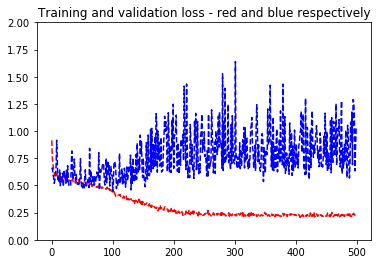

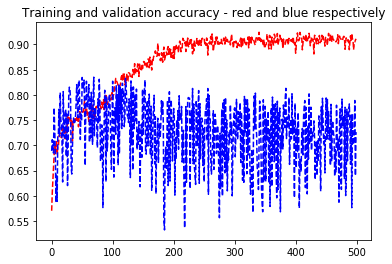

done


In [4]:
saved_dir = 'saved/MaskedVolume_3d/0619_200535'
config_saved_filename = os.path.join(saved_dir, "config.json")
#os.system('tensorboard --logdir ' + log_dir) cannot use with google VM without paying $$$
viewTraining.graphLoss(saved_dir, best=False) #imported from utils

print('done')

In [10]:
def main2(config, resume):
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader_test', config)
    '''
    
    data_loader = getattr(module_data, config['data_loader']['type'])(
        config['data_loader']['args']['data_dir'],
        batch_size=1,
        shuffle=False,
        validation_split=0.0,
        training=False,
        num_workers=2
    )
    '''
    # build model architecture
    model = get_instance(module_arch, 'arch', config)
    print(model)
    print(torch.cuda.get_device_name(0))
    normalized = False

    
    # get function handles of loss and metrics
    loss_fn = getattr(module_loss, config['loss'])
    criterion = loss_fn(None)
    metric_fns = [getattr(module_metric, met) for met in config['metrics']]
    
    # load state dict
    checkpoint = torch.load(resume)
    state_dict = checkpoint['state_dict'] #dictionary of model parameters from saved file
    if config['n_gpu'] > 1:
        model = torch.nn.DataParallel(model)
    model.load_state_dict(state_dict) 
    
    # prepare model for testing
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval() #tells model to ignore dropout and batch normalization
    
    total_loss = 0.0
    total_metrics = torch.zeros(len(metric_fns))
    
    classes = ('endothelium', 'pct')
    all_pred = []
    all_true = []
    #hm_layers = {'final_layer': 'layer', 'fc_layer': 'fc_layer', 'conv_num': 17, 'fc_num': 3}
    
    #heatmapper = classActivationMap.CAMgenerator(hm_layers, config, model)
    #heatmapper.generateImage(num_images=10)
    
    with torch.no_grad(): #speed up calculations, unable to perform back propogation
        for i, (data, target) in enumerate(tqdm(data_loader)): #tqdm is a progress bar
            data, target = data.to(device), target.to(device)
            output = model(data)
            image = np.squeeze(data[0].cpu().data.numpy())
            all_true.extend(target.cpu().data.numpy())
            all_pred.extend(np.argmax(output.cpu().data.numpy(), axis=1))
            
            #
            # save sample images, or do something with output here
            #
            
            
            if i < 5:
                #util.visualizationOutGray(data, output, target, classes, normalized)
                a=1
                
                
                
            # computing loss, metrics on test set
            loss = criterion(output, target)
            batch_size = data.shape[0]
            total_loss += loss.item() * batch_size
            if output.is_cuda: output = output.cpu()
            if target.is_cuda: target = target.cpu()
            
            for i, metric in enumerate(metric_fns):
                total_metrics[i] += metric(output, target) * batch_size
        
        #plt.show()
        
    
    n_samples = len(data_loader.sampler)
    print("num test images = " + str(n_samples))
    log = {'loss': total_loss / n_samples}
    log.update({met.__name__: total_metrics[i].item() / n_samples for i, met in enumerate(metric_fns)})
    for key in log:
        print("{} = {:.4f}".format(key, log[key]))
    #print(log)
    log['classes'] = classes
    log['test_targets'] = all_true
    log['test_predictions'] = all_pred
    print("My_metric is accuracy")
    util.plot_confusion_matrix(all_true, all_pred, classes=classes, normalize=False) 
    


In [11]:
#saved_dir = "saved/GroundTruth_cellData/0529_191042/"
resume = os.path.join(saved_dir, "model_best.pth")

print(os.path.isdir(saved_dir))
print(os.path.exists(resume))

#config = torch.load(saved_dir + "config.json")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

True
True


  0%|          | 0/4 [00:00<?, ?it/s]

threeDmodel(
  (conv_layer1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Leaky

100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


num test images = 230
loss = 0.6144
my_metric = 0.7391
f1 = 0.7331
balanced_accuracy = 0.7405
precision = 0.7623
recall = 0.7391
My_metric is accuracy
Confusion matrix, without normalization
[[91 20]
 [40 79]]


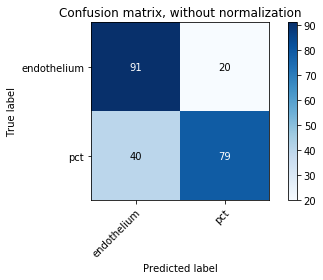

In [12]:
#Test
main2(config, resume)